# Da3n3rys Playbook 01 - Memory Dump Analisys for Windows OS

This playbook executes Volatility and other tools in order to extract the most common and useful information from a memory image. 
<a id='table_of_contents'></a>
### Table of contents

- [1. Image Identification](#image_identification)
- [2. Users Information & Activity](#users_information)
- [3. Registry Information](#registry_information)
- [4. Console History](#console_history)
- [5. Users Credentials](#users_credentials)
- [6. Browser History](#browser_history)
- [7. Process & Services Information](#process_information)
- [8. Files Information](#files_information)
- [9. Network Information](#network_information)
- [10. Windows Event Logs Extraction](#windows_events)
- [11. Malicious Code Investigation](#malicious_code)
- [12. Advanced Investigation - Extracting Files](#advanced_extract_files)
- [13. Advanced Investigation - Searching Strings](#advanced_search_strings)
- [14. IOCs List](#iocs_list)

### Prerequisites

Please, in order to execute this playbook, complete or modify these information in the following section:
    
    base_path: Full path of the DFIR Playbooks.
    case_path: Full path for the incident case. This folder will host all the reports extracted from the analysis.
    dump_path: Full path for the extracted files from the case.
    filename: Name of the file to be analyzed. Place the file in the case_path.

And also, install the following dependencies:

    yarascan
    dot - sudo apt install graphviz

This playbook also works with <b>hiberfil.sys</b> and <b>pagefile.sys</b> files and <b>.vmem</b>(Virtual Machine Memory) files. If you want to analyze these files, please, don't change it's names or extensions.

In [1]:
base_path="/home/mmatari/Notebooks"
case_path="/home/mmatari/Notebooks/evidences/case2"
dump_path="/home/mmatari/Notebooks"
plugins_path="/home/mmatari/Notebooks/tools/volatility/contrib/plugins"
css_file="/home/mmatari/Notebooks/css/custom.css"
filename="Virgo.dmp"

from IPython.display import display, HTML, Image

#HTML(open(css_file, "r").read())

<a id='image_identification'></a>
### 1. Image Identification
[Top](#table_of_contents)

<b>md5 image hash</b>

In [2]:
md5=!md5sum $case_path/$filename
print(md5)

['4b96013e414ca94ea6889caa773fae20  /home/mmatari/Notebooks/evidences/case2/Virgo.dmp']


<b>imageinfo:</b> Identifies the operating system, service pack, and hardware architecture (32 or 64 bit), but it also contains other useful information such as the DTB address* and time the sample was collected.

<b>WARNING: This module will select an image profile automatically, please, change manually the profile variable if you need to use another one.</b>

*DTB (Directory Table Base) is what Volatility uses to translate virtual addresses to physical addresses. 

In [3]:
imageinfo=!python $base_path/tools/volatility/vol.py -f $case_path/$filename imageinfo

for row in imageinfo[2:]:
    if "Suggested" in row:
        print(row)
        profile = row.split()[3].replace(',', '')
       
#Uncomment if needed
profile="Win10x64_15063"
        
print("Profile selected for this analysis: ", profile)

          Suggested Profile(s) : Win10x64_17134, Win10x64_10240_17770, Win10x64_10586, Win10x64_14393, Win10x64, Win2016x64_14393, Win10x64_16299, Win10x64_17763, Win10x64_15063 (Instantiated with Win10x64_15063)
Profile selected for this analysis:  Win10x64_15063


<b>kdbgscan:</b> As opposed to imageinfo which simply provides profile suggestions, kdbgscan is designed to positively identify the correct profile and the correct KDBG address (if there happen to be multiple). This plugin scans for the KDBGHeader signatures linked to Volatility profiles and applies sanity checks to reduce false positives. 

If you find 0 processes and 0 modules in this output and another KDBG with more data, copy its Offset value here:

kdgb="--kdbg=Offset (V)"

In [4]:
kdgb=""
!python $base_path/tools/volatility/vol.py -f $case_path/$filename kdbgscan

Volatility Foundation Volatility Framework 2.6.1
**************************************************
Instantiating KDBG using: Kernel AS Win10x64 (6.4.9841 64bit)
Offset (V)                    : 0xf80349f4c4d0
Offset (P)                    : 0x234c4d0
KdCopyDataBlock (V)           : 0xf80349dfb624
Block encoded                 : No
Wait never                    : 0x108d0400b4321401
Wait always                   : 0x2d0c92ea42360
KDBG owner tag check          : True
Profile suggestion (KDBGHeader): Win10x64
Version64                     : 0xf80349f4f5a8 (Major: 15, Minor: 16299)
Service Pack (CmNtCSDVersion) : 0
Build string (NtBuildLab)     : 16299.15.amd64fre.rs3_release.17
PsActiveProcessHead           : 0xfffff80349f5bae0 (80 processes)
PsLoadedModuleList            : 0xfffff80349f62ff0 (165 modules)
KernelBase                    : 0xfffff80349c01000 (Matches MZ: True)
Major (OptionalHeader)        : 10
Minor (OptionalHeader)        : 0
KPCR                          : 0xfffff8034908c

Version64                     : 0xf80349f4f5a8 (Major: 15, Minor: 16299)
Service Pack (CmNtCSDVersion) : 0
Build string (NtBuildLab)     : 16299.15.amd64fre.rs3_release.17
PsActiveProcessHead           : 0xfffff80349f5bae0 (80 processes)
PsLoadedModuleList            : 0xfffff80349f62ff0 (165 modules)
KernelBase                    : 0xfffff80349c01000 (Matches MZ: True)
Major (OptionalHeader)        : 10
Minor (OptionalHeader)        : 0
KPCR                          : 0xfffff8034908c000 (CPU 0)

**************************************************
Instantiating KDBG using: Kernel AS Win10x64_17763 (6.4.17763 64bit)
Offset (V)                    : 0xf80349f4c4d0
Offset (P)                    : 0x234c4d0
KdCopyDataBlock (V)           : 0xf80349dfb624
Block encoded                 : No
Wait never                    : 0x108d0400b4321401
Wait always                   : 0x2d0c92ea42360
KDBG owner tag check          : True
Profile suggestion (KDBGHeader): Win10x64_17763
Version64              

<b>hiberfil.sys:</b> Since the hibernation file is just a compressed copy of the memory, we can use Volatility the same way we would with any other memory sample. But, we will need to first decompress it by converting it to a raw memory dump. This too can be done using Volatility. 

Volatility will actually work with the hiberfil.sys file, but it is extremely slow because it will have to decompress it every time a different plugin is used. Just decompress it once using the imagecopy plugin and it will speed up the process.

In [5]:
if "hiberfil.sys" in filename:
    !python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile imagecopy -O $case_path/rawimage.img
    filename="rawimage.img"

<b>pagefile.sys:</b> Microsoft Windows uses a paging file, called pagefile.sys, to store page-size blocks of memory that do not current fit into physical memory.
This file, stored in %SystemDrive%\pagefile.sys is a hidden system file and it can never be read or accessed by a user, including Administrator.

It is possible to read this file by parsing the raw file system, or exact it using tools like FTKImager.
Contrary to hybernation files, page files cannot be processed with Volatility: in fact the page file is just the “holes” in memory where blocks are stored to disk, it will often contain information that can be relevant to the case you are trying to solve.

Because storage locations in the paging file are not necessarily sequential, it is unlikely to find consecutive pages there.
Although it is possible to find data in chunks smaller than or equal to 4KB, its the largest an examiner can hope for.
So, the most productive method for analyzing paging files is searching for strings.

In [6]:
if "pagefile.sys" in filename:
    print("List all paths in pagefile")
    !strings pagefile.sys | grep -i "^[a-z]:\\\\" | sort | uniq | less 
    print("Search for enviroment variables")
    !strings pagefile.sys | grep -i "^[a-zA-Z09_]*=.*" | sort -u | uniq | less
    print("Search for URLs:")
    !strings pagefile.sys | egrep "^https?://" | sort | uniq | less
    print("Search for email addresses:")
    !strings pagefile.sys | egrep '([[:alnum:]_.-]{1,64}+@[[:alnum:]_.-]{2,255}+?\.[[:alpha:].]{2,4})' 
    print("Search malware using yararules")
    !yara malware_rules.yar pagefile.sys
    #stops the notebook execution
    %%javascript
    Jupyter.notebook.session.delete();

<b>.vmem:</b> Virtual Memory or VMEM is a file extension used by virtualization software like VMware, Virtualbox etc. VMEM files generally store RAM or Physical Memory of the related virtual machine.

In [7]:
if ".vmem" in filename:
    !python $base_path/tools/volatility/vol.py -f $case_path/$filename imagecopy -O $case_path/rawimage.img --profile=$profile
    filename="rawimage.img"

<a id='users_information'></a>
### 2. Users Information & Activity
[Top](#table_of_contents)

<b>clipboard:</b> Extract the contents of the windows clipboard.

In [8]:
!python /home/mmatari/Notebooks/tools/volatility/vol.py -f $case_path/$filename --profile=$profile clipboard $kdgb

Volatility Foundation Volatility Framework 2.6.1
Session    WindowStation Format                         Handle Object             Data                                              
---------- ------------- ------------------ ------------------ ------------------ --------------------------------------------------


<b>wndscan:</b> This command scans for tagWINDOWSTATION objects and prints details on the window station*, its global atom table, available clipboard formats, and processes or threads currently interacting with the clipboard.

From a forensic standpoint, by analyzing window stations objects, you can detect applications snooping on clipboard activity along with the frequency of clipboard usage and the available data formats.

If the <b>cNumClipFormats</b> and <b>iClipSerialNumber</b> are both 0, this means this window station’s clipboard has never been used.

Windows station act as security boundaries for processes and desktops. If you're not already familiar with these objects, see Sessions, Desktops, and Window Stations (http://blogs.technet.com/b/askperf/archive/2007/07/24/sessions-desktops-and-windows-stations.aspx ) or Window Stations and Desktops (https://docs.microsoft.com/es-es/windows/win32/winstation/window-stations-and-desktops ).

More information about Clipboard Snooping Malware here: https://volatility-labs.blogspot.com/2012/09/movp-12-window-stations-and-clipboard.html

In [9]:
!python /home/mmatari/Notebooks//tools/volatility/vol.py -f $case_path/$filename --profile=$profile wndscan $kdgb

Volatility Foundation Volatility Framework 2.6.1


<b>deskscan:</b> This command subclasses the wndscan plugin and for each window station found, it walks the list of desktops. It can be used for the following purposes:

   - Find rogue desktops used to hide applications from logged-on users.
   - Detect desktops created by ransomware.
   - Link threads to their desktops.
   - Analyze the desktop heap for memory corruptions.
   - Profile dekstop heap allocations to locate USER objects.

In [10]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile deskscan $kdgb

Volatility Foundation Volatility Framework 2.6.1


<b>notepad:</b> List currently displayed notepad text.

In [11]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile notepad $kdgb

Volatility Foundation Volatility Framework 2.6.1
ERROR   : volatility.debug    : This command does not support the profile Win10x64_15063


<b>Recently clicked applications and shortcuts:</b>

In [12]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile userassist $kdgb | grep REG_BINARY

Volatility Foundation Volatility Framework 2.6.1


<b>Find prefetch files:</b> Recently executed programs.

In [13]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile mftparser $kdgb | grep \.pf$

Volatility Foundation Volatility Framework 2.6.1
2019-07-05 21:20:37 UTC+0000 2019-07-05 21:20:37 UTC+0000   2019-07-05 21:20:37 UTC+0000   2019-07-05 21:20:37 UTC+0000   Windows\Prefetch\MCBUILDER.EXE-7F26B913.pf
2019-09-04 06:23:56 UTC+0000 2019-09-04 06:23:56 UTC+0000   2019-09-04 06:23:56 UTC+0000   2019-09-04 06:23:56 UTC+0000   Windows\Prefetch\W3WP.EXE-53273A08.pf
2019-09-04 06:21:37 UTC+0000 2019-09-04 06:21:37 UTC+0000   2019-09-04 06:21:37 UTC+0000   2019-09-04 06:21:37 UTC+0000   Windows\Prefetch\WUAPIHOST.EXE-8C63377C.pf
2019-09-04 06:18:43 UTC+0000 2019-09-04 06:18:43 UTC+0000   2019-09-04 06:18:43 UTC+0000   2019-09-04 06:18:43 UTC+0000   Windows\Prefetch\INETMGR.EXE-AC315841.pf
2019-09-04 06:22:43 UTC+0000 2019-09-04 06:22:43 UTC+0000   2019-09-04 06:22:43 UTC+0000   2019-09-04 06:22:43 UTC+0000   Windows\Prefetch\NET1.EXE-849DA590.pf
2019-09-04 06:22:43 UTC+0000 2019-09-04 06:22:43 UTC+0000   2019-09-04 06:22:43 UTC+0000   2019-09-04 06:22:43 UTC+0000   Windows\Prefetch

2019-07-06 07:52:15 UTC+0000 2019-07-06 07:52:15 UTC+0000   2019-07-06 07:52:15 UTC+0000   2019-07-06 07:52:15 UTC+0000   Windows\Prefetch\CONSENT.EXE-531BD9EA.pf
2020-05-19 15:06:04 UTC+0000 2020-05-19 15:06:04 UTC+0000   2020-05-19 15:06:04 UTC+0000   2020-05-19 15:06:04 UTC+0000   Windows\Prefetch\VCREDIST_X64.EXE-ED276472.pf
2019-07-06 07:48:02 UTC+0000 2019-07-06 07:48:02 UTC+0000   2019-07-06 07:48:02 UTC+0000   2019-07-06 07:48:02 UTC+0000   Windows\Prefetch\CTFMON.EXE-9450846B.pf
2019-09-04 06:17:58 UTC+0000 2019-09-04 06:17:58 UTC+0000   2019-09-04 06:17:58 UTC+0000   2019-09-04 06:17:58 UTC+0000   Windows\Prefetch\MMC.EXE-7FBB0956.pf
2019-07-06 07:49:19 UTC+0000 2019-07-06 07:49:19 UTC+0000   2019-07-06 07:49:19 UTC+0000   2019-07-06 07:49:19 UTC+0000   Windows\Prefetch\DLLHOST.EXE-88F23425.pf
2019-07-06 07:47:11 UTC+0000 2019-07-06 07:47:11 UTC+0000   2019-07-06 07:47:11 UTC+0000   2019-07-06 07:47:11 UTC+0000   Windows\Prefetch\WMIPRVSE.EXE-1628051C.pf
2019-07-06 07:47:14 U

2019-07-06 07:48:04 UTC+0000 2019-07-06 07:48:04 UTC+0000   2019-07-06 07:48:04 UTC+0000   2019-07-06 07:48:04 UTC+0000   Windows\Prefetch\USERINIT.EXE-2257A3E7.pf
2020-05-19 15:06:50 UTC+0000 2020-05-19 15:06:50 UTC+0000   2020-05-19 15:06:50 UTC+0000   2020-05-19 15:06:50 UTC+0000   Windows\Prefetch\VGAUTHSERVICE.EXE-5C76DC64.pf
2019-09-04 05:57:09 UTC+0000 2019-09-04 05:57:09 UTC+0000   2019-09-04 05:57:09 UTC+0000   2019-09-04 05:57:09 UTC+0000   Windows\Prefetch\RUNTIMEBROKER.EXE-2EB76FE6.pf
2019-09-04 05:55:39 UTC+0000 2019-09-04 05:55:39 UTC+0000   2019-09-04 05:55:39 UTC+0000   2019-09-04 05:55:39 UTC+0000   Windows\Prefetch\VMWARERESOLUTIONSET.EXE-79C811DD.pf
2019-07-06 07:46:14 UTC+0000 2019-07-06 07:46:14 UTC+0000   2019-07-06 07:46:14 UTC+0000   2019-07-06 07:46:14 UTC+0000   Windows\Prefetch\TASKHOSTW.EXE-3E0B74C8.pf
2019-07-05 21:19:29 UTC+0000 2019-07-05 21:19:29 UTC+0000   2019-07-05 21:19:29 UTC+0000   2019-07-05 21:19:29 UTC+0000   Windows\Prefetch\WERMGR.EXE-0F2AC88C

2019-07-05 21:20:33 UTC+0000 2019-07-05 21:20:33 UTC+0000   2019-07-05 21:20:33 UTC+0000   2019-07-05 21:20:33 UTC+0000   Windows\Prefetch\DLLHOST.EXE-077DD0E6.pf
2020-05-19 15:05:31 UTC+0000 2020-05-19 15:05:31 UTC+0000   2020-05-19 15:05:31 UTC+0000   2020-05-19 15:05:31 UTC+0000   Windows\Prefetch\DLLHOST.EXE-E4DB4546.pf
2019-09-04 05:57:20 UTC+0000 2019-09-04 05:57:20 UTC+0000   2019-09-04 05:57:20 UTC+0000   2019-09-04 05:57:20 UTC+0000   Windows\Prefetch\SVCHOST.EXE-1CCEF527.pf
2019-07-06 07:47:51 UTC+0000 2019-07-06 07:47:51 UTC+0000   2019-07-06 07:47:51 UTC+0000   2019-07-06 07:47:51 UTC+0000   Windows\Prefetch\RUNDLL32.EXE-ED95E4BB.pf
2019-07-06 07:50:23 UTC+0000 2019-07-06 07:50:23 UTC+0000   2019-07-06 07:50:23 UTC+0000   2019-07-06 07:50:23 UTC+0000   Windows\Prefetch\JUSCHED.EXE-60F1FB86.pf
2019-07-05 21:16:05 UTC+0000 2019-07-05 21:16:05 UTC+0000   2019-07-05 21:16:05 UTC+0000   2019-07-05 21:16:05 UTC+0000   Windows\Prefetch\INETINFO.EXE-0FBED007.pf
2019-09-04 06:00:48 

<b>sessions:</b> A plugin to report on active (and in some cases, terminated) logon sessions from Windows based memory dumps, including their associated processes, kernel modules, pool, and page tables. 

Here are some ways you might use this plugin:

   - <b>Link processes to their logon sessions:</b> you see abc.exe running and you want to know if it was launched by someone over RDP or by the user physically sitting at the console. 
   - <b>Detect hidden processes:</b> each session structure contains a linked list of processes for that session. If malware unlinks a process from PsActiveProcessHead, you can leverage this alternate process listing as a means to identify the hidden process. 
   - <b>Determine kernel drivers:</b> each session structure contains a list of drivers mapped into the session. You can use this to distinguish RDP sessions from console or fast-user switching sessions and also for miscellaneous tasks like determining if the system is a VMware virtual machine. 


In [14]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile sessions $kdgb

Volatility Foundation Volatility Framework 2.6.1
**************************************************
Session(V): ffff94812e205000 ID: 0 Processes: 52
PagedPoolStart: ffff8abe80000000 PagedPoolEnd ffff8ade7fffffff
 Process: 384 csrss.exe 2020-09-07 07:52:44 UTC+0000
 Process: 464 wininit.exe 2020-09-07 07:52:44 UTC+0000
 Process: 560 services.exe 2020-09-07 07:52:44 UTC+0000
 Process: 568 lsass.exe 2020-09-07 07:52:44 UTC+0000
 Process: 700 svchost.exe 2020-09-07 07:52:45 UTC+0000
 Process: 716 fontdrvhost.ex 2020-09-07 07:52:45 UTC+0000
 Process: 804 svchost.exe 2020-09-07 07:52:45 UTC+0000
 Process: 976 svchost.exe 2020-09-07 07:52:45 UTC+0000
 Process: 984 svchost.exe 2020-09-07 07:52:45 UTC+0000
 Process: 992 svchost.exe 2020-09-07 07:52:45 UTC+0000
 Process: 272 svchost.exe 2020-09-07 07:52:46 UTC+0000
 Process: 328 svchost.exe 2020-09-07 07:52:46 UTC+0000
 Process: 400 svchost.exe 2020-09-07 07:52:46 UTC+0000
 Process: 412 svchost.exe 2020-09-07 07:52:46 UTC+0000
 Process: 1036 svc

<b>Timeline:</b>

In [15]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile timeliner $kdgb

Volatility Foundation Volatility Framework 2.6.1
2020-09-07 11:24:47 UTC+0000|[LIVE RESPONSE]| (System time)|
2020-09-07 07:52:44 UTC+0000|[PROCESS]| wininit.exe| PID: 464/PPID: 376/POffset: 0x22345080
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| wininit.exe PID: 464/PPID: 376/POffset: 0x22345080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| wininit.exe PID: 464/PPID: 376/POffset: 0x22345080
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| wininit.exe PID: 464/PPID: 376/POffset: 0x22345080
2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| wininit.exe PID: 464/PPID: 376/POffset: 0x22345080
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\CONTROL PANEL\INTERNATIONAL| wininit.exe PID: 464/PPID: 376/POffset: 0x22345080
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\MI

2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| svchost.exe PID: 984/PPID: 560/POffset: 0x370815c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 984/PPID: 560/POffset: 0x370815c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 984/PPID: 560/POffset: 0x370815c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 984/PPID: 560/POffset: 0x370815c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| svchost.exe PID: 984/PPID: 560/POffset: 0x370815c0
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| svchost.exe PID: 984/PPID: 560/POffset: 0x370815c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 984/PPID: 560/POffset: 0x370815c0
2020-0

2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\INTERNET SETTINGS\CONNECTIONS| svchost.exe PID: 984/PPID: 560/POffset: 0x370815c0
2019-07-06 07:46:52 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\PUSHNOTIFICATIONS\WPNIDM| svchost.exe PID: 984/PPID: 560/POffset: 0x370815c0
2020-09-07 07:58:03 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\PUSHNOTIFICATIONS| svchost.exe PID: 984/PPID: 560/POffset: 0x370815c0
2053-03-09 12:52:42 UTC+0000|[PE HEADER (exe)]| svchost.exe| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ff608550000
2053-03-09 12:52:42 UTC+0000|[PE DEBUG]| svchost.exe| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ff608550000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (exe)]| svchost.exe| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ff608550000
2008-12-04 08:25

1992-04-16 19:53:33 UTC+0000|[PE HEADER (dll)]| devicesetupmanager.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7bd10000
-|[PE DEBUG]| devicesetupmanager.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7bd10000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| devicesetupmanager.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7bd10000
2077-07-24 03:29:05 UTC+0000|[PE HEADER (dll)]| execmodelproxy.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa62a20000
-|[PE DEBUG]| execmodelproxy.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa62a20000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| execmodelproxy.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa62a20000
2017-06-09 12:33:53 UTC+0000|[PE HEADER (dll)]| winsqlite3.dll| Process: svchost.exe

-|[PE DEBUG]| policymanager.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa78680000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| policymanager.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa78680000
1975-08-05 12:32:33 UTC+0000|[PE HEADER (dll)]| bcrypt.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7e840000
1975-08-05 12:32:33 UTC+0000|[PE DEBUG]| bcrypt.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7e840000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| bcrypt.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7e840000
2055-08-21 18:30:18 UTC+0000|[PE HEADER (dll)]| dhcpcsvc6.DLL| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa79460000
-|[PE DEBUG]| dhcpcsvc6.DLL| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL

2105-03-01 06:52:49 UTC+0000|[PE HEADER (dll)]| wmisvc.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa76c30000
-|[PE DEBUG]| wmisvc.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa76c30000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| wmisvc.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa76c30000
1979-02-10 14:43:36 UTC+0000|[PE HEADER (dll)]| SYSNTFY.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7d5e0000
-|[PE DEBUG]| SYSNTFY.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7d5e0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| SYSNTFY.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7d5e0000
2103-04-29 16:34:00 UTC+0000|[PE HEADER (dll)]| bitsigd.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x

-|[PE DEBUG]| kerberos.DLL| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7e630000
2020-09-07 07:52:48 UTC+0000|[DLL LOADTIME (dll)]| kerberos.DLL| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7e630000
2038-09-06 12:53:38 UTC+0000|[PE HEADER (dll)]| profext.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7dec0000
-|[PE DEBUG]| profext.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7dec0000
2020-09-07 07:55:10 UTC+0000|[DLL LOADTIME (dll)]| profext.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7dec0000
2081-07-16 20:32:23 UTC+0000|[PE HEADER (dll)]| USERENV.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7ec40000
-|[PE DEBUG]| USERENV.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7ec40000
2020-09-07 07:52

2049-05-24 03:25:16 UTC+0000|[PE DEBUG]| FirewallAPI.DLL| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7ddf0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| FirewallAPI.DLL| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7ddf0000
2096-06-25 05:07:12 UTC+0000|[PE HEADER (dll)]| Windows.Networking.HostName.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa66830000
-|[PE DEBUG]| Windows.Networking.HostName.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa66830000
2020-09-07 07:52:58 UTC+0000|[DLL LOADTIME (dll)]| Windows.Networking.HostName.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa66830000
1999-12-07 20:45:06 UTC+0000|[PE HEADER (dll)]| bcryptPrimitives.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7ee40000
1999-12-07 20:45:06 UTC+0000|[PE D

2072-10-28 01:52:46 UTC+0000|[PE HEADER (dll)]| wwapi.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa66ab0000
-|[PE DEBUG]| wwapi.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa66ab0000
2020-09-07 07:52:58 UTC+0000|[DLL LOADTIME (dll)]| wwapi.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa66ab0000
2094-05-24 09:05:41 UTC+0000|[PE HEADER (dll)]| WINNSI.DLL| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7b0c0000
-|[PE DEBUG]| WINNSI.DLL| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7b0c0000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| WINNSI.DLL| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa7b0c0000
1993-07-04 00:15:38 UTC+0000|[PE HEADER (dll)]| ncprov.dll| Process: svchost.exe/PID: 984/PPID: 560/Process POffset: 0x370815c0/DLL Base: 0x7ffa776

2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| jusched.exe PID: 5772/PPID: 5736/POffset: 0x06e6e5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| jusched.exe PID: 5772/PPID: 5736/POffset: 0x06e6e5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\CUSTOMLOCALE| jusched.exe PID: 5772/PPID: 5736/POffset: 0x06e6e5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| jusched.exe PID: 5772/PPID: 5736/POffset: 0x06e6e5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| jusched.exe PID: 5772/PPID: 5736/POffset: 0x06e6e5c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| jusched.exe PID: 5772/PPID: 5736/POffset: 0x06e6e5c0
2019-07-05 21:14:47 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| jusched.exe PID: 5772/PPID: 5736/POffset: 0x06e6e5c0
2

2020-09-07 07:55:24 UTC+0000|[DLL LOADTIME (dll)]| windows.storage.dll| Process: jusched.exe/PID: 5772/PPID: 5736/Process POffset: 0x06e6e5c0/DLL Base: 0x75ed0000
2067-12-25 09:48:55 UTC+0000|[PE HEADER (dll)]| shlwapi.dll| Process: jusched.exe/PID: 5772/PPID: 5736/Process POffset: 0x06e6e5c0/DLL Base: 0x768d0000
-|[PE DEBUG]| shlwapi.dll| Process: jusched.exe/PID: 5772/PPID: 5736/Process POffset: 0x06e6e5c0/DLL Base: 0x768d0000
2020-09-07 07:55:24 UTC+0000|[DLL LOADTIME (dll)]| shlwapi.dll| Process: jusched.exe/PID: 5772/PPID: 5736/Process POffset: 0x06e6e5c0/DLL Base: 0x768d0000
2061-09-24 12:16:01 UTC+0000|[PE HEADER (dll)]| | Process: jusched.exe/PID: 5772/PPID: 5736/Process POffset: 0x06e6e5c0/DLL Base: 0x77060000
-|[PE DEBUG]| | Process: jusched.exe/PID: 5772/PPID: 5736/Process POffset: 0x06e6e5c0/DLL Base: 0x77060000
2020-09-07 07:55:24 UTC+0000|[DLL LOADTIME (dll)]| | Process: jusched.exe/PID: 5772/PPID: 5736/Process POffset: 0x06e6e5c0/DLL Base: 0x77060000
2027-03-28 06:37:00 

2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| svchost.exe PID: 1268/PPID: 560/POffset: 0x7e2c05c0
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| svchost.exe PID: 1268/PPID: 560/POffset: 0x7e2c05c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 1268/PPID: 560/POffset: 0x7e2c05c0
2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| svchost.exe PID: 1268/PPID: 560/POffset: 0x7e2c05c0
2020-05-19 15:06:40 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\WINSOCK2\PARAMETERS\PROTOCOL_CATALOG9| svchost.exe PID: 1268/PPID: 560/POffset: 0x7e2c05c0
2019-07-05 21:19:38 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\INTERNET SETTINGS\CONNECTIONS| svchost.exe PID: 1268/PPID: 560/POffset: 0x7e2c05c0
2019-07-05 21:11:09 UTC

-|[PE DEBUG]| ucrtbase.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa7fb20000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| ucrtbase.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa7fb20000
2059-01-22 18:32:24 UTC+0000|[PE HEADER (dll)]| SspiCli.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa7ec70000
-|[PE DEBUG]| SspiCli.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa7ec70000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| SspiCli.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa7ec70000
2025-02-12 10:55:35 UTC+0000|[PE HEADER (dll)]| webio.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa67b20000
-|[PE DEBUG]| webio.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa67b20000
2020-09-07 07

-|[PE DEBUG]| clbcatq.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa82a50000
2020-09-07 07:52:50 UTC+0000|[DLL LOADTIME (dll)]| clbcatq.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa82a50000
2028-07-13 20:11:04 UTC+0000|[PE HEADER (dll)]| dssenh.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa69c70000
2028-07-13 20:11:04 UTC+0000|[PE DEBUG]| dssenh.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa69c70000
2020-09-07 07:52:52 UTC+0000|[DLL LOADTIME (dll)]| dssenh.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa69c70000
1970-01-21 06:37:01 UTC+0000|[PE HEADER (dll)]| rasadhlp.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa76e60000
-|[PE DEBUG]| rasadhlp.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 

1994-11-20 19:54:09 UTC+0000|[PE HEADER (dll)]| FlightSettings.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa695d0000
-|[PE DEBUG]| FlightSettings.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa695d0000
2020-09-07 07:57:51 UTC+0000|[DLL LOADTIME (dll)]| FlightSettings.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa695d0000
1972-06-14 03:51:42 UTC+0000|[PE HEADER (dll)]| OneCoreCommonProxyStub.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa63be0000
-|[PE DEBUG]| OneCoreCommonProxyStub.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa63be0000
2020-09-07 07:58:03 UTC+0000|[DLL LOADTIME (dll)]| OneCoreCommonProxyStub.dll| Process: svchost.exe/PID: 1268/PPID: 560/Process POffset: 0x7e2c05c0/DLL Base: 0x7ffa63be0000
2088-10-08 01:01:36 UTC+0000|[PE HEADER (dll)]| WINTRUST.dll| Proc

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| services.exe PID: 560/PPID: 464/POffset: 0x26080080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| services.exe PID: 560/PPID: 464/POffset: 0x26080080
2020-05-19 15:06:58 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NETWORKPROVIDER\ORDER| services.exe PID: 560/PPID: 464/POffset: 0x26080080
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SERVICEGROUPORDER| services.exe PID: 560/PPID: 464/POffset: 0x26080080
2020-09-07 08:04:08 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES| services.exe PID: 560/PPID: 464/POffset: 0x26080080
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| services.exe PID: 560/PPID: 464/POffset: 0x26080080
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\CONTROL PANEL\INTERNATIONAL| services.exe PID: 560/PP

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 1712/PPID: 560/POffset: 0x410425c0
2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| svchost.exe PID: 1712/PPID: 560/POffset: 0x410425c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 1712/PPID: 560/POffset: 0x410425c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 1712/PPID: 560/POffset: 0x410425c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 1712/PPID: 560/POffset: 0x410425c0
2020-05-19 15:06:40 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\WINSOCK2\PARAMETERS\PROTOCOL_CATALOG9| svchost.exe PID: 1712/PPID: 560/POffset: 0x410425c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\WINSOCK2\PARAMETERS\NAMESPACE_CATALOG5| svchost.exe PID: 1712/PPID: 560/POffse

2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| RuntimeBroker. PID: 4776/PPID: 700/POffset: 0x08b095c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| RuntimeBroker. PID: 4776/PPID: 700/POffset: 0x08b095c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| RuntimeBroker. PID: 4776/PPID: 700/POffset: 0x08b095c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| RuntimeBroker. PID: 4776/PPID: 700/POffset: 0x08b095c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| RuntimeBroker. PID: 4776/PPID: 700/POffset: 0x08b095c0
2019-07-06 07:51:59 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS| RuntimeBroker. PID: 4776/PPID: 700/POffset: 0x08b095c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| RuntimeBroker. PID: 4776/PPID: 700/POffset: 0x08b095c0
2020-0

2002-10-21 20:21:08 UTC+0000|[PE DEBUG]| combase.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa82690000
2020-09-07 07:55:10 UTC+0000|[DLL LOADTIME (dll)]| combase.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa82690000
2026-11-15 11:22:47 UTC+0000|[PE HEADER (dll)]| InstallService.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa59ca0000
-|[PE DEBUG]| InstallService.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa59ca0000
2020-09-07 08:00:07 UTC+0000|[DLL LOADTIME (dll)]| InstallService.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa59ca0000
2074-02-24 21:04:16 UTC+0000|[PE HEADER (dll)]| Windows.Services.TargetedContent.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa5eeb0000
-|[PE DEBUG]| Windows.Services.TargetedCo

2001-03-28 22:26:21 UTC+0000|[PE HEADER (dll)]| ncrypt.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa7e810000
-|[PE DEBUG]| ncrypt.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa7e810000
2020-09-07 08:00:07 UTC+0000|[DLL LOADTIME (dll)]| ncrypt.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa7e810000
1993-07-18 18:00:49 UTC+0000|[PE HEADER (dll)]| clbcatq.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa82a50000
-|[PE DEBUG]| clbcatq.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa82a50000
2020-09-07 07:55:10 UTC+0000|[DLL LOADTIME (dll)]| clbcatq.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POffset: 0x08b095c0/DLL Base: 0x7ffa82a50000
2083-06-28 21:28:23 UTC+0000|[PE HEADER (dll)]| ntshrui.dll| Process: RuntimeBroker./PID: 4776/PPID: 700/Process POff

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| taskhostw.exe PID: 3948/PPID: 984/POffset: 0x76fa35c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| taskhostw.exe PID: 3948/PPID: 984/POffset: 0x76fa35c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| taskhostw.exe PID: 3948/PPID: 984/POffset: 0x76fa35c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| taskhostw.exe PID: 3948/PPID: 984/POffset: 0x76fa35c0
2019-07-05 21:14:47 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| taskhostw.exe PID: 3948/PPID: 984/POffset: 0x76fa35c0
2019-07-06 07:51:59 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS| taskhostw.exe PID: 3948/PPID: 984/POffset: 0x76fa35c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS

2010-03-12 00:32:21 UTC+0000|[PE HEADER (dll)]| wininet.dll| Process: taskhostw.exe/PID: 3948/PPID: 984/Process POffset: 0x76fa35c0/DLL Base: 0x7ffa81860000
-|[PE DEBUG]| wininet.dll| Process: taskhostw.exe/PID: 3948/PPID: 984/Process POffset: 0x76fa35c0/DLL Base: 0x7ffa81860000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| wininet.dll| Process: taskhostw.exe/PID: 3948/PPID: 984/Process POffset: 0x76fa35c0/DLL Base: 0x7ffa81860000
2002-10-21 20:21:08 UTC+0000|[PE HEADER (dll)]| combase.dll| Process: taskhostw.exe/PID: 3948/PPID: 984/Process POffset: 0x76fa35c0/DLL Base: 0x7ffa82690000
-|[PE DEBUG]| combase.dll| Process: taskhostw.exe/PID: 3948/PPID: 984/Process POffset: 0x76fa35c0/DLL Base: 0x7ffa82690000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| combase.dll| Process: taskhostw.exe/PID: 3948/PPID: 984/Process POffset: 0x76fa35c0/DLL Base: 0x7ffa82690000
2027-06-29 22:34:29 UTC+0000|[PE HEADER (dll)]| USER32.dll| Process: taskhostw.exe/PID: 3948/PPID: 984/Process POffset: 

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2019-07-06 07:51:59 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2017-09-29 13:47:07 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWSRUNTIME| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2017-09-29 14:42:51 UTC+0000|[Handle (Key)]| M

2020-09-07 07:16:27 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\CLOUDSTORE\STORE\CACHE\DEFAULTACCOUNT\$$WINDOWS.DATA.UNIFIEDTILE.LOCALSTARTTILEPROPERTIESMAP\CURRENT| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2020-09-07 07:55:23 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2019-07-06 07:47:50 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\CLOUDSTORE| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2019-07-06 07:47:50 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\CLOUDSTORE| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2020-09-07 07:55:37 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\CURRENT

2019-07-06 07:47:50 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\CLOUDSTORE| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2019-07-06 07:48:27 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\CLOUDSTORE\STORE\CACHE\DEFAULTACCOUNT\$$WINDOWS.DATA.CURATEDTILECOLLECTION.ROOTCOLLECTION\CURRENT| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2019-07-05 21:14:47 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| ShellExperienc PID: 4376/PPID: 700/POffset: 0x1b624080
2017-09-29 02:01:24 UTC+0000|[PE HEADER (dll)]| ShellExperienceHost.exe| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ff6985f0000
2017-09-29 02:01:24 UTC+0000|[PE DEBUG]| ShellExperienceHost.exe| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b62408

-|[PE DEBUG]| Windows.Media.MediaControl.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa5fbd0000
2020-09-07 07:57:11 UTC+0000|[DLL LOADTIME (dll)]| Windows.Media.MediaControl.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa5fbd0000
2039-10-02 11:10:07 UTC+0000|[PE HEADER (dll)]| CoreMessaging.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7c6e0000
-|[PE DEBUG]| CoreMessaging.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7c6e0000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| CoreMessaging.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7c6e0000
2007-11-11 03:13:00 UTC+0000|[PE HEADER (dll)]| KERNELBASE.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7f610000
2007-11-11 03:13:00 UTC+0000|[PE DEBUG]| KERNELBASE.dll

2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| PROPSYS.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7a680000
2029-02-27 15:43:10 UTC+0000|[PE HEADER (dll)]| dwrite.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa69940000
-|[PE DEBUG]| dwrite.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa69940000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| dwrite.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa69940000
2048-08-22 02:33:03 UTC+0000|[PE HEADER (dll)]| windows.ui.core.textinput.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa5f180000
-|[PE DEBUG]| windows.ui.core.textinput.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa5f180000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| windows.ui.core.textinput.dll|

1997-01-22 08:12:12 UTC+0000|[PE HEADER (dll)]| cryptsp.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7e730000
-|[PE DEBUG]| cryptsp.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7e730000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| cryptsp.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7e730000
2082-10-20 15:24:04 UTC+0000|[PE HEADER (dll)]| imagehlp.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7fec0000
-|[PE DEBUG]| imagehlp.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7fec0000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| imagehlp.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7fec0000
2080-06-04 13:23:07 UTC+0000|[PE HEADER (dll)]| MSASN1.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process

-|[PE DEBUG]| d3d11.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7c3f0000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| d3d11.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa7c3f0000
2067-09-30 09:03:58 UTC+0000|[PE HEADER (dll)]| msvcp110_win.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa785f0000
-|[PE DEBUG]| msvcp110_win.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa785f0000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| msvcp110_win.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa785f0000
2080-04-28 01:39:40 UTC+0000|[PE HEADER (dll)]| MFMediaEngine.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1b624080/DLL Base: 0x7ffa5fc30000
-|[PE DEBUG]| MFMediaEngine.dll| Process: ShellExperienc/PID: 4376/PPID: 700/Process POffset: 0x1

2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{905E63B6-C1BF-494E-B29C-65B732D3D21A}\PROPERTYBAG| SearchUI.exe PID: 4464/PPID: 700/POffset: 0x0f08d080
2019-07-06 07:51:55 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\INTERNET EXPLORER\MAIN| SearchUI.exe PID: 4464/PPID: 700/POffset: 0x0f08d080
2020-09-04 12:00:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\POLICIES| SearchUI.exe PID: 4464/PPID: 700/POffset: 0x0f08d080
2019-07-05 21:14:47 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\POLICIES| SearchUI.exe PID: 4464/PPID: 700/POffset: 0x0f08d080
2020-09-07 07:55:06 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE| SearchUI.exe PID: 4464/PPID: 700/POffset: 0x0f08d080
2019-07-05 21:11:08 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE| SearchUI.exe PID: 4464/PPID: 700/POffset: 0x0f08d080
2020-09-0

2019-07-06 07:52:01 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\APPCONTAINER\STORAGE\MICROSOFT.WINDOWS.CORTANA_CW5N1H2TXYEWY\INTERNET SETTINGS\CACHE\EXTENSIBLE CACHE| SearchUI.exe PID: 4464/PPID: 700/POffset: 0x0f08d080
2020-09-07 07:55:09 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER| SearchUI.exe PID: 4464/PPID: 700/POffset: 0x0f08d080
2019-07-05 21:19:40 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\INTERNET EXPLORER| SearchUI.exe PID: 4464/PPID: 700/POffset: 0x0f08d080
2020-09-07 07:55:40 UTC+0000|[Handle (Key)]| A\{06DD2FC9-44E4-F550-805D-70A3B5E28559}\LOCALSTATE\CONFIGURATION| SearchUI.exe PID: 4464/PPID: 700/POffset: 0x0f08d080
2019-07-05 21:19:40 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\INTERNET EX

2017-11-26 12:03:53 UTC+0000|[PE HEADER (exe)]| SearchUI.exe| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ff7e9df0000
-|[PE DEBUG]| SearchUI.exe| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ff7e9df0000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (exe)]| SearchUI.exe| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ff7e9df0000
2008-12-04 08:25:14 UTC+0000|[PE HEADER (dll)]| | Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa831c0000
-|[PE DEBUG]| | Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa831c0000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| | Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa831c0000
2069-12-29 03:31:51 UTC+0000|[PE HEADER (dll)]| AEPIC.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa69d30000
-|

2003-05-02 12:42:12 UTC+0000|[PE HEADER (dll)]| Comctl32.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa77410000
-|[PE DEBUG]| Comctl32.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa77410000
2020-09-07 07:55:37 UTC+0000|[DLL LOADTIME (dll)]| Comctl32.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa77410000
2007-11-11 03:13:00 UTC+0000|[PE HEADER (dll)]| KERNELBASE.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa7f610000
-|[PE DEBUG]| KERNELBASE.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa7f610000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| KERNELBASE.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa7f610000
2077-07-09 01:19:21 UTC+0000|[PE HEADER (dll)]| Windows.Globalization.dll| Process: SearchUI.exe/PID: 4464/PPID: 7

2027-06-29 22:34:29 UTC+0000|[PE HEADER (dll)]| user32.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa81ed0000
-|[PE DEBUG]| user32.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa81ed0000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| user32.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa81ed0000
2017-11-26 12:23:46 UTC+0000|[PE HEADER (dll)]| CortanaApi.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa5d4e0000
-|[PE DEBUG]| CortanaApi.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa5d4e0000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| CortanaApi.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa5d4e0000
2055-07-06 20:10:30 UTC+0000|[PE HEADER (dll)]| slc.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f

2084-10-12 12:43:09 UTC+0000|[PE HEADER (dll)]| GDI32.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa81450000
-|[PE DEBUG]| GDI32.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa81450000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| GDI32.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa81450000
2057-09-25 11:55:23 UTC+0000|[PE HEADER (dll)]| uiautomationcore.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa6bdf0000
-|[PE DEBUG]| uiautomationcore.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa6bdf0000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| uiautomationcore.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa6bdf0000
2040-09-26 11:43:11 UTC+0000|[PE HEADER (dll)]| d2d1.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Proce

1999-01-28 12:38:43 UTC+0000|[PE HEADER (dll)]| IMM32.DLL| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa81830000
-|[PE DEBUG]| IMM32.DLL| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa81830000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| IMM32.DLL| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa81830000
1999-12-07 20:45:06 UTC+0000|[PE HEADER (dll)]| bcryptPrimitives.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa7ee40000
-|[PE DEBUG]| bcryptPrimitives.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa7ee40000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| bcryptPrimitives.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa7ee40000
2052-11-18 05:30:19 UTC+0000|[PE HEADER (dll)]| msctf.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Proc

-|[PE DEBUG]| directmanipulation.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa68f90000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| directmanipulation.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa68f90000
2061-07-19 06:38:10 UTC+0000|[PE HEADER (dll)]| appresolver.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa62630000
-|[PE DEBUG]| appresolver.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa62630000
2020-09-07 07:55:37 UTC+0000|[DLL LOADTIME (dll)]| appresolver.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa62630000
2073-06-21 09:56:26 UTC+0000|[PE HEADER (dll)]| dxgi.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/DLL Base: 0x7ffa7dbb0000
-|[PE DEBUG]| dxgi.dll| Process: SearchUI.exe/PID: 4464/PPID: 700/Process POffset: 0x0f08d080/D

2008-12-04 08:25:14 UTC+0000|[PE DEBUG]| ntdll.dll| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa831c0000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| ntdll.dll| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa831c0000
2084-06-27 06:38:28 UTC+0000|[PE HEADER (dll)]| kernel.appcore.dll| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa7ed80000
-|[PE DEBUG]| kernel.appcore.dll| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa7ed80000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| kernel.appcore.dll| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa7ed80000
2047-02-20 04:05:35 UTC+0000|[PE HEADER (dll)]| DNSAPI.dll| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa7e350000
-|[PE DEBUG]| DNSAPI.dll| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5

-|[PE DEBUG]| rsaenh.dll| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa7e180000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| rsaenh.dll| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa7e180000
1975-01-18 12:53:48 UTC+0000|[PE HEADER (dll)]| IPHLPAPI.DLL| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa7e300000
-|[PE DEBUG]| IPHLPAPI.DLL| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa7e300000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| IPHLPAPI.DLL| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa7e300000
1987-03-26 01:21:20 UTC+0000|[PE HEADER (dll)]| msvcrt.dll| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa813b0000
-|[PE DEBUG]| msvcrt.dll| Process: svchost.exe/PID: 1276/PPID: 560/Process POffset: 0x5b5045c0/DLL Base: 0x7ffa813b0000
2020-09-07 0

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 5300/PPID: 560/POffset: 0x341d9080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 5300/PPID: 560/POffset: 0x341d9080
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 5300/PPID: 560/POffset: 0x341d9080
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| svchost.exe PID: 5300/PPID: 560/POffset: 0x341d9080
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| svchost.exe PID: 5300/PPID: 560/POffset: 0x341d9080
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 5300/PPID: 560/POffset: 0x341d9080
2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| svchost.exe PID: 5300/PPID: 560/POffset: 0x341d9080
2019-07-05 21:11:09 UTC+0000

2020-09-07 11:19:26 UTC+0000|[DLL LOADTIME (dll)]| OLEAUT32.dll| Process: svchost.exe/PID: 5300/PPID: 560/Process POffset: 0x341d9080/DLL Base: 0x7ffa814e0000
2002-10-21 20:21:08 UTC+0000|[PE HEADER (dll)]| combase.dll| Process: svchost.exe/PID: 5300/PPID: 560/Process POffset: 0x341d9080/DLL Base: 0x7ffa82690000
2002-10-21 20:21:08 UTC+0000|[PE DEBUG]| combase.dll| Process: svchost.exe/PID: 5300/PPID: 560/Process POffset: 0x341d9080/DLL Base: 0x7ffa82690000
2020-09-07 11:19:26 UTC+0000|[DLL LOADTIME (dll)]| combase.dll| Process: svchost.exe/PID: 5300/PPID: 560/Process POffset: 0x341d9080/DLL Base: 0x7ffa82690000
2080-09-01 09:40:40 UTC+0000|[PE HEADER (dll)]| wtsapi32.dll| Process: svchost.exe/PID: 5300/PPID: 560/Process POffset: 0x341d9080/DLL Base: 0x7ffa7d2b0000
2080-09-01 09:40:40 UTC+0000|[PE DEBUG]| wtsapi32.dll| Process: svchost.exe/PID: 5300/PPID: 560/Process POffset: 0x341d9080/DLL Base: 0x7ffa7d2b0000
2020-09-07 11:24:40 UTC+0000|[DLL LOADTIME (dll)]| wtsapi32.dll| Process: s

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| mqsvc.exe PID: 1544/PPID: 560/POffset: 0x43a165c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| mqsvc.exe PID: 1544/PPID: 560/POffset: 0x43a165c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| mqsvc.exe PID: 1544/PPID: 560/POffset: 0x43a165c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| mqsvc.exe PID: 1544/PPID: 560/POffset: 0x43a165c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| mqsvc.exe PID: 1544/PPID: 560/POffset: 0x43a165c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\IDS| mqsvc.exe PID: 1544/PPID: 560/POffset: 0x43a165c0
2020-09-07 07:52:49 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\MSMQ\PARAMETERS| mqsvc.exe PID: 1544/PPID: 560/POffset: 0x43a165c0
2020-09-07 07:52:49 UTC+0000|[Handle (Key)]| 

2080-06-04 13:23:07 UTC+0000|[PE HEADER (dll)]| MSASN1.dll| Process: mqsvc.exe/PID: 1544/PPID: 560/Process POffset: 0x43a165c0/DLL Base: 0x7ffa7ed40000
-|[PE DEBUG]| MSASN1.dll| Process: mqsvc.exe/PID: 1544/PPID: 560/Process POffset: 0x43a165c0/DLL Base: 0x7ffa7ed40000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| MSASN1.dll| Process: mqsvc.exe/PID: 1544/PPID: 560/Process POffset: 0x43a165c0/DLL Base: 0x7ffa7ed40000
2047-02-20 04:05:35 UTC+0000|[PE HEADER (dll)]| DNSAPI.dll| Process: mqsvc.exe/PID: 1544/PPID: 560/Process POffset: 0x43a165c0/DLL Base: 0x7ffa7e350000
-|[PE DEBUG]| DNSAPI.dll| Process: mqsvc.exe/PID: 1544/PPID: 560/Process POffset: 0x43a165c0/DLL Base: 0x7ffa7e350000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| DNSAPI.dll| Process: mqsvc.exe/PID: 1544/PPID: 560/Process POffset: 0x43a165c0/DLL Base: 0x7ffa7e350000
2079-08-17 04:01:29 UTC+0000|[PE HEADER (dll)]| profapi.dll| Process: mqsvc.exe/PID: 1544/PPID: 560/Process POffset: 0x43a165c0/DLL Base: 0x7ffa7ed600

2020-09-07 07:52:46 UTC+0000|[PROCESS]| svchost.exe| PID: 1036/PPID: 560/POffset: 0x778255c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| svchost.exe PID: 1036/PPID: 560/POffset: 0x778255c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 1036/PPID: 560/POffset: 0x778255c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 1036/PPID: 560/POffset: 0x778255c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 1036/PPID: 560/POffset: 0x778255c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 1036/PPID: 560/POffset: 0x778255c0
2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| svchost.exe PID: 1036/PPID: 560/POffset: 0x778255c0
2020-05-19 15:06:40 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CO

2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| gdi32full.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa7fc20000
1975-08-05 12:32:33 UTC+0000|[PE HEADER (dll)]| bcrypt.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa7e840000
-|[PE DEBUG]| bcrypt.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa7e840000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| bcrypt.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa7e840000
2002-10-21 20:21:08 UTC+0000|[PE HEADER (dll)]| combase.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa82690000
-|[PE DEBUG]| combase.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa82690000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| combase.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/

2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| logoncli.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa7bb10000
2101-11-06 11:49:12 UTC+0000|[PE HEADER (dll)]| vssapi.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa76120000
-|[PE DEBUG]| vssapi.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa76120000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| vssapi.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa76120000
1997-01-22 08:12:12 UTC+0000|[PE HEADER (dll)]| CRYPTSP.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa7e730000
-|[PE DEBUG]| CRYPTSP.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/DLL Base: 0x7ffa7e730000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| CRYPTSP.dll| Process: svchost.exe/PID: 1036/PPID: 560/Process POffset: 0x778255c0/D

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| dllhost.exe PID: 5948/PPID: 700/POffset: 0x36a7a080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| dllhost.exe PID: 5948/PPID: 700/POffset: 0x36a7a080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| dllhost.exe PID: 5948/PPID: 700/POffset: 0x36a7a080
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| dllhost.exe PID: 5948/PPID: 700/POffset: 0x36a7a080
2019-07-06 07:51:59 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS| dllhost.exe PID: 5948/PPID: 700/POffset: 0x36a7a080
2020-09-07 07:55:23 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES| dllhost.exe PID: 5948/PPID: 700/POffset: 0x36a7a080
2020-09-07 07:55:23 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES| dllhost.exe PID: 5948/PPID: 700/POffset: 0x36a7a080
2019-07-05 21:

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 1152/PPID: 560/POffset: 0x1c6065c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 1152/PPID: 560/POffset: 0x1c6065c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 1152/PPID: 560/POffset: 0x1c6065c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| svchost.exe PID: 1152/PPID: 560/POffset: 0x1c6065c0
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| svchost.exe PID: 1152/PPID: 560/POffset: 0x1c6065c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 1152/PPID: 560/POffset: 0x1c6065c0
2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| svchost.exe PID: 1152/PPID: 560/POffset: 0x1c6065c0
2019-07-05 21:14:47 UTC+0000

2053-03-09 12:52:42 UTC+0000|[PE HEADER (exe)]| svchost.exe| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ff608550000
2053-03-09 12:52:42 UTC+0000|[PE DEBUG]| svchost.exe| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ff608550000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (exe)]| svchost.exe| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ff608550000
2008-12-04 08:25:14 UTC+0000|[PE HEADER (dll)]| ntdll.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa831c0000
2008-12-04 08:25:14 UTC+0000|[PE DEBUG]| ntdll.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa831c0000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| ntdll.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa831c0000
2001-02-03 21:44:07 UTC+0000|[PE HEADER (dll)]| mswsock.dll| Process: svchost.exe/PI

2064-09-05 12:18:14 UTC+0000|[PE DEBUG]| Windows.Web.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa5f630000
2020-09-07 08:07:49 UTC+0000|[DLL LOADTIME (dll)]| Windows.Web.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa5f630000
2099-04-04 17:28:48 UTC+0000|[PE HEADER (dll)]| wshhyperv.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa77dc0000
-|[PE DEBUG]| wshhyperv.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa77dc0000
2020-09-07 07:52:48 UTC+0000|[DLL LOADTIME (dll)]| wshhyperv.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa77dc0000
2066-07-08 22:06:06 UTC+0000|[PE HEADER (dll)]| policymanager.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa78680000
-|[PE DEBUG]| policymanager.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POf

2020-09-07 07:52:48 UTC+0000|[DLL LOADTIME (dll)]| CRYPTBASE.DLL| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa7e750000
2079-08-17 04:01:29 UTC+0000|[PE HEADER (dll)]| profapi.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa7ed60000
2079-08-17 04:01:29 UTC+0000|[PE DEBUG]| profapi.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa7ed60000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| profapi.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa7ed60000
2052-04-16 23:36:57 UTC+0000|[PE HEADER (dll)]| WS2_32.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa825c0000
-|[PE DEBUG]| WS2_32.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa825c0000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| WS2_32.dll| Process: svchost.exe/PID: 1152/PPID: 560/P

2021-10-10 20:17:59 UTC+0000|[PE HEADER (dll)]| RMCLIENT.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa7d6e0000
-|[PE DEBUG]| RMCLIENT.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa7d6e0000
2020-09-07 07:52:48 UTC+0000|[DLL LOADTIME (dll)]| RMCLIENT.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa7d6e0000
2087-08-05 17:43:54 UTC+0000|[PE HEADER (dll)]| Windows.Networking.Connectivity.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa66ad0000
2087-08-05 17:43:54 UTC+0000|[PE DEBUG]| Windows.Networking.Connectivity.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa66ad0000
2020-09-07 08:07:49 UTC+0000|[DLL LOADTIME (dll)]| Windows.Networking.Connectivity.dll| Process: svchost.exe/PID: 1152/PPID: 560/Process POffset: 0x1c6065c0/DLL Base: 0x7ffa66ad0000
1975-01-18 12:53:48 UTC+0000|[

2020-09-07 07:55:21 UTC+0000|[DLL LOADTIME (dll)]| powrprof.dll| Process: MSASCuiL.exe/PID: 5524/PPID: 3140/Process POffset: 0x388f85c0/DLL Base: 0x7ffa7eda0000
2020-09-07 11:22:46 UTC+0000|[PROCESS]| backgroundTask| PID: 4240/PPID: 700/POffset: 0x1ca3b3c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| backgroundTask PID: 4240/PPID: 700/POffset: 0x1ca3b3c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| backgroundTask PID: 4240/PPID: 700/POffset: 0x1ca3b3c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| backgroundTask PID: 4240/PPID: 700/POffset: 0x1ca3b3c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| backgroundTask PID: 4240/PPID: 700/POffset: 0x1ca3b3c0
2019-07-05 21:14:47 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| backgroundTask PID: 4240/PPID: 700/POffset: 0x1ca3b3c0
2019-07-06 07:51:59 UTC+0000|[Handle (K

2027-06-29 22:34:29 UTC+0000|[PE HEADER (dll)]| user32.dll| Process: backgroundTask/PID: 4240/PPID: 700/Process POffset: 0x1ca3b3c0/DLL Base: 0x7ffa81ed0000
-|[PE DEBUG]| user32.dll| Process: backgroundTask/PID: 4240/PPID: 700/Process POffset: 0x1ca3b3c0/DLL Base: 0x7ffa81ed0000
2020-09-07 11:22:46 UTC+0000|[DLL LOADTIME (dll)]| user32.dll| Process: backgroundTask/PID: 4240/PPID: 700/Process POffset: 0x1ca3b3c0/DLL Base: 0x7ffa81ed0000
1976-06-22 06:45:20 UTC+0000|[PE HEADER (dll)]| KERNEL32.DLL| Process: backgroundTask/PID: 4240/PPID: 700/Process POffset: 0x1ca3b3c0/DLL Base: 0x7ffa830e0000
-|[PE DEBUG]| KERNEL32.DLL| Process: backgroundTask/PID: 4240/PPID: 700/Process POffset: 0x1ca3b3c0/DLL Base: 0x7ffa830e0000
2020-09-07 11:22:46 UTC+0000|[DLL LOADTIME (dll)]| KERNEL32.DLL| Process: backgroundTask/PID: 4240/PPID: 700/Process POffset: 0x1ca3b3c0/DLL Base: 0x7ffa830e0000
2045-11-22 03:54:12 UTC+0000|[PE HEADER (dll)]| WINSTA.dll| Process: backgroundTask/PID: 4240/PPID: 700/Process PO

2030-01-21 15:14:12 UTC+0000|[PE DEBUG]| ucrtbase.dll| Process: backgroundTask/PID: 4240/PPID: 700/Process POffset: 0x1ca3b3c0/DLL Base: 0x7ffa7fb20000
2020-09-07 11:22:46 UTC+0000|[DLL LOADTIME (dll)]| ucrtbase.dll| Process: backgroundTask/PID: 4240/PPID: 700/Process POffset: 0x1ca3b3c0/DLL Base: 0x7ffa7fb20000
2042-06-05 04:28:28 UTC+0000|[PE HEADER (dll)]| powrprof.dll| Process: backgroundTask/PID: 4240/PPID: 700/Process POffset: 0x1ca3b3c0/DLL Base: 0x7ffa7eda0000
2042-06-05 04:28:28 UTC+0000|[PE DEBUG]| powrprof.dll| Process: backgroundTask/PID: 4240/PPID: 700/Process POffset: 0x1ca3b3c0/DLL Base: 0x7ffa7eda0000
2020-09-07 11:22:46 UTC+0000|[DLL LOADTIME (dll)]| powrprof.dll| Process: backgroundTask/PID: 4240/PPID: 700/Process POffset: 0x1ca3b3c0/DLL Base: 0x7ffa7eda0000
2020-09-07 11:12:16 UTC+0000|[PROCESS]| cmd.exe| PID: 1868/PPID: 3680/POffset: 0x28f5c080
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| cmd.exe PID: 1868/P

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\LOCALE| dwm.exe PID: 888/PPID: 536/POffset: 0x2b36e5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\LANGUAGE GROUPS| dwm.exe PID: 888/PPID: 536/POffset: 0x2b36e5c0
2037-08-04 09:10:20 UTC+0000|[PE HEADER (exe)]| dwm.exe| Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ff60b3f0000
-|[PE DEBUG]| dwm.exe| Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ff60b3f0000
2020-09-07 07:52:45 UTC+0000|[DLL LOADTIME (exe)]| dwm.exe| Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ff60b3f0000
2008-12-04 08:25:14 UTC+0000|[PE HEADER (dll)]| | Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ffa831c0000
-|[PE DEBUG]| | Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ffa831c0000
2020-09-07 07:52:45 UTC+0000|[DLL LOADTIME (dll)]| | Proce

-|[PE DEBUG]| dwmapi.dll| Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ffa7d5f0000
2020-09-07 07:52:45 UTC+0000|[DLL LOADTIME (dll)]| dwmapi.dll| Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ffa7d5f0000
2103-01-09 11:56:57 UTC+0000|[PE HEADER (dll)]| d3d11.dll| Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ffa7c3f0000
-|[PE DEBUG]| d3d11.dll| Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ffa7c3f0000
2020-09-07 07:52:45 UTC+0000|[DLL LOADTIME (dll)]| d3d11.dll| Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ffa7c3f0000
2105-09-15 02:20:17 UTC+0000|[PE HEADER (dll)]| HID.DLL| Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ffa7db20000
-|[PE DEBUG]| HID.DLL| Process: dwm.exe/PID: 888/PPID: 536/Process POffset: 0x2b36e5c0/DLL Base: 0x7ffa7db20000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| HID.DLL| Pr

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\WINSOCK2\PARAMETERS\NAMESPACE_CATALOG5| svchost.exe PID: 976/PPID: 560/POffset: 0x36fe85c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 976/PPID: 560/POffset: 0x36fe85c0
2019-07-06 07:48:32 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOFTWARE\CLASSES| svchost.exe PID: 976/PPID: 560/POffset: 0x36fe85c0
2020-09-07 07:52:49 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\SHAREDACCESS\EPOCH2| svchost.exe PID: 976/PPID: 560/POffset: 0x36fe85c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\SHAREDACCESS\PARAMETERS\FIREWALLPOLICY\RESTRICTEDSERVICES\CONFIGURABLE| svchost.exe PID: 976/PPID: 560/POffset: 0x36fe85c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\IDS| svchost.exe PID: 976/PPID: 560/POffset: 0x36fe85c0
2019-07-05 21:10:53 UTC+0000|[Handle (Key)]| USER\S-1-5-19\CONTRO

-|[PE DEBUG]| advapi32.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa81780000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| advapi32.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa81780000
1996-03-22 16:41:58 UTC+0000|[PE HEADER (dll)]| appsruprov.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa68e30000
-|[PE DEBUG]| appsruprov.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa68e30000
2020-09-07 07:52:49 UTC+0000|[DLL LOADTIME (dll)]| appsruprov.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa68e30000
1989-07-06 13:46:18 UTC+0000|[PE HEADER (dll)]| adhapi.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa75a50000
-|[PE DEBUG]| adhapi.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa75a50000
2020-09-0

2020-09-07 08:07:48 UTC+0000|[DLL LOADTIME (dll)]| WINSTA.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa7eaf0000
1987-03-26 01:21:20 UTC+0000|[PE HEADER (dll)]| msvcrt.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa813b0000
-|[PE DEBUG]| msvcrt.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa813b0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| msvcrt.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa813b0000
1997-07-19 04:25:41 UTC+0000|[PE HEADER (dll)]| ncuprov.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa685e0000
-|[PE DEBUG]| ncuprov.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa685e0000
2020-09-07 07:52:50 UTC+0000|[DLL LOADTIME (dll)]| ncuprov.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 

2030-06-09 19:55:13 UTC+0000|[PE HEADER (dll)]| radardt.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa62930000
-|[PE DEBUG]| radardt.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa62930000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| radardt.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa62930000
1975-12-14 01:11:07 UTC+0000|[PE HEADER (dll)]| mintdh.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa7db60000
-|[PE DEBUG]| mintdh.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa7db60000
2020-09-07 08:06:57 UTC+0000|[DLL LOADTIME (dll)]| mintdh.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Base: 0x7ffa7db60000
2028-08-18 03:45:55 UTC+0000|[PE HEADER (dll)]| FWPolicyIOMgr.dll| Process: svchost.exe/PID: 976/PPID: 560/Process POffset: 0x36fe85c0/DLL Ba

2020-09-07 07:52:44 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\LSA| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2019-07-06 07:53:48 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\POLICIES\SYSTEM| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2020-09-07 07:52:44 UTC+0000|[Handle (Key)]| MACHINE\SECURITY| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2020-09-04 10:26:10 UTC+0000|[Handle (Key)]| MACHINE\SECURITY\RXACT| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2010-11-21 02:43:10 UTC+0000|[Handle (Key)]| MACHINE\SECURITY\POLICY| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\LSA\AUDIT| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2019-07-06 07:04:25 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\POLICIES\SYSTEM\AUDIT| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| 

2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\MICROSOFT\SYSTEMCERTIFICATES\CA| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2017-09-29 13:47:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\IDENTITYSTORE\PROVIDERS\{B16898C6-A148-4967-9171-64D755DA8520}| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2017-09-29 13:47:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\IDENTITYSTORE\PROVIDERS\{B16898C6-A148-4967-9171-64D755DA8520}| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2019-07-05 21:11:15 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\ENTERPRISECERTIFICATES\DISALLOWED| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2017-09-29 13:47:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\IDENTITYSTORE\PROVIDERS\{B16898C6-A148-4967-9171-64D755DA8520}| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2017-09-29 13:47:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\IDENTITYSTORE\PROVIDERS\{6D0F37E4-4FAC-4E44-9C07-6B8343FE4953}| lsa

2019-07-05 21:16:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\SYSTEMCERTIFICATES\MY| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2019-07-05 21:11:15 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\ENTERPRISECERTIFICATES\DISALLOWED| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2017-09-29 13:47:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\IDENTITYSTORE\PROVIDERS\{B16898C6-A148-4967-9171-64D755DA8520}| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2019-07-05 21:11:15 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\ENTERPRISECERTIFICATES\CA| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2019-07-05 21:11:15 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\SYSTEMCERTIFICATES\CA| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\CRYPTOGRAPHY\OID\ENCODINGTYPE 0\CERTDLLCREATECERTIFICATECHAINENGINE\CONFIG| lsass.exe PID: 568/PPID: 464/POffset: 0x229c1480
2020-05-19 15:04:04 UTC+00

2055-03-23 11:01:40 UTC+0000|[PE HEADER (dll)]| CRYPTBASE.dll| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa7e750000
-|[PE DEBUG]| CRYPTBASE.dll| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa7e750000
2020-09-07 07:52:44 UTC+0000|[DLL LOADTIME (dll)]| CRYPTBASE.dll| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa7e750000
2090-12-30 07:17:57 UTC+0000|[PE HEADER (dll)]| lsasrv.dll| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa7e960000
2090-12-30 07:17:57 UTC+0000|[PE DEBUG]| lsasrv.dll| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa7e960000
2020-09-07 07:52:44 UTC+0000|[DLL LOADTIME (dll)]| lsasrv.dll| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa7e960000
1972-09-20 07:22:36 UTC+0000|[PE HEADER (dll)]| pku2u.DLL| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c

2020-09-07 07:52:49 UTC+0000|[DLL LOADTIME (dll)]| ncryptprov.dll| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa69ca0000
2093-04-19 07:13:50 UTC+0000|[PE HEADER (dll)]| tspkg.DLL| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa7e2e0000
-|[PE DEBUG]| tspkg.DLL| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa7e2e0000
2020-09-07 07:52:44 UTC+0000|[DLL LOADTIME (dll)]| tspkg.DLL| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa7e2e0000
2065-12-04 13:14:17 UTC+0000|[PE HEADER (dll)]| NtlmShared.dll| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa7e4f0000
-|[PE DEBUG]| NtlmShared.dll| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7ffa7e4f0000
2020-09-07 07:52:44 UTC+0000|[DLL LOADTIME (dll)]| NtlmShared.dll| Process: lsass.exe/PID: 568/PPID: 464/Process POffset: 0x229c1480/DLL Base: 0x7f

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\SPOOLER\PERFORMANCE| WmiPrvSE.exe PID: 2708/PPID: 700/POffset: 0x5a7225c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\TAPISRV\PERFORMANCE| WmiPrvSE.exe PID: 2708/PPID: 700/POffset: 0x5a7225c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\TCPIP\PERFORMANCE| WmiPrvSE.exe PID: 2708/PPID: 700/POffset: 0x5a7225c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\TERMSERVICE\PERFORMANCE| WmiPrvSE.exe PID: 2708/PPID: 700/POffset: 0x5a7225c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\UGATHERER\PERFORMANCE| WmiPrvSE.exe PID: 2708/PPID: 700/POffset: 0x5a7225c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\UGTHRSVC\PERFORMANCE| WmiPrvSE.exe PID: 2708/PPID: 700/POffset: 0x5a7225c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\

2080-09-01 09:40:40 UTC+0000|[PE DEBUG]| wtsapi32.dll| Process: WmiPrvSE.exe/PID: 2708/PPID: 700/Process POffset: 0x5a7225c0/DLL Base: 0x7ffa7d2b0000
2020-09-07 07:52:53 UTC+0000|[DLL LOADTIME (dll)]| wtsapi32.dll| Process: WmiPrvSE.exe/PID: 2708/PPID: 700/Process POffset: 0x5a7225c0/DLL Base: 0x7ffa7d2b0000
2036-09-29 19:45:11 UTC+0000|[PE HEADER (dll)]| ole32.dll| Process: WmiPrvSE.exe/PID: 2708/PPID: 700/Process POffset: 0x5a7225c0/DLL Base: 0x7ffa82060000
2036-09-29 19:45:11 UTC+0000|[PE DEBUG]| ole32.dll| Process: WmiPrvSE.exe/PID: 2708/PPID: 700/Process POffset: 0x5a7225c0/DLL Base: 0x7ffa82060000
2020-09-07 11:22:46 UTC+0000|[DLL LOADTIME (dll)]| ole32.dll| Process: WmiPrvSE.exe/PID: 2708/PPID: 700/Process POffset: 0x5a7225c0/DLL Base: 0x7ffa82060000
2042-06-05 04:28:28 UTC+0000|[PE HEADER (dll)]| powrprof.dll| Process: WmiPrvSE.exe/PID: 2708/PPID: 700/Process POffset: 0x5a7225c0/DLL Base: 0x7ffa7eda0000
-|[PE DEBUG]| powrprof.dll| Process: WmiPrvSE.exe/PID: 2708/PPID: 700/Proce

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| winlogon.exe PID: 536/PPID: 456/POffset: 0x25107080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| winlogon.exe PID: 536/PPID: 456/POffset: 0x25107080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| winlogon.exe PID: 536/PPID: 456/POffset: 0x25107080
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| winlogon.exe PID: 536/PPID: 456/POffset: 0x25107080
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| winlogon.exe PID: 536/PPID: 456/POffset: 0x25107080
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| winlogon.exe PID: 536/PPID: 456/POffset: 0x25107080
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| winlogon.exe PID: 536/PPID: 456/POffset: 0x25107080
2020-09-07 07:52:47 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\W

2027-06-29 22:34:29 UTC+0000|[PE HEADER (dll)]| user32.dll| Process: winlogon.exe/PID: 536/PPID: 456/Process POffset: 0x25107080/DLL Base: 0x7ffa81ed0000
-|[PE DEBUG]| user32.dll| Process: winlogon.exe/PID: 536/PPID: 456/Process POffset: 0x25107080/DLL Base: 0x7ffa81ed0000
2020-09-07 07:52:44 UTC+0000|[DLL LOADTIME (dll)]| user32.dll| Process: winlogon.exe/PID: 536/PPID: 456/Process POffset: 0x25107080/DLL Base: 0x7ffa81ed0000
1976-06-22 06:45:20 UTC+0000|[PE HEADER (dll)]| KERNEL32.DLL| Process: winlogon.exe/PID: 536/PPID: 456/Process POffset: 0x25107080/DLL Base: 0x7ffa830e0000
1976-06-22 06:45:20 UTC+0000|[PE DEBUG]| KERNEL32.DLL| Process: winlogon.exe/PID: 536/PPID: 456/Process POffset: 0x25107080/DLL Base: 0x7ffa830e0000
2020-09-07 07:52:44 UTC+0000|[DLL LOADTIME (dll)]| KERNEL32.DLL| Process: winlogon.exe/PID: 536/PPID: 456/Process POffset: 0x25107080/DLL Base: 0x7ffa830e0000
2045-11-22 03:54:12 UTC+0000|[PE HEADER (dll)]| winsta.dll| Process: winlogon.exe/PID: 536/PPID: 456/Proc

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| SMSvcHost.exe PID: 2076/PPID: 560/POffset: 0x43d0a5c0
2019-07-05 21:18:58 UTC+0000|[Handle (Key)]| USER\S-1-5-19| SMSvcHost.exe PID: 2076/PPID: 560/POffset: 0x43d0a5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| SMSvcHost.exe PID: 2076/PPID: 560/POffset: 0x43d0a5c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| SMSvcHost.exe PID: 2076/PPID: 560/POffset: 0x43d0a5c0
2019-07-06 07:48:32 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| SMSvcHost.exe PID: 2076/PPID: 560/POffset: 0x43d0a5c0
2020-09-04 10:12:59 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOFTWARE\CLASSES\LOCAL SETTINGS| SMSvcHost.exe PID: 2076/PPID: 560/POffset: 0x43d0a5c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| SMSvcHost.exe PID: 2076/PPID: 560/POffset: 0x43d0a

2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| USER32.dll| Process: SMSvcHost.exe/PID: 2076/PPID: 560/Process POffset: 0x43d0a5c0/DLL Base: 0x7ffa81ed0000
1976-06-22 06:45:20 UTC+0000|[PE HEADER (dll)]| KERNEL32.dll| Process: SMSvcHost.exe/PID: 2076/PPID: 560/Process POffset: 0x43d0a5c0/DLL Base: 0x7ffa830e0000
-|[PE DEBUG]| KERNEL32.dll| Process: SMSvcHost.exe/PID: 2076/PPID: 560/Process POffset: 0x43d0a5c0/DLL Base: 0x7ffa830e0000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| KERNEL32.dll| Process: SMSvcHost.exe/PID: 2076/PPID: 560/Process POffset: 0x43d0a5c0/DLL Base: 0x7ffa830e0000
2017-09-12 19:32:08 UTC+0000|[PE HEADER (dll)]| System.ni.dll| Process: SMSvcHost.exe/PID: 2076/PPID: 560/Process POffset: 0x43d0a5c0/DLL Base: 0x7ffa72100000
-|[PE DEBUG]| System.ni.dll| Process: SMSvcHost.exe/PID: 2076/PPID: 560/Process POffset: 0x43d0a5c0/DLL Base: 0x7ffa72100000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| System.ni.dll| Process: SMSvcHost.exe/PID: 2076/PPID: 560/Proce

2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| SecurityHealth PID: 2128/PPID: 560/POffset: 0x5867c400
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| SecurityHealth PID: 2128/PPID: 560/POffset: 0x5867c400
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| SecurityHealth PID: 2128/PPID: 560/POffset: 0x5867c400
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| SecurityHealth PID: 2128/PPID: 560/POffset: 0x5867c400
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| SecurityHealth PID: 2128/PPID: 560/POffset: 0x5867c400
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| SecurityHealth PID: 2128/PPID: 560/POffset: 0x5867c400
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| SecurityHealth PID: 2128/PPID: 560/POffset: 0x5867c400
2019-07-05 21:11:12 UTC+

-|[PE DEBUG]| KERNELBASE.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa7f610000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| KERNELBASE.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa7f610000
1999-12-07 20:45:06 UTC+0000|[PE HEADER (dll)]| bcryptPrimitives.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa7ee40000
-|[PE DEBUG]| bcryptPrimitives.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa7ee40000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| bcryptPrimitives.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa7ee40000
2011-12-14 13:07:37 UTC+0000|[PE HEADER (dll)]| gdi32full.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa7fc20000
-|[PE DEBUG]| gdi32full.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Proces

2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| msvcrt.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa813b0000
2049-05-24 03:25:16 UTC+0000|[PE HEADER (dll)]| FirewallAPI.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa7ddf0000
-|[PE DEBUG]| FirewallAPI.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa7ddf0000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| FirewallAPI.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa7ddf0000
1988-08-13 08:18:46 UTC+0000|[PE HEADER (dll)]| shlwapi.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa81c30000
-|[PE DEBUG]| shlwapi.dll| Process: SecurityHealth/PID: 2128/PPID: 560/Process POffset: 0x5867c400/DLL Base: 0x7ffa81c30000
2020-09-07 07:55:21 UTC+0000|[DLL LOADTIME (dll)]| shlwapi.dll| Process: SecurityHealth/PID: 2128/PPID:

2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| vmtoolsd.exe PID: 5604/PPID: 3140/POffset: 0x00a375c0
2020-05-19 15:06:40 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\WINSOCK2\PARAMETERS\PROTOCOL_CATALOG9| vmtoolsd.exe PID: 5604/PPID: 3140/POffset: 0x00a375c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\WINSOCK2\PARAMETERS\NAMESPACE_CATALOG5| vmtoolsd.exe PID: 5604/PPID: 3140/POffset: 0x00a375c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\IDS| vmtoolsd.exe PID: 5604/PPID: 3140/POffset: 0x00a375c0
2020-05-19 15:06:58 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NETWORKPROVIDER\HWORDER| vmtoolsd.exe PID: 5604/PPID: 3140/POffset: 0x00a375c0
2020-05-19 15:06:59 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NETWORKPROVIDER\PROVIDERORDER| vmtoolsd.exe PID: 5604/PPID: 3140/POff

2081-07-16 20:32:23 UTC+0000|[PE HEADER (dll)]| USERENV.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa7ec40000
-|[PE DEBUG]| USERENV.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa7ec40000
2020-09-07 07:55:22 UTC+0000|[DLL LOADTIME (dll)]| USERENV.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa7ec40000
2019-03-08 23:38:58 UTC+0000|[PE HEADER (dll)]| mfc140u.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa58340000
-|[PE DEBUG]| mfc140u.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa58340000
2020-09-07 07:55:22 UTC+0000|[DLL LOADTIME (dll)]| mfc140u.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa58340000
1983-04-18 04:08:41 UTC+0000|[PE HEADER (dll)]| win32u.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 

-|[PE DEBUG]| VCRUNTIME140.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa6fbf0000
2020-09-07 07:55:22 UTC+0000|[DLL LOADTIME (dll)]| VCRUNTIME140.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa6fbf0000
2022-10-23 13:10:14 UTC+0000|[PE HEADER (dll)]| twinapi.appcore.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa7d770000
-|[PE DEBUG]| twinapi.appcore.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa7d770000
2020-09-07 07:55:22 UTC+0000|[DLL LOADTIME (dll)]| twinapi.appcore.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa7d770000
2039-10-02 11:10:07 UTC+0000|[PE HEADER (dll)]| CoreMessaging.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Process POffset: 0x00a375c0/DLL Base: 0x7ffa7c6e0000
-|[PE DEBUG]| CoreMessaging.dll| Process: vmtoolsd.exe/PID: 5604/PPID: 3140/Proc

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 4076/PPID: 560/POffset: 0x5538b5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 4076/PPID: 560/POffset: 0x5538b5c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 4076/PPID: 560/POffset: 0x5538b5c0
2019-07-06 07:48:32 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| svchost.exe PID: 4076/PPID: 560/POffset: 0x5538b5c0
2020-09-04 10:12:59 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOFTWARE\CLASSES\LOCAL SETTINGS| svchost.exe PID: 4076/PPID: 560/POffset: 0x5538b5c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 4076/PPID: 560/POffset: 0x5538b5c0
2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| svchost.exe PID: 4076/PPID: 560/POffset: 0x5538b5c0
2020-09-07 07:53:13 UTC+0000

2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| svchost.exe PID: 1652/PPID: 560/POffset: 0x36ff95c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 1652/PPID: 560/POffset: 0x36ff95c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 1652/PPID: 560/POffset: 0x36ff95c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 1652/PPID: 560/POffset: 0x36ff95c0
2019-07-06 07:48:32 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| svchost.exe PID: 1652/PPID: 560/POffset: 0x36ff95c0
2020-09-04 10:12:59 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOFTWARE\CLASSES\LOCAL SETTINGS| svchost.exe PID: 1652/PPID: 560/POffset: 0x36ff95c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 1652/PPID: 560/POffset: 0x36ff95c0

2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| svchost.exe PID: 1660/PPID: 560/POffset: 0x53aac5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 1660/PPID: 560/POffset: 0x53aac5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 1660/PPID: 560/POffset: 0x53aac5c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 1660/PPID: 560/POffset: 0x53aac5c0
2019-07-06 07:48:32 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| svchost.exe PID: 1660/PPID: 560/POffset: 0x53aac5c0
2020-09-04 10:12:59 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOFTWARE\CLASSES\LOCAL SETTINGS| svchost.exe PID: 1660/PPID: 560/POffset: 0x53aac5c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 1660/PPID: 560/POffset: 0x53aac5c0

2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| Tomcat9w.exe PID: 5640/PPID: 3140/POffset: 0x624ad5c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| Tomcat9w.exe PID: 5640/PPID: 3140/POffset: 0x624ad5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| Tomcat9w.exe PID: 5640/PPID: 3140/POffset: 0x624ad5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| Tomcat9w.exe PID: 5640/PPID: 3140/POffset: 0x624ad5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| Tomcat9w.exe PID: 5640/PPID: 3140/POffset: 0x624ad5c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| Tomcat9w.exe PID: 5640/PPID: 3140/POffset: 0x624ad5c0
2019-07-05 21:14:47 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| Tomcat9w.exe PID: 56

2074-10-10 03:37:34 UTC+0000|[PE HEADER (dll)]| gdi32full.dll| Process: Tomcat9w.exe/PID: 5640/PPID: 3140/Process POffset: 0x624ad5c0/DLL Base: 0x76770000
-|[PE DEBUG]| gdi32full.dll| Process: Tomcat9w.exe/PID: 5640/PPID: 3140/Process POffset: 0x624ad5c0/DLL Base: 0x76770000
2020-09-07 07:55:22 UTC+0000|[DLL LOADTIME (dll)]| gdi32full.dll| Process: Tomcat9w.exe/PID: 5640/PPID: 3140/Process POffset: 0x624ad5c0/DLL Base: 0x76770000
1977-12-10 06:00:13 UTC+0000|[PE HEADER (dll)]| bcryptPrimitives.dll| Process: Tomcat9w.exe/PID: 5640/PPID: 3140/Process POffset: 0x624ad5c0/DLL Base: 0x73580000
-|[PE DEBUG]| bcryptPrimitives.dll| Process: Tomcat9w.exe/PID: 5640/PPID: 3140/Process POffset: 0x624ad5c0/DLL Base: 0x73580000
2020-09-07 07:55:22 UTC+0000|[DLL LOADTIME (dll)]| bcryptPrimitives.dll| Process: Tomcat9w.exe/PID: 5640/PPID: 3140/Process POffset: 0x624ad5c0/DLL Base: 0x73580000
2038-08-21 06:06:26 UTC+0000|[PE HEADER (dll)]| combase.dll| Process: Tomcat9w.exe/PID: 5640/PPID: 3140/Process

2019-07-05 21:14:47 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| sihost.exe PID: 3532/PPID: 984/POffset: 0x7b28d5c0
2031-01-21 10:42:26 UTC+0000|[PE HEADER (exe)]| sihost.exe| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ff68c280000
-|[PE DEBUG]| sihost.exe| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ff68c280000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (exe)]| sihost.exe| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ff68c280000
2008-12-04 08:25:14 UTC+0000|[PE HEADER (dll)]| ntdll.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa831c0000
2008-12-04 08:25:14 UTC+0000|[PE DEBUG]| ntdll.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa831c0000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| ntdll.dll| Process: sihost.exe/PI

-|[PE DEBUG]| twinui.appcore.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa62b00000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| twinui.appcore.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa62b00000
2086-02-09 09:49:13 UTC+0000|[PE HEADER (dll)]| OLEAUT32.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa814e0000
-|[PE DEBUG]| OLEAUT32.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa814e0000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| OLEAUT32.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa814e0000
2002-10-21 20:21:08 UTC+0000|[PE HEADER (dll)]| combase.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa82690000
2002-10-21 20:21:08 UTC+0000|[PE DEBUG]| combase.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0

2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| msvcrt.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa813b0000
2077-07-24 03:29:05 UTC+0000|[PE HEADER (dll)]| execmodelproxy.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa62a20000
-|[PE DEBUG]| execmodelproxy.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa62a20000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| execmodelproxy.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa62a20000
1994-08-08 21:43:46 UTC+0000|[PE HEADER (dll)]| AppXDeploymentClient.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa77a90000
-|[PE DEBUG]| AppXDeploymentClient.dll| Process: sihost.exe/PID: 3532/PPID: 984/Process POffset: 0x7b28d5c0/DLL Base: 0x7ffa77a90000
2020-09-07 11:22:46 UTC+0000|[DLL LOADTIME (dll)]| AppXDeploymentClient.dll| Process: sihost

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 1004/PPID: 560/POffset: 0x2d7e85c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 1004/PPID: 560/POffset: 0x2d7e85c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 1004/PPID: 560/POffset: 0x2d7e85c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| svchost.exe PID: 1004/PPID: 560/POffset: 0x2d7e85c0
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| svchost.exe PID: 1004/PPID: 560/POffset: 0x2d7e85c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 1004/PPID: 560/POffset: 0x2d7e85c0
2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| svchost.exe PID: 1004/PPID: 560/POffset: 0x2d7e85c0
2020-05-19 15:07:05 UTC+0000

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| dllhost.exe PID: 1696/PPID: 560/POffset: 0x1166e5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| dllhost.exe PID: 1696/PPID: 560/POffset: 0x1166e5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| dllhost.exe PID: 1696/PPID: 560/POffset: 0x1166e5c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| dllhost.exe PID: 1696/PPID: 560/POffset: 0x1166e5c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| dllhost.exe PID: 1696/PPID: 560/POffset: 0x1166e5c0
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| dllhost.exe PID: 1696/PPID: 560/POffset: 0x1166e5c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| dllhost.exe PID: 1696/PPID: 560/POffset: 0x1166e5c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASS

-|[PE DEBUG]| clbcatq.dll| Process: dllhost.exe/PID: 1696/PPID: 560/Process POffset: 0x1166e5c0/DLL Base: 0x7ffa82a50000
2020-09-07 07:52:50 UTC+0000|[DLL LOADTIME (dll)]| clbcatq.dll| Process: dllhost.exe/PID: 1696/PPID: 560/Process POffset: 0x1166e5c0/DLL Base: 0x7ffa82a50000
2026-01-26 21:12:37 UTC+0000|[PE HEADER (dll)]| catsrv.dll| Process: dllhost.exe/PID: 1696/PPID: 560/Process POffset: 0x1166e5c0/DLL Base: 0x7ffa67640000
-|[PE DEBUG]| catsrv.dll| Process: dllhost.exe/PID: 1696/PPID: 560/Process POffset: 0x1166e5c0/DLL Base: 0x7ffa67640000
2020-09-07 07:52:51 UTC+0000|[DLL LOADTIME (dll)]| catsrv.dll| Process: dllhost.exe/PID: 1696/PPID: 560/Process POffset: 0x1166e5c0/DLL Base: 0x7ffa67640000
2084-10-12 12:43:09 UTC+0000|[PE HEADER (dll)]| GDI32.dll| Process: dllhost.exe/PID: 1696/PPID: 560/Process POffset: 0x1166e5c0/DLL Base: 0x7ffa81450000
-|[PE DEBUG]| GDI32.dll| Process: dllhost.exe/PID: 1696/PPID: 560/Process POffset: 0x1166e5c0/DLL Base: 0x7ffa81450000
2020-09-07 07:52:5

2020-09-07 07:54:51 UTC+0000|[DLL LOADTIME (dll)]| wtsapi32.dll| Process: svchost.exe/PID: 804/PPID: 560/Process POffset: 0x37a5f5c0/DLL Base: 0x7ffa7d2b0000
1976-06-22 06:45:20 UTC+0000|[PE HEADER (dll)]| KERNEL32.DLL| Process: svchost.exe/PID: 804/PPID: 560/Process POffset: 0x37a5f5c0/DLL Base: 0x7ffa830e0000
-|[PE DEBUG]| KERNEL32.DLL| Process: svchost.exe/PID: 804/PPID: 560/Process POffset: 0x37a5f5c0/DLL Base: 0x7ffa830e0000
2020-09-07 07:52:45 UTC+0000|[DLL LOADTIME (dll)]| KERNEL32.DLL| Process: svchost.exe/PID: 804/PPID: 560/Process POffset: 0x37a5f5c0/DLL Base: 0x7ffa830e0000
2045-11-22 03:54:12 UTC+0000|[PE HEADER (dll)]| WINSTA.dll| Process: svchost.exe/PID: 804/PPID: 560/Process POffset: 0x37a5f5c0/DLL Base: 0x7ffa7eaf0000
-|[PE DEBUG]| WINSTA.dll| Process: svchost.exe/PID: 804/PPID: 560/Process POffset: 0x37a5f5c0/DLL Base: 0x7ffa7eaf0000
2020-09-07 07:54:51 UTC+0000|[DLL LOADTIME (dll)]| WINSTA.dll| Process: svchost.exe/PID: 804/PPID: 560/Process POffset: 0x37a5f5c0/DLL B

2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| inetinfo.exe PID: 1404/PPID: 560/POffset: 0x4304f5c0
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| inetinfo.exe PID: 1404/PPID: 560/POffset: 0x4304f5c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| inetinfo.exe PID: 1404/PPID: 560/POffset: 0x4304f5c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\CONTROL PANEL\INTERNATIONAL| inetinfo.exe PID: 1404/PPID: 560/POffset: 0x4304f5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\IDS| inetinfo.exe PID: 1404/PPID: 560/POffset: 0x4304f5c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| inetinfo.exe PID: 1404/PPID: 560/POffset: 0x4304f5c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| inetinfo.exe PID: 1404

-|[PE DEBUG]| HTTPAPI.dll| Process: inetinfo.exe/PID: 1404/PPID: 560/Process POffset: 0x4304f5c0/DLL Base: 0x7ffa7abf0000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| HTTPAPI.dll| Process: inetinfo.exe/PID: 1404/PPID: 560/Process POffset: 0x4304f5c0/DLL Base: 0x7ffa7abf0000
2001-03-28 22:26:21 UTC+0000|[PE HEADER (dll)]| ncrypt.dll| Process: inetinfo.exe/PID: 1404/PPID: 560/Process POffset: 0x4304f5c0/DLL Base: 0x7ffa7e810000
-|[PE DEBUG]| ncrypt.dll| Process: inetinfo.exe/PID: 1404/PPID: 560/Process POffset: 0x4304f5c0/DLL Base: 0x7ffa7e810000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| ncrypt.dll| Process: inetinfo.exe/PID: 1404/PPID: 560/Process POffset: 0x4304f5c0/DLL Base: 0x7ffa7e810000
1987-03-26 01:21:20 UTC+0000|[PE HEADER (dll)]| msvcrt.dll| Process: inetinfo.exe/PID: 1404/PPID: 560/Process POffset: 0x4304f5c0/DLL Base: 0x7ffa813b0000
-|[PE DEBUG]| msvcrt.dll| Process: inetinfo.exe/PID: 1404/PPID: 560/Process POffset: 0x4304f5c0/DLL Base: 0x7ffa813b0000
2020-09-0

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\LOCALE\ALTERNATE SORTS| conhost.exe PID: 1132/PPID: 3556/POffset: 0x0aa24080
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\LANGUAGE GROUPS| conhost.exe PID: 1132/PPID: 3556/POffset: 0x0aa24080
2011-04-29 13:20:49 UTC+0000|[PE HEADER (exe)]| conhost.exe| Process: conhost.exe/PID: 1132/PPID: 3556/Process POffset: 0x0aa24080/DLL Base: 0x7ff692590000
2011-04-29 13:20:49 UTC+0000|[PE DEBUG]| conhost.exe| Process: conhost.exe/PID: 1132/PPID: 3556/Process POffset: 0x0aa24080/DLL Base: 0x7ff692590000
2020-09-07 11:21:57 UTC+0000|[DLL LOADTIME (exe)]| conhost.exe| Process: conhost.exe/PID: 1132/PPID: 3556/Process POffset: 0x0aa24080/DLL Base: 0x7ff692590000
2008-12-04 08:25:14 UTC+0000|[PE HEADER (dll)]| ntdll.dll| Process: conhost.exe/PID: 1132/PPID: 3556/Process POffset: 0x0aa24080/DLL Base: 0x7ffa831c0000
2008-12-04 08:25:14 UTC+0000|[PE DEBUG]| ntdll.dll| Process: co

2084-10-12 12:43:09 UTC+0000|[PE HEADER (dll)]| GDI32.dll| Process: conhost.exe/PID: 1132/PPID: 3556/Process POffset: 0x0aa24080/DLL Base: 0x7ffa81450000
2084-10-12 12:43:09 UTC+0000|[PE DEBUG]| GDI32.dll| Process: conhost.exe/PID: 1132/PPID: 3556/Process POffset: 0x0aa24080/DLL Base: 0x7ffa81450000
2020-09-07 11:21:57 UTC+0000|[DLL LOADTIME (dll)]| GDI32.dll| Process: conhost.exe/PID: 1132/PPID: 3556/Process POffset: 0x0aa24080/DLL Base: 0x7ffa81450000
2056-11-18 08:25:20 UTC+0000|[PE HEADER (dll)]| windows.storage.dll| Process: conhost.exe/PID: 1132/PPID: 3556/Process POffset: 0x0aa24080/DLL Base: 0x7ffa7eec0000
-|[PE DEBUG]| windows.storage.dll| Process: conhost.exe/PID: 1132/PPID: 3556/Process POffset: 0x0aa24080/DLL Base: 0x7ffa7eec0000
2020-09-07 11:21:57 UTC+0000|[DLL LOADTIME (dll)]| windows.storage.dll| Process: conhost.exe/PID: 1132/PPID: 3556/Process POffset: 0x0aa24080/DLL Base: 0x7ffa7eec0000
2092-10-03 17:17:26 UTC+0000|[PE HEADER (dll)]| shell32.dll| Process: conhost.exe

2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| w3wp.exe PID: 3680/PPID: 1276/POffset: 0x536c5080
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| w3wp.exe PID: 3680/PPID: 1276/POffset: 0x536c5080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| w3wp.exe PID: 3680/PPID: 1276/POffset: 0x536c5080
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| w3wp.exe PID: 3680/PPID: 1276/POffset: 0x536c5080
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| w3wp.exe PID: 3680/PPID: 1276/POffset: 0x536c5080
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| w3wp.exe PID: 3680/PPID: 1276/POffset: 0x536c5080
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| w3wp.exe PID: 3680/PPID: 1276/POffs

1976-06-22 06:45:20 UTC+0000|[PE DEBUG]| KERNEL32.DLL| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa830e0000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| KERNEL32.DLL| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa830e0000
2063-03-10 02:12:36 UTC+0000|[PE HEADER (dll)]| cachfile.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa776f0000
2063-03-10 02:12:36 UTC+0000|[PE DEBUG]| cachfile.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa776f0000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| cachfile.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa776f0000
2017-09-12 19:32:13 UTC+0000|[PE HEADER (dll)]| System.Xml.Linq.ni.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa68310000
-|[PE DEBUG]| System.Xml.Linq.ni.dll| Process: w3wp.exe/PID: 3680/PPID: 12

2030-01-21 15:14:12 UTC+0000|[PE HEADER (dll)]| ucrtbase.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa7fb20000
2030-01-21 15:14:12 UTC+0000|[PE DEBUG]| ucrtbase.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa7fb20000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| ucrtbase.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa7fb20000
2017-09-12 19:31:59 UTC+0000|[PE HEADER (dll)]| System.Xml.ni.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa6e360000
-|[PE DEBUG]| System.Xml.ni.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa6e360000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| System.Xml.ni.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa6e360000
2080-06-04 13:23:07 UTC+0000|[PE HEADER (dll)]| MSASN1.dll| Process: w3wp.exe/PID: 3680/PPID: 12

2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| w3dt.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa77790000
2017-09-12 19:32:28 UTC+0000|[PE HEADER (dll)]| aspnet_filter.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa68da0000
-|[PE DEBUG]| aspnet_filter.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa68da0000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| aspnet_filter.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa68da0000
1987-03-26 01:21:20 UTC+0000|[PE HEADER (dll)]| msvcrt.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa813b0000
-|[PE DEBUG]| msvcrt.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa813b0000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| msvcrt.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/D

2017-09-12 20:15:33 UTC+0000|[PE HEADER (dll)]| System.ServiceModel.Internals.ni.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa6fda0000
-|[PE DEBUG]| System.ServiceModel.Internals.ni.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa6fda0000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| System.ServiceModel.Internals.ni.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa6fda0000
2078-03-20 23:52:03 UTC+0000|[PE HEADER (dll)]| napinsp.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa75fa0000
2078-03-20 23:52:03 UTC+0000|[PE DEBUG]| napinsp.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa75fa0000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| napinsp.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa75fa0000
2013-07-08 18:34:44 UTC+0000|[PE HEADER (d

2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| compdyn.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa76ff0000
2017-09-12 19:32:11 UTC+0000|[PE HEADER (dll)]| System.Data.DataSetExtensions.ni.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa68c10000
-|[PE DEBUG]| System.Data.DataSetExtensions.ni.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa68c10000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| System.Data.DataSetExtensions.ni.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa68c10000
1983-04-18 04:08:41 UTC+0000|[PE HEADER (dll)]| win32u.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa7fa50000
-|[PE DEBUG]| win32u.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa7fa50000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| win32u.dll| Process:

2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| CRYPT32.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa7f880000
2093-08-20 08:19:38 UTC+0000|[PE HEADER (dll)]| iisutil.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa75ab0000
2093-08-20 08:19:38 UTC+0000|[PE DEBUG]| iisutil.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa75ab0000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| iisutil.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa75ab0000
2015-06-27 23:00:20 UTC+0000|[PE HEADER (dll)]| authanon.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa6df10000
2015-06-27 23:00:20 UTC+0000|[PE DEBUG]| authanon.dll| Process: w3wp.exe/PID: 3680/PPID: 1276/Process POffset: 0x536c5080/DLL Base: 0x7ffa6df10000
2020-09-07 10:58:01 UTC+0000|[DLL LOADTIME (dll)]| authanon.dll| Process: w3wp.exe/PID: 

2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| meter.exe PID: 4604/PPID: 1868/POffset: 0x414825c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| meter.exe PID: 4604/PPID: 1868/POffset: 0x414825c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| meter.exe PID: 4604/PPID: 1868/POffset: 0x414825c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| meter.exe PID: 4604/PPID: 1868/POffset: 0x414825c0
2020-05-19 15:06:40 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\WINSOCK2\PARAMETERS\PROTOCOL_CATALOG9| meter.exe PID: 4604/PPID: 1868/POffset: 0x414825c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\WINSOCK2\PARAMETERS\NAMESPACE_CATALOG5| meter.exe PID: 4604/PPID: 1868/POffset: 0x414825c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONT

2074-10-10 03:37:34 UTC+0000|[PE HEADER 32-bit (dll)]| gdi32full.dll| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x76770000
2084-12-24 14:39:55 UTC+0000|[PE HEADER 32-bit (dll)]| psapi.dll| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x76a90000
2009-05-02 04:51:10 UTC+0000|[PE HEADER (exe)]| meter.exe| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x00400000
2009-09-29 03:34:14 UTC+0000|[PE DEBUG]| meter.exe| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x00400000
2020-09-07 11:12:16 UTC+0000|[DLL LOADTIME (exe)]| meter.exe| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x00400000
2008-12-04 08:25:14 UTC+0000|[PE HEADER (dll)]| ntdll.dll| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x7ffa831c0000
2008-12-04 08:25:14 UTC+0000|[PE DEBUG]| ntdll.dll| Process: meter.exe/PID: 4604/PPID: 1868/Pr

2074-10-10 03:37:34 UTC+0000|[PE DEBUG]| gdi32full.dll| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x76770000
2020-09-07 11:12:16 UTC+0000|[DLL LOADTIME (dll)]| gdi32full.dll| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x76770000
1977-12-10 06:00:13 UTC+0000|[PE HEADER (dll)]| bcryptPrimitives.dll| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x73580000
1977-12-10 06:00:13 UTC+0000|[PE DEBUG]| bcryptPrimitives.dll| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x73580000
2020-09-07 11:12:16 UTC+0000|[DLL LOADTIME (dll)]| bcryptPrimitives.dll| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x73580000
2004-11-10 16:43:10 UTC+0000|[PE HEADER (dll)]| dhcpcsvc6.DLL| Process: meter.exe/PID: 4604/PPID: 1868/Process POffset: 0x414825c0/DLL Base: 0x6eda0000
2004-11-10 16:43:10 UTC+0000|[PE DEBUG]| dhcpcsvc6.DLL| Process: meter.exe/

2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| svchost.exe PID: 412/PPID: 560/POffset: 0x394115c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 412/PPID: 560/POffset: 0x394115c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 412/PPID: 560/POffset: 0x394115c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 412/PPID: 560/POffset: 0x394115c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| svchost.exe PID: 412/PPID: 560/POffset: 0x394115c0
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| svchost.exe PID: 412/PPID: 560/POffset: 0x394115c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 412/PPID: 560/POffset: 0x394115c0
2020-0

2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| ole32.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa82060000
2012-10-04 19:39:37 UTC+0000|[PE HEADER (dll)]| dssvc.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa638a0000
2012-10-04 19:39:37 UTC+0000|[PE DEBUG]| dssvc.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa638a0000
2020-09-07 08:03:45 UTC+0000|[DLL LOADTIME (dll)]| dssvc.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa638a0000
2030-08-23 11:25:40 UTC+0000|[PE HEADER (dll)]| tabsvc.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa634c0000
-|[PE DEBUG]| tabsvc.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa634c0000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| tabsvc.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0

2080-09-01 09:40:40 UTC+0000|[PE HEADER (dll)]| WTSAPI32.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa7d2b0000
2080-09-01 09:40:40 UTC+0000|[PE DEBUG]| WTSAPI32.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa7d2b0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| WTSAPI32.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa7d2b0000
2027-06-29 22:34:29 UTC+0000|[PE HEADER (dll)]| user32.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa81ed0000
-|[PE DEBUG]| user32.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa81ed0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| user32.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa81ed0000
2086-02-09 09:49:13 UTC+0000|[PE HEADER (dll)]| OLEAUT32.dll| Process: svchost.exe/PID: 412/PPID: 560/Process P

2029-12-01 15:44:48 UTC+0000|[PE HEADER (dll)]| mstask.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa78a90000
-|[PE DEBUG]| mstask.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa78a90000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| mstask.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa78a90000
2014-05-02 21:29:37 UTC+0000|[PE HEADER (dll)]| trkwks.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa6f0a0000
-|[PE DEBUG]| trkwks.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa6f0a0000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| trkwks.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa6f0a0000
2056-11-18 08:25:20 UTC+0000|[PE HEADER (dll)]| windows.storage.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Bas

2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| WLDP.DLL| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa7dd70000
2061-07-25 12:49:32 UTC+0000|[PE HEADER (dll)]| ATL.DLL| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa7a620000
-|[PE DEBUG]| ATL.DLL| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa7a620000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| ATL.DLL| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa7a620000
1988-08-13 08:18:46 UTC+0000|[PE HEADER (dll)]| shlwapi.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa81c30000
-|[PE DEBUG]| shlwapi.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa81c30000
2020-09-07 08:02:51 UTC+0000|[DLL LOADTIME (dll)]| shlwapi.dll| Process: svchost.exe/PID: 412/PPID: 560/Process POffset: 0x394115c0/DLL Base: 0x7ffa81c30

2055-03-23 11:01:40 UTC+0000|[PE HEADER (dll)]| CRYPTBASE.dll| Process: svchost.exe/PID: 1108/PPID: 560/Process POffset: 0x145f25c0/DLL Base: 0x7ffa7e750000
-|[PE DEBUG]| CRYPTBASE.dll| Process: svchost.exe/PID: 1108/PPID: 560/Process POffset: 0x145f25c0/DLL Base: 0x7ffa7e750000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| CRYPTBASE.dll| Process: svchost.exe/PID: 1108/PPID: 560/Process POffset: 0x145f25c0/DLL Base: 0x7ffa7e750000
1985-05-20 22:49:44 UTC+0000|[PE HEADER (dll)]| apphostsvc.dll| Process: svchost.exe/PID: 1108/PPID: 560/Process POffset: 0x145f25c0/DLL Base: 0x7ffa75560000
-|[PE DEBUG]| apphostsvc.dll| Process: svchost.exe/PID: 1108/PPID: 560/Process POffset: 0x145f25c0/DLL Base: 0x7ffa75560000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| apphostsvc.dll| Process: svchost.exe/PID: 1108/PPID: 560/Process POffset: 0x145f25c0/DLL Base: 0x7ffa75560000
1976-06-22 06:45:20 UTC+0000|[PE HEADER (dll)]| KERNEL32.DLL| Process: svchost.exe/PID: 1108/PPID: 560/Process POffse

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| conhost.exe PID: 4188/PPID: 1868/POffset: 0x5e387080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| conhost.exe PID: 4188/PPID: 1868/POffset: 0x5e387080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| conhost.exe PID: 4188/PPID: 1868/POffset: 0x5e387080
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| conhost.exe PID: 4188/PPID: 1868/POffset: 0x5e387080
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| conhost.exe PID: 4188/PPID: 1868/POffset: 0x5e387080
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| conhost.exe PID: 4188/PPID: 1868/POffset: 0x5e387080
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| conhost.exe PID: 4188/PPID: 1868/POffset: 0x5e387080
2020-05-1

2020-09-07 11:12:16 UTC+0000|[DLL LOADTIME (dll)]| combase.dll| Process: conhost.exe/PID: 4188/PPID: 1868/Process POffset: 0x5e387080/DLL Base: 0x7ffa82690000
1999-01-28 12:38:43 UTC+0000|[PE HEADER (dll)]| IMM32.dll| Process: conhost.exe/PID: 4188/PPID: 1868/Process POffset: 0x5e387080/DLL Base: 0x7ffa81830000
1999-01-28 12:38:43 UTC+0000|[PE DEBUG]| IMM32.dll| Process: conhost.exe/PID: 4188/PPID: 1868/Process POffset: 0x5e387080/DLL Base: 0x7ffa81830000
2020-09-07 11:12:16 UTC+0000|[DLL LOADTIME (dll)]| IMM32.dll| Process: conhost.exe/PID: 4188/PPID: 1868/Process POffset: 0x5e387080/DLL Base: 0x7ffa81830000
2084-10-12 12:43:09 UTC+0000|[PE HEADER (dll)]| GDI32.dll| Process: conhost.exe/PID: 4188/PPID: 1868/Process POffset: 0x5e387080/DLL Base: 0x7ffa81450000
2084-10-12 12:43:09 UTC+0000|[PE DEBUG]| GDI32.dll| Process: conhost.exe/PID: 4188/PPID: 1868/Process POffset: 0x5e387080/DLL Base: 0x7ffa81450000
2020-09-07 11:12:16 UTC+0000|[DLL LOADTIME (dll)]| GDI32.dll| Process: conhost.exe

2019-07-06 07:47:55 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\SHELL| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2020-09-07 07:55:08 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\SHELL\BAGS\1\DESKTOP| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\SHELL| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2019-07-06 07:52:01 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT\WINDOWS\SHELL| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{FDD39AD0-238F-46AF-ADB4-6C85480369C7}\PROPERTYBAG| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2017-09-29 13:47:41 UTC+0000|[Handle 

2019-07-05 21:11:08 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\WINDOWS| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2020-09-07 07:52:45 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\DWM| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2020-09-07 07:55:21 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\CONTENTDELIVERYMANAGER| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2020-09-07 07:54:51 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\SECURITY CENTER| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\POLICIES\MICROSOFT\WINDOWS\CURRENTVERSION\INTERNET SETTINGS| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2019-07-05 21:14:47 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\POLICIES\MICROSOFT\WINDOWS\CURRENTVERSION\INTERNET SETTIN

2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{2B20DF75-1EDA-4039-8097-38798227D5B7}\PROPERTYBAG| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{F3CE0F7C-4901-4ACC-8648-D5D44B04EF8F}\PROPERTYBAG| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{9B74B6A3-0DFD-4F11-9E78-5F7800F2E772}\PROPERTYBAG| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{ED4824AF-DCE4-45A8-81E2-FC7965083634}\PROPERTYBAG| explorer.exe PID: 3140/PPID: 1944/POffset: 0x253f35c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURR

2054-09-08 22:10:01 UTC+0000|[PE DEBUG]| RPCRT4.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa81db0000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| RPCRT4.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa81db0000
2052-03-31 13:11:35 UTC+0000|[PE HEADER (dll)]| Windows.CloudStore.Schema.Shell.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5f3c0000
-|[PE DEBUG]| Windows.CloudStore.Schema.Shell.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5f3c0000
2020-09-07 07:55:08 UTC+0000|[DLL LOADTIME (dll)]| Windows.CloudStore.Schema.Shell.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5f3c0000
2005-12-12 08:19:52 UTC+0000|[PE HEADER (dll)]| prnfldr.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa59f60000
-|[PE DEBUG]| prnfldr.d

2077-05-05 07:00:05 UTC+0000|[PE HEADER (dll)]| cflapi.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5ee00000
-|[PE DEBUG]| cflapi.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5ee00000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| cflapi.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5ee00000
2007-11-11 03:13:00 UTC+0000|[PE HEADER (dll)]| KERNELBASE.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7f610000
2007-11-11 03:13:00 UTC+0000|[PE DEBUG]| KERNELBASE.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7f610000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| KERNELBASE.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7f610000
1995-05-26 21:48:07 UTC+0000|[PE HEADER (dll)]| wcmapi.dll| Process: explorer.exe/PID: 

2011-12-14 13:07:37 UTC+0000|[PE DEBUG]| gdi32full.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7fc20000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| gdi32full.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7fc20000
1981-09-07 12:47:46 UTC+0000|[PE HEADER (dll)]| wintypes.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7b230000
1981-09-07 12:47:46 UTC+0000|[PE DEBUG]| wintypes.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7b230000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| wintypes.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7b230000
1975-08-05 12:32:33 UTC+0000|[PE HEADER (dll)]| bcrypt.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7e840000
-|[PE DEBUG]| bcrypt.dll| Process: explorer.exe/PID: 3140/PP

2020-09-07 07:55:11 UTC+0000|[DLL LOADTIME (dll)]| atlthunk.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa59b00000
2041-09-07 13:24:58 UTC+0000|[PE HEADER (dll)]| UIAnimation.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa79fd0000
-|[PE DEBUG]| UIAnimation.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa79fd0000
2020-09-07 07:55:08 UTC+0000|[DLL LOADTIME (dll)]| UIAnimation.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa79fd0000
2093-06-20 03:44:32 UTC+0000|[PE HEADER (dll)]| SettingMonitor.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa595e0000
-|[PE DEBUG]| SettingMonitor.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa595e0000
2020-09-07 07:55:11 UTC+0000|[DLL LOADTIME (dll)]| SettingMonitor.dll| Process: explorer.exe/

2060-01-28 22:17:04 UTC+0000|[PE HEADER (dll)]| wlidprov.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa636c0000
-|[PE DEBUG]| wlidprov.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa636c0000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| wlidprov.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa636c0000
2081-04-21 17:47:22 UTC+0000|[PE HEADER (dll)]| OneCoreUAPCommonProxyStub.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7a020000
-|[PE DEBUG]| OneCoreUAPCommonProxyStub.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7a020000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| OneCoreUAPCommonProxyStub.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7a020000
2061-07-19 06:38:10 UTC+0000|[PE HEADER (dll)]| appresolver.dll

1999-12-07 20:45:06 UTC+0000|[PE HEADER (dll)]| bcryptPrimitives.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7ee40000
1999-12-07 20:45:06 UTC+0000|[PE DEBUG]| bcryptPrimitives.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7ee40000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| bcryptPrimitives.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa7ee40000
2052-11-18 05:30:19 UTC+0000|[PE HEADER (dll)]| MSCTF.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa82450000
-|[PE DEBUG]| MSCTF.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa82450000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| MSCTF.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa82450000
2022-10-04 06:50:47 UTC+0000|[PE HEADER (dll)]| npmproxy.dll| Process: e

1991-06-15 10:01:24 UTC+0000|[PE HEADER (dll)]| TaskFlowDataEngine.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5f2c0000
-|[PE DEBUG]| TaskFlowDataEngine.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5f2c0000
2020-09-07 07:55:08 UTC+0000|[DLL LOADTIME (dll)]| TaskFlowDataEngine.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5f2c0000
2027-06-08 12:09:51 UTC+0000|[PE HEADER (dll)]| shcore.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa829a0000
2027-06-08 12:09:51 UTC+0000|[PE DEBUG]| shcore.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa829a0000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| shcore.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa829a0000
2048-07-14 14:49:43 UTC+0000|[PE HEADER (dll)]| OLEACC.dll| Pro

2049-12-08 03:41:54 UTC+0000|[PE HEADER (dll)]| Windows.Internal.Signals.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5f470000
-|[PE DEBUG]| Windows.Internal.Signals.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5f470000
2020-09-07 07:55:08 UTC+0000|[DLL LOADTIME (dll)]| Windows.Internal.Signals.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa5f470000
2077-07-21 03:23:27 UTC+0000|[PE HEADER (dll)]| dxp.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa59a80000
-|[PE DEBUG]| dxp.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa59a80000
2020-09-07 07:55:11 UTC+0000|[DLL LOADTIME (dll)]| dxp.dll| Process: explorer.exe/PID: 3140/PPID: 1944/Process POffset: 0x253f35c0/DLL Base: 0x7ffa59a80000
2054-03-13 12:31:22 UTC+0000|[PE HEADER (dll)]| SyncCenter.dll| Process: explorer

2052-04-16 23:36:57 UTC+0000|[PE HEADER (dll)]| WS2_32.dll| Process: svchost.exe/PID: 992/PPID: 560/Process POffset: 0x36c935c0/DLL Base: 0x7ffa825c0000
-|[PE DEBUG]| WS2_32.dll| Process: svchost.exe/PID: 992/PPID: 560/Process POffset: 0x36c935c0/DLL Base: 0x7ffa825c0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| WS2_32.dll| Process: svchost.exe/PID: 992/PPID: 560/Process POffset: 0x36c935c0/DLL Base: 0x7ffa825c0000
2101-12-30 22:38:35 UTC+0000|[PE HEADER (dll)]| NTASN1.dll| Process: svchost.exe/PID: 992/PPID: 560/Process POffset: 0x36c935c0/DLL Base: 0x7ffa7e7d0000
-|[PE DEBUG]| NTASN1.dll| Process: svchost.exe/PID: 992/PPID: 560/Process POffset: 0x36c935c0/DLL Base: 0x7ffa7e7d0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| NTASN1.dll| Process: svchost.exe/PID: 992/PPID: 560/Process POffset: 0x36c935c0/DLL Base: 0x7ffa7e7d0000
2092-01-21 15:18:11 UTC+0000|[PE HEADER (dll)]| HTTPAPI.dll| Process: svchost.exe/PID: 992/PPID: 560/Process POffset: 0x36c935c0/DLL Base: 0x7ff

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| RuntimeBroker. PID: 4584/PPID: 700/POffset: 0x092855c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| RuntimeBroker. PID: 4584/PPID: 700/POffset: 0x092855c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| RuntimeBroker. PID: 4584/PPID: 700/POffset: 0x092855c0
2019-07-06 07:51:59 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS| RuntimeBroker. PID: 4584/PPID: 700/POffset: 0x092855c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| RuntimeBroker. PID: 4584/PPID: 700/POffset: 0x092855c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| RuntimeBroker. PID: 4584/PPID: 700/POffset: 0x092855c0
2019-07-05 21:14:47 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| RuntimeBroker. PID: 4584/PPID: 7

2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{491E922F-5643-4AF4-A7EB-4E7A138D8174}\PROPERTYBAG| RuntimeBroker. PID: 4584/PPID: 700/POffset: 0x092855c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{9B74B6A3-0DFD-4F11-9E78-5F7800F2E772}\PROPERTYBAG| RuntimeBroker. PID: 4584/PPID: 700/POffset: 0x092855c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{2B20DF75-1EDA-4039-8097-38798227D5B7}\PROPERTYBAG| RuntimeBroker. PID: 4584/PPID: 700/POffset: 0x092855c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{A302545D-DEFF-464B-ABE8-61C8648D939B}\PROPERTYBAG| RuntimeBroker. PID: 4584/PPID: 700/POffset: 0x092855c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\

2067-09-30 09:03:58 UTC+0000|[PE HEADER (dll)]| msvcp110_win.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa785f0000
-|[PE DEBUG]| msvcp110_win.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa785f0000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| msvcp110_win.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa785f0000
2007-11-11 03:13:00 UTC+0000|[PE HEADER (dll)]| KERNELBASE.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa7f610000
2007-11-11 03:13:00 UTC+0000|[PE DEBUG]| KERNELBASE.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa7f610000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| KERNELBASE.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa7f610000
1999-12-07 20:45:06 UTC+0000|[PE HEADER (dll)]| bcryptPrimitive

2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| powrprof.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa7eda0000
1987-03-26 01:21:20 UTC+0000|[PE HEADER (dll)]| msvcrt.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa813b0000
-|[PE DEBUG]| msvcrt.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa813b0000
2020-09-07 07:55:09 UTC+0000|[DLL LOADTIME (dll)]| msvcrt.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa813b0000
2037-12-22 05:25:12 UTC+0000|[PE HEADER (dll)]| apphelp.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa7d450000
-|[PE DEBUG]| apphelp.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process POffset: 0x092855c0/DLL Base: 0x7ffa7d450000
2020-09-07 07:55:12 UTC+0000|[DLL LOADTIME (dll)]| apphelp.dll| Process: RuntimeBroker./PID: 4584/PPID: 700/Process 

2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| svchost.exe PID: 272/PPID: 560/POffset: 0x36e725c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 272/PPID: 560/POffset: 0x36e725c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 272/PPID: 560/POffset: 0x36e725c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 272/PPID: 560/POffset: 0x36e725c0
2019-07-06 07:48:32 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| svchost.exe PID: 272/PPID: 560/POffset: 0x36e725c0
2020-09-04 10:12:59 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOFTWARE\CLASSES\LOCAL SETTINGS| svchost.exe PID: 272/PPID: 560/POffset: 0x36e725c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 272/PPID: 560/POffset: 0x36e725c0
2020-0

2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| gdi32full.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa7fc20000
2081-07-16 20:32:23 UTC+0000|[PE HEADER (dll)]| USERENV.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa7ec40000
-|[PE DEBUG]| USERENV.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa7ec40000
2020-09-07 07:54:51 UTC+0000|[DLL LOADTIME (dll)]| USERENV.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa7ec40000
2063-04-08 08:15:53 UTC+0000|[PE HEADER (dll)]| msvcp_win.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa7fdc0000
-|[PE DEBUG]| msvcp_win.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa7fdc0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| msvcp_win.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c

-|[PE DEBUG]| bi.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa7b9c0000
2020-09-07 07:52:51 UTC+0000|[DLL LOADTIME (dll)]| bi.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa7b9c0000
2054-09-08 22:10:01 UTC+0000|[PE HEADER (dll)]| RPCRT4.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa81db0000
-|[PE DEBUG]| RPCRT4.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa81db0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| RPCRT4.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa81db0000
1995-05-26 21:48:07 UTC+0000|[PE HEADER (dll)]| wcmapi.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa67a20000
-|[PE DEBUG]| wcmapi.dll| Process: svchost.exe/PID: 272/PPID: 560/Process POffset: 0x36e725c0/DLL Base: 0x7ffa67a20000
2020-09-07 07:52:51 UTC+0000|[DLL

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 904/PPID: 560/POffset: 0x1eb89080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 904/PPID: 560/POffset: 0x1eb89080
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 904/PPID: 560/POffset: 0x1eb89080
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| svchost.exe PID: 904/PPID: 560/POffset: 0x1eb89080
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| svchost.exe PID: 904/PPID: 560/POffset: 0x1eb89080
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| svchost.exe PID: 904/PPID: 560/POffset: 0x1eb89080
2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| svchost.exe PID: 904/PPID: 560/POffset: 0x1eb89080
2020-05-19 15:07:05 UTC+0000|[Handl

-|[PE DEBUG]| dhcpcsvc.DLL| Process: svchost.exe/PID: 904/PPID: 560/Process POffset: 0x1eb89080/DLL Base: 0x7ffa79520000
2020-09-07 08:00:32 UTC+0000|[DLL LOADTIME (dll)]| dhcpcsvc.DLL| Process: svchost.exe/PID: 904/PPID: 560/Process POffset: 0x1eb89080/DLL Base: 0x7ffa79520000
2081-04-21 17:47:22 UTC+0000|[PE HEADER (dll)]| OneCoreUAPCommonProxyStub.dll| Process: svchost.exe/PID: 904/PPID: 560/Process POffset: 0x1eb89080/DLL Base: 0x7ffa7a020000
-|[PE DEBUG]| OneCoreUAPCommonProxyStub.dll| Process: svchost.exe/PID: 904/PPID: 560/Process POffset: 0x1eb89080/DLL Base: 0x7ffa7a020000
2020-09-07 08:00:07 UTC+0000|[DLL LOADTIME (dll)]| OneCoreUAPCommonProxyStub.dll| Process: svchost.exe/PID: 904/PPID: 560/Process POffset: 0x1eb89080/DLL Base: 0x7ffa7a020000
2080-06-04 13:23:07 UTC+0000|[PE HEADER (dll)]| MSASN1.dll| Process: svchost.exe/PID: 904/PPID: 560/Process POffset: 0x1eb89080/DLL Base: 0x7ffa7ed40000
-|[PE DEBUG]| MSASN1.dll| Process: svchost.exe/PID: 904/PPID: 560/Process POffset: 

2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| OneDrive.exe PID: 5656/PPID: 3140/POffset: 0x1d321480
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| OneDrive.exe PID: 5656/PPID: 3140/POffset: 0x1d321480
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| OneDrive.exe PID: 5656/PPID: 3140/POffset: 0x1d321480
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| OneDrive.exe PID: 5656/PPID: 3140/POffset: 0x1d321480
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| OneDrive.exe PID: 5656/PPID: 3140/POffset: 0x1d321480
2019-07-06 07:51:59 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS| OneDrive.exe PID: 5656/PPID: 3140/POffset: 0x1d321480
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| OneDrive.exe PID: 5656/PPID: 3140/POffs

2020-09-07 07:28:01 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\INTERNET SETTINGS\5.0\CACHE\EXTENSIBLE CACHE| OneDrive.exe PID: 5656/PPID: 3140/POffset: 0x1d321480
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\CRYPT32| OneDrive.exe PID: 5656/PPID: 3140/POffset: 0x1d321480
2068-05-02 23:24:42 UTC+0000|[PE HEADER 32-bit (dll)]| user32.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x735e0000
2019-06-04 22:26:01 UTC+0000|[PE HEADER (exe)]| OneDrive.exe| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x00b50000
-|[PE DEBUG]| OneDrive.exe| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x00b50000
2020-09-07 07:55:23 UTC+0000|[DLL LOADTIME (exe)]| OneDrive.exe| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x00b50000
2008-12-04 08:25:14 UTC+0

2020-09-07 07:55:23 UTC+0000|[DLL LOADTIME (dll)]| DNSAPI.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x6fc40000
2087-01-12 16:41:01 UTC+0000|[PE HEADER (dll)]| windows.storage.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x75ed0000
-|[PE DEBUG]| windows.storage.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x75ed0000
2020-09-07 07:55:23 UTC+0000|[DLL LOADTIME (dll)]| windows.storage.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x75ed0000
2018-10-23 19:16:56 UTC+0000|[PE HEADER (dll)]| LIBEAY32.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x6faf0000
-|[PE DEBUG]| LIBEAY32.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x6faf0000
2020-09-07 07:55:23 UTC+0000|[DLL LOADTIME (dll)]| LIBEAY32.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POf

-|[PE DEBUG]| clbcatq.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x756b0000
2020-09-07 07:55:23 UTC+0000|[DLL LOADTIME (dll)]| clbcatq.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x756b0000
2046-08-16 13:44:12 UTC+0000|[PE HEADER (dll)]| ADVAPI32.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x73cc0000
-|[PE DEBUG]| ADVAPI32.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x73cc0000
2020-09-07 07:55:23 UTC+0000|[DLL LOADTIME (dll)]| ADVAPI32.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x73cc0000
1980-12-31 21:27:28 UTC+0000|[PE HEADER (dll)]| XmlLite.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x71950000
-|[PE DEBUG]| XmlLite.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x71950000
2020-09-07 07:55:23 UT

-|[PE DEBUG]| AEPIC.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x6f370000
2020-09-07 07:55:23 UTC+0000|[DLL LOADTIME (dll)]| AEPIC.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x6f370000
2005-08-26 14:07:13 UTC+0000|[PE HEADER (dll)]| WINHTTP.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x71980000
-|[PE DEBUG]| WINHTTP.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x71980000
2020-09-07 07:55:23 UTC+0000|[DLL LOADTIME (dll)]| WINHTTP.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x71980000
1992-07-16 13:09:13 UTC+0000|[PE HEADER (dll)]| WTSAPI32.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x72f90000
-|[PE DEBUG]| WTSAPI32.dll| Process: OneDrive.exe/PID: 5656/PPID: 3140/Process POffset: 0x1d321480/DLL Base: 0x72f90000
2020-09-07 07:55:23 UTC+000

2019-07-05 21:16:52 UTC+0000|[Handle (Key)]| USER\.DEFAULT| LogonUI.exe PID: 6004/PPID: 536/POffset: 0x313775c0
2017-09-29 13:47:07 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWSRUNTIME| LogonUI.exe PID: 6004/PPID: 536/POffset: 0x313775c0
2017-09-29 14:42:51 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWSRUNTIME\ACTIVATABLECLASSID| LogonUI.exe PID: 6004/PPID: 536/POffset: 0x313775c0
2020-09-07 08:06:59 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\SYSTEMPROTECTEDUSERDATA\S-1-5-21-1183175302-4096555197-2317413561-1000\ANYONEREAD\COLORS| LogonUI.exe PID: 6004/PPID: 536/POffset: 0x313775c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\CONTROL PANEL\INTERNATIONAL| LogonUI.exe PID: 6004/PPID: 536/POffset: 0x313775c0
2020-09-07 10:04:40 UTC+0000|[Handle (Key)]| USER| LogonUI.exe PID: 6004/PPID: 536/POffset: 0x313775c0
2017-09-29 14:42:51 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWSRUNTIME\SERVER| LogonUI.exe PI

2057-09-03 16:15:22 UTC+0000|[PE DEBUG]| CLDAPI.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa61130000
2020-09-07 08:06:58 UTC+0000|[DLL LOADTIME (dll)]| CLDAPI.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa61130000
2079-08-12 17:48:39 UTC+0000|[PE HEADER (dll)]| iertutil.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa821b0000
2079-08-12 17:48:39 UTC+0000|[PE DEBUG]| iertutil.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa821b0000
2020-09-07 08:06:58 UTC+0000|[DLL LOADTIME (dll)]| iertutil.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa821b0000
2040-09-26 11:43:11 UTC+0000|[PE HEADER (dll)]| d2d1.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa7c7c0000
2040-09-26 11:43:11 UTC+0000|[PE DEBUG]| d2d1.dll| Process: LogonUI.exe/PID: 600

2037-12-22 05:25:12 UTC+0000|[PE DEBUG]| apphelp.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa7d450000
2020-09-07 08:06:58 UTC+0000|[DLL LOADTIME (dll)]| apphelp.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa7d450000
1999-01-28 12:38:43 UTC+0000|[PE HEADER (dll)]| IMM32.DLL| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa81830000
1999-01-28 12:38:43 UTC+0000|[PE DEBUG]| IMM32.DLL| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa81830000
2020-09-07 08:06:57 UTC+0000|[DLL LOADTIME (dll)]| IMM32.DLL| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa81830000
1971-03-29 17:52:53 UTC+0000|[PE HEADER (dll)]| threadpoolwinrt.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa670d0000
1971-03-29 17:52:53 UTC+0000|[PE DEBUG]| threadpoolwinrt.dll| Process: Logon

2020-09-07 08:06:57 UTC+0000|[DLL LOADTIME (dll)]| bcryptPrimitives.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa7ee40000
2052-11-18 05:30:19 UTC+0000|[PE HEADER (dll)]| MSCTF.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa82450000
2052-11-18 05:30:19 UTC+0000|[PE DEBUG]| MSCTF.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa82450000
2020-09-07 08:06:57 UTC+0000|[DLL LOADTIME (dll)]| MSCTF.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa82450000
2084-06-27 06:38:28 UTC+0000|[PE HEADER (dll)]| kernel.appcore.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa7ed80000
-|[PE DEBUG]| kernel.appcore.dll| Process: LogonUI.exe/PID: 6004/PPID: 536/Process POffset: 0x313775c0/DLL Base: 0x7ffa7ed80000
2020-09-07 08:06:57 UTC+0000|[DLL LOADTIME (dll)]| kernel.appcore.dll| Process: LogonUI.

2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| msdtc.exe PID: 3232/PPID: 560/POffset: 0x562d55c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| msdtc.exe PID: 3232/PPID: 560/POffset: 0x562d55c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| msdtc.exe PID: 3232/PPID: 560/POffset: 0x562d55c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| msdtc.exe PID: 3232/PPID: 560/POffset: 0x562d55c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| msdtc.exe PID: 3232/PPID: 560/POffset: 0x562d55c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| msdtc.exe PID: 3232/PPID: 560/POffset: 0x562d55c0
2019-07-05 21:16:17 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\MSDTC\TRACING| msdtc.exe PID: 3232/PPID: 560/POffset: 0x562d55c0
2019-07-05 21:16:17 UTC+0000|[Handle (Key)]| MA

2036-09-29 19:45:11 UTC+0000|[PE HEADER (dll)]| ole32.dll| Process: msdtc.exe/PID: 3232/PPID: 560/Process POffset: 0x562d55c0/DLL Base: 0x7ffa82060000
-|[PE DEBUG]| ole32.dll| Process: msdtc.exe/PID: 3232/PPID: 560/Process POffset: 0x562d55c0/DLL Base: 0x7ffa82060000
2020-09-07 07:52:51 UTC+0000|[DLL LOADTIME (dll)]| ole32.dll| Process: msdtc.exe/PID: 3232/PPID: 560/Process POffset: 0x562d55c0/DLL Base: 0x7ffa82060000
2002-10-21 20:21:08 UTC+0000|[PE HEADER (dll)]| combase.dll| Process: msdtc.exe/PID: 3232/PPID: 560/Process POffset: 0x562d55c0/DLL Base: 0x7ffa82690000
-|[PE DEBUG]| combase.dll| Process: msdtc.exe/PID: 3232/PPID: 560/Process POffset: 0x562d55c0/DLL Base: 0x7ffa82690000
2020-09-07 07:52:51 UTC+0000|[DLL LOADTIME (dll)]| combase.dll| Process: msdtc.exe/PID: 3232/PPID: 560/Process POffset: 0x562d55c0/DLL Base: 0x7ffa82690000
2020-10-22 19:32:46 UTC+0000|[PE HEADER (dll)]| RESUTILS.dll| Process: msdtc.exe/PID: 3232/PPID: 560/Process POffset: 0x562d55c0/DLL Base: 0x7ffa78170

-|[PE DEBUG]| WINMMBASE.dll| Process: msdtc.exe/PID: 3232/PPID: 560/Process POffset: 0x562d55c0/DLL Base: 0x7ffa7d300000
2020-09-07 07:52:51 UTC+0000|[DLL LOADTIME (dll)]| WINMMBASE.dll| Process: msdtc.exe/PID: 3232/PPID: 560/Process POffset: 0x562d55c0/DLL Base: 0x7ffa7d300000
2020-09-07 07:52:46 UTC+0000|[PROCESS]| svchost.exe| PID: 400/PPID: 560/POffset: 0x391165c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| svchost.exe PID: 400/PPID: 560/POffset: 0x391165c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 400/PPID: 560/POffset: 0x391165c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 400/PPID: 560/POffset: 0x391165c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 400/PPID: 560/POffset: 0x391165c0
2019-07-06 07:48:32 UTC+0000|[Handle (Key)]| USER\S-1-5-19\SOF

-|[PE DEBUG]| rasadhlp.dll| Process: svchost.exe/PID: 400/PPID: 560/Process POffset: 0x391165c0/DLL Base: 0x7ffa76e60000
2020-09-07 07:52:56 UTC+0000|[DLL LOADTIME (dll)]| rasadhlp.dll| Process: svchost.exe/PID: 400/PPID: 560/Process POffset: 0x391165c0/DLL Base: 0x7ffa76e60000
2092-01-18 16:04:55 UTC+0000|[PE HEADER (dll)]| DSROLE.dll| Process: svchost.exe/PID: 400/PPID: 560/Process POffset: 0x391165c0/DLL Base: 0x7ffa7ba50000
-|[PE DEBUG]| DSROLE.dll| Process: svchost.exe/PID: 400/PPID: 560/Process POffset: 0x391165c0/DLL Base: 0x7ffa7ba50000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| DSROLE.dll| Process: svchost.exe/PID: 400/PPID: 560/Process POffset: 0x391165c0/DLL Base: 0x7ffa7ba50000
1975-01-18 12:53:48 UTC+0000|[PE HEADER (dll)]| IPHLPAPI.DLL| Process: svchost.exe/PID: 400/PPID: 560/Process POffset: 0x391165c0/DLL Base: 0x7ffa7e300000
-|[PE DEBUG]| IPHLPAPI.DLL| Process: svchost.exe/PID: 400/PPID: 560/Process POffset: 0x391165c0/DLL Base: 0x7ffa7e300000
2020-09-07 07:52:

2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\SYNCROOTMANAGER| MsMpEng.exe PID: 2176/PPID: 560/POffset: 0x461095c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{1AC14E77-02E7-4E5D-B744-2EB1AE5198B7}\PROPERTYBAG| MsMpEng.exe PID: 2176/PPID: 560/POffset: 0x461095c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{A0C69A99-21C8-4671-8703-7934162FCF1D}\PROPERTYBAG| MsMpEng.exe PID: 2176/PPID: 560/POffset: 0x461095c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{FDD39AD0-238F-46AF-ADB4-6C85480369C7}\PROPERTYBAG| MsMpEng.exe PID: 2176/PPID: 560/POffset: 0x461095c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{FD228CB7-AE11-4AE3-864

1971-07-01 21:58:35 UTC+0000|[PE HEADER (dll)]| CRYPT32.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7f880000
-|[PE DEBUG]| CRYPT32.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7f880000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| CRYPT32.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7f880000
2002-10-21 20:21:08 UTC+0000|[PE HEADER (dll)]| combase.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa82690000
2002-10-21 20:21:08 UTC+0000|[PE DEBUG]| combase.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa82690000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| combase.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa82690000
2055-08-21 18:30:18 UTC+0000|[PE HEADER (dll)]| dhcpcsvc6.DLL| Process: MsMpEng.exe/PID: 2176/PPID: 560/P

2042-06-05 04:28:28 UTC+0000|[PE HEADER (dll)]| powrprof.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7eda0000
-|[PE DEBUG]| powrprof.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7eda0000
2020-09-07 07:52:48 UTC+0000|[DLL LOADTIME (dll)]| powrprof.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7eda0000
2079-08-12 17:48:39 UTC+0000|[PE HEADER (dll)]| iertutil.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa821b0000
-|[PE DEBUG]| iertutil.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa821b0000
2020-09-07 07:52:49 UTC+0000|[DLL LOADTIME (dll)]| iertutil.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa821b0000
2073-06-21 09:56:26 UTC+0000|[PE HEADER (dll)]| dxgi.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0

2020-09-07 08:03:42 UTC+0000|[DLL LOADTIME (dll)]| SHELL32.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7fee0000
1975-01-18 12:53:48 UTC+0000|[PE HEADER (dll)]| iphlpapi.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7e300000
1975-01-18 12:53:48 UTC+0000|[PE DEBUG]| iphlpapi.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7e300000
2020-09-07 10:04:25 UTC+0000|[DLL LOADTIME (dll)]| iphlpapi.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7e300000
2030-01-21 15:14:12 UTC+0000|[PE HEADER (dll)]| ucrtbase.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7fb20000
-|[PE DEBUG]| ucrtbase.dll| Process: MsMpEng.exe/PID: 2176/PPID: 560/Process POffset: 0x461095c0/DLL Base: 0x7ffa7fb20000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| ucrtbase.dll| Process: MsMpEng.exe/PID: 2176/PPID

1976-06-22 06:45:20 UTC+0000|[PE HEADER (dll)]| KERNEL32.dll| Process: SMSvcHost.exe/PID: 3132/PPID: 560/Process POffset: 0x554765c0/DLL Base: 0x7ffa830e0000
-|[PE DEBUG]| KERNEL32.dll| Process: SMSvcHost.exe/PID: 3132/PPID: 560/Process POffset: 0x554765c0/DLL Base: 0x7ffa830e0000
2020-09-07 07:52:50 UTC+0000|[DLL LOADTIME (dll)]| KERNEL32.dll| Process: SMSvcHost.exe/PID: 3132/PPID: 560/Process POffset: 0x554765c0/DLL Base: 0x7ffa830e0000
2017-09-12 19:32:08 UTC+0000|[PE HEADER (dll)]| System.ni.dll| Process: SMSvcHost.exe/PID: 3132/PPID: 560/Process POffset: 0x554765c0/DLL Base: 0x7ffa72100000
-|[PE DEBUG]| System.ni.dll| Process: SMSvcHost.exe/PID: 3132/PPID: 560/Process POffset: 0x554765c0/DLL Base: 0x7ffa72100000
2020-09-07 07:52:50 UTC+0000|[DLL LOADTIME (dll)]| System.ni.dll| Process: SMSvcHost.exe/PID: 3132/PPID: 560/Process POffset: 0x554765c0/DLL Base: 0x7ffa72100000
2017-09-12 20:15:31 UTC+0000|[PE HEADER (dll)]| SMDiagnostics.ni.dll| Process: SMSvcHost.exe/PID: 3132/PPID: 56

2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| vmtoolsd.exe PID:

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\SMSVCHOST 4.0.0.0\PERFORMANCE| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\SPOOLER\PERFORMANCE| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\TAPISRV\PERFORMANCE| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\TCPIP\PERFORMANCE| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\TERMSERVICE\PERFORMANCE| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\UGATHERER\PERFORMANCE| vmtoolsd.exe PID: 2200/PPID: 560/POffset: 0x4612c5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]|

2020-09-07 07:52:48 UTC+0000|[DLL LOADTIME (dll)]| bcrypt.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa7e840000
2055-08-21 18:30:18 UTC+0000|[PE HEADER (dll)]| dhcpcsvc6.DLL| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa79460000
-|[PE DEBUG]| dhcpcsvc6.DLL| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa79460000
2020-09-07 07:52:48 UTC+0000|[DLL LOADTIME (dll)]| dhcpcsvc6.DLL| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa79460000
2018-11-20 09:43:22 UTC+0000|[PE HEADER (dll)]| intl.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa6f080000
-|[PE DEBUG]| intl.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa6f080000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| intl.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c

2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| gobject-2.0.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa6eef0000
2074-11-19 21:24:33 UTC+0000|[PE HEADER (dll)]| FLTLIB.DLL| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa6bb10000
-|[PE DEBUG]| FLTLIB.DLL| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa6bb10000
2020-09-07 07:52:48 UTC+0000|[DLL LOADTIME (dll)]| FLTLIB.DLL| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa6bb10000
1997-01-22 08:12:12 UTC+0000|[PE HEADER (dll)]| CRYPTSP.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa7e730000
-|[PE DEBUG]| CRYPTSP.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa7e730000
2020-09-07 07:52:51 UTC+0000|[DLL LOADTIME (dll)]| CRYPTSP.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x

2092-10-03 17:17:26 UTC+0000|[PE HEADER (dll)]| SHELL32.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa7fee0000
-|[PE DEBUG]| SHELL32.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa7fee0000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| SHELL32.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa7fee0000
2019-10-01 22:59:00 UTC+0000|[PE HEADER (dll)]| hgfsServer.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa6db00000
-|[PE DEBUG]| hgfsServer.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa6db00000
2020-09-07 07:52:48 UTC+0000|[DLL LOADTIME (dll)]| hgfsServer.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffset: 0x4612c5c0/DLL Base: 0x7ffa6db00000
2042-06-05 04:28:28 UTC+0000|[PE HEADER (dll)]| powrprof.dll| Process: vmtoolsd.exe/PID: 2200/PPID: 560/Process POffs

1999-12-07 20:45:06 UTC+0000|[PE HEADER (dll)]| bcryptPrimitives.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7ee40000
-|[PE DEBUG]| bcryptPrimitives.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7ee40000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| bcryptPrimitives.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7ee40000
2011-12-14 13:07:37 UTC+0000|[PE HEADER (dll)]| gdi32full.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7fc20000
-|[PE DEBUG]| gdi32full.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7fc20000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| gdi32full.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7fc20000
1975-08-05 12:32:33 UTC+0000|[PE HEADER (dll)]| bcrypt.dll| Process: VGAuthServic

2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| SHELL32.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7fee0000
2024-09-10 19:56:20 UTC+0000|[PE HEADER (dll)]| ntmarta.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7de80000
-|[PE DEBUG]| ntmarta.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7de80000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| ntmarta.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7de80000
2030-01-21 15:14:12 UTC+0000|[PE HEADER (dll)]| ucrtbase.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7fb20000
-|[PE DEBUG]| ucrtbase.dll| Process: VGAuthService./PID: 2168/PPID: 560/Process POffset: 0x45e865c0/DLL Base: 0x7ffa7fb20000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| ucrtbase.dll| Process: VGAuthService./PID: 2168/PPID: 560/Pro

2027-06-08 12:09:51 UTC+0000|[PE HEADER (dll)]| shcore.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa829a0000
-|[PE DEBUG]| shcore.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa829a0000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| shcore.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa829a0000
2052-04-16 23:36:57 UTC+0000|[PE HEADER (dll)]| WS2_32.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa825c0000
-|[PE DEBUG]| WS2_32.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa825c0000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| WS2_32.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa825c0000
2039-10-02 11:10:07 UTC+0000|[PE HEADER (dll)]| CoreMessaging.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DL

2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| winsta.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa7eaf0000
2088-04-06 17:32:48 UTC+0000|[PE HEADER (dll)]| InprocLogger.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa77100000
-|[PE DEBUG]| InprocLogger.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa77100000
2020-09-07 07:57:07 UTC+0000|[DLL LOADTIME (dll)]| InprocLogger.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa77100000
2055-07-06 20:10:30 UTC+0000|[PE HEADER (dll)]| SLC.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa7d330000
-|[PE DEBUG]| SLC.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa7d330000
2020-09-07 07:55:08 UTC+0000|[DLL LOADTIME (dll)]| SLC.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505

-|[PE DEBUG]| cryptsp.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa7e730000
2020-09-07 07:55:08 UTC+0000|[DLL LOADTIME (dll)]| cryptsp.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa7e730000
2080-06-04 13:23:07 UTC+0000|[PE HEADER (dll)]| MSASN1.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa7ed40000
-|[PE DEBUG]| MSASN1.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa7ed40000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| MSASN1.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa7ed40000
1976-06-22 06:45:20 UTC+0000|[PE HEADER (dll)]| KERNEL32.DLL| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa830e0000
-|[PE DEBUG]| KERNEL32.DLL| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa830e0000
2020-09-07 0

-|[PE DEBUG]| DMCfgUtils.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa77240000
2020-09-07 07:57:07 UTC+0000|[DLL LOADTIME (dll)]| DMCfgUtils.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa77240000
1975-12-02 21:07:10 UTC+0000|[PE HEADER (dll)]| wpncore.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa6a850000
-|[PE DEBUG]| wpncore.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa6a850000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| wpncore.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa6a850000
2088-10-08 01:01:36 UTC+0000|[PE HEADER (dll)]| WINTRUST.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa7fe60000
-|[PE DEBUG]| WINTRUST.dll| Process: svchost.exe/PID: 3548/PPID: 560/Process POffset: 0x2a0505c0/DLL Base: 0x7ffa7fe60000
202

2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| ole32.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa82060000
2020-06-21 11:33:50 UTC+0000|[PE HEADER (dll)]| licensemanagersvc.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa66c80000
-|[PE DEBUG]| licensemanagersvc.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa66c80000
2020-09-07 07:52:53 UTC+0000|[DLL LOADTIME (dll)]| licensemanagersvc.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa66c80000
2006-03-22 13:13:57 UTC+0000|[PE HEADER (dll)]| msiso.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa68750000
-|[PE DEBUG]| msiso.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa68750000
2020-09-07 07:54:51 UTC+0000|[DLL LOADTIME (dll)]| msiso.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POff

2020-09-07 07:54:51 UTC+0000|[DLL LOADTIME (dll)]| wtsapi32.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa7d2b0000
2027-06-29 22:34:29 UTC+0000|[PE HEADER (dll)]| user32.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa81ed0000
-|[PE DEBUG]| user32.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa81ed0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| user32.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa81ed0000
2086-02-09 09:49:13 UTC+0000|[PE HEADER (dll)]| OLEAUT32.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa814e0000
-|[PE DEBUG]| OLEAUT32.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa814e0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| OLEAUT32.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL B

2020-09-07 07:54:51 UTC+0000|[DLL LOADTIME (dll)]| DNSAPI.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa7e350000
2028-09-29 00:15:39 UTC+0000|[PE HEADER (dll)]| wer.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa7be60000
-|[PE DEBUG]| wer.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa7be60000
2020-09-07 10:31:56 UTC+0000|[DLL LOADTIME (dll)]| wer.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa7be60000
1978-11-20 19:01:54 UTC+0000|[PE HEADER (dll)]| wdi.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa75580000
-|[PE DEBUG]| wdi.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa75580000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| wdi.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa75580000
2063-0

2020-09-07 07:54:51 UTC+0000|[DLL LOADTIME (dll)]| CRYPTBASE.DLL| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa7e750000
2079-08-17 04:01:29 UTC+0000|[PE HEADER (dll)]| profapi.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa7ed60000
-|[PE DEBUG]| profapi.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa7ed60000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| profapi.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa7ed60000
2052-04-16 23:36:57 UTC+0000|[PE HEADER (dll)]| WS2_32.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa825c0000
-|[PE DEBUG]| WS2_32.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Base: 0x7ffa825c0000
2020-09-07 07:52:46 UTC+0000|[DLL LOADTIME (dll)]| WS2_32.dll| Process: svchost.exe/PID: 328/PPID: 560/Process POffset: 0x387455c0/DLL Bas

2019-07-05 21:11:08 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\WINDOWS| ctfmon.exe PID: 4060/PPID: 412/POffset: 0x74dae5c0
2020-09-07 07:52:45 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\DWM| ctfmon.exe PID: 4060/PPID: 412/POffset: 0x74dae5c0
2019-07-06 07:47:53 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\WINDOWS\PEN\PLOC\SETTINGS| ctfmon.exe PID: 4060/PPID: 412/POffset: 0x74dae5c0
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\EXPLORER\FOLDERDESCRIPTIONS\{1AC14E77-02E7-4E5D-B744-2EB1AE5198B7}\PROPERTYBAG| ctfmon.exe PID: 4060/PPID: 412/POffset: 0x74dae5c0
2019-07-05 21:14:47 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| ctfmon.exe PID: 4060/PPID: 412/POffset: 0x74dae5c0
2098-05-01 23:02:31 UTC+0000|[PE HEADER (exe)]| ctfmon.exe| Process: 

2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| msvcrt.dll| Process: ctfmon.exe/PID: 4060/PPID: 412/Process POffset: 0x74dae5c0/DLL Base: 0x7ffa813b0000
2063-04-08 08:15:53 UTC+0000|[PE HEADER (dll)]| msvcp_win.dll| Process: ctfmon.exe/PID: 4060/PPID: 412/Process POffset: 0x74dae5c0/DLL Base: 0x7ffa7fdc0000
-|[PE DEBUG]| msvcp_win.dll| Process: ctfmon.exe/PID: 4060/PPID: 412/Process POffset: 0x74dae5c0/DLL Base: 0x7ffa7fdc0000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| msvcp_win.dll| Process: ctfmon.exe/PID: 4060/PPID: 412/Process POffset: 0x74dae5c0/DLL Base: 0x7ffa7fdc0000
2064-04-19 22:23:26 UTC+0000|[PE HEADER (dll)]| MSUTB.dll| Process: ctfmon.exe/PID: 4060/PPID: 412/Process POffset: 0x74dae5c0/DLL Base: 0x7ffa635e0000
-|[PE DEBUG]| MSUTB.dll| Process: ctfmon.exe/PID: 4060/PPID: 412/Process POffset: 0x74dae5c0/DLL Base: 0x7ffa635e0000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| MSUTB.dll| Process: ctfmon.exe/PID: 4060/PPID: 412/Process POffset: 0x74dae5c0/DLL Bas

2019-07-05 21:22:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS SEARCH\GATHERING MANAGER\APPLICATIONS| SearchIndexer. PID: 500/PPID: 560/POffset: 0x78dba5c0
2019-07-06 07:56:44 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS SEARCH\GATHERING MANAGER\APPLICATIONS\WINDOWS| SearchIndexer. PID: 500/PPID: 560/POffset: 0x78dba5c0
2019-07-06 07:50:20 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS SEARCH\GATHERING MANAGER\APPLICATIONS\WINDOWS\PLUGINMANAGERS| SearchIndexer. PID: 500/PPID: 560/POffset: 0x78dba5c0
2019-07-05 21:22:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS SEARCH\GATHERING MANAGER\APPLICATIONS\WINDOWS\PLUGINMANAGERS\0| SearchIndexer. PID: 500/PPID: 560/POffset: 0x78dba5c0
2019-07-05 21:22:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS SEARCH\GATHERING MANAGER\APPLICATIONS\WINDOWS\PLUGINMANAGERS\1| SearchIndexer. PID: 500/PPID: 560/POffset: 0x78dba5c0
2019-07-06 07:50:20 UTC+0000|[Handle (Key)]| MACHINE\S

2019-07-05 21:22:36 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS SEARCH\GATHER\WINDOWS\SYSTEMINDEX\PROTOCOLS\CSC\0| SearchIndexer. PID: 500/PPID: 560/POffset: 0x78dba5c0
2019-07-05 21:22:36 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS SEARCH\GATHER\WINDOWS\SYSTEMINDEX\PROTOCOLS\DP\0| SearchIndexer. PID: 500/PPID: 560/POffset: 0x78dba5c0
2019-07-05 21:22:36 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS SEARCH\GATHER\WINDOWS\SYSTEMINDEX\PROTOCOLS\FILE\0| SearchIndexer. PID: 500/PPID: 560/POffset: 0x78dba5c0
2019-07-05 21:22:36 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS SEARCH\GATHER\WINDOWS\SYSTEMINDEX\PROTOCOLS\MAPI\0| SearchIndexer. PID: 500/PPID: 560/POffset: 0x78dba5c0
2019-07-05 21:22:36 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS SEARCH\GATHER\WINDOWS\SYSTEMINDEX\PROTOCOLS\WINRT\0| SearchIndexer. PID: 500/PPID: 560/POffset: 0x78dba5c0
2019-07-05 21:22:36 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\

2020-09-07 07:54:51 UTC+0000|[DLL LOADTIME (dll)]| shcore.dll| Process: SearchIndexer./PID: 500/PPID: 560/Process POffset: 0x78dba5c0/DLL Base: 0x7ffa829a0000
2063-04-08 08:15:53 UTC+0000|[PE HEADER (dll)]| msvcp_win.dll| Process: SearchIndexer./PID: 500/PPID: 560/Process POffset: 0x78dba5c0/DLL Base: 0x7ffa7fdc0000
-|[PE DEBUG]| msvcp_win.dll| Process: SearchIndexer./PID: 500/PPID: 560/Process POffset: 0x78dba5c0/DLL Base: 0x7ffa7fdc0000
2020-09-07 07:54:51 UTC+0000|[DLL LOADTIME (dll)]| msvcp_win.dll| Process: SearchIndexer./PID: 500/PPID: 560/Process POffset: 0x78dba5c0/DLL Base: 0x7ffa7fdc0000
2092-10-03 17:17:26 UTC+0000|[PE HEADER (dll)]| SHELL32.dll| Process: SearchIndexer./PID: 500/PPID: 560/Process POffset: 0x78dba5c0/DLL Base: 0x7ffa7fee0000
-|[PE DEBUG]| SHELL32.dll| Process: SearchIndexer./PID: 500/PPID: 560/Process POffset: 0x78dba5c0/DLL Base: 0x7ffa7fee0000
2020-09-07 07:54:52 UTC+0000|[DLL LOADTIME (dll)]| SHELL32.dll| Process: SearchIndexer./PID: 500/PPID: 560/Process 

2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| vm3dservice.ex PID: 5592/PPID: 3140/POffset: 0x1f02f080
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| vm3dservice.ex PID: 5592/PPID: 3140/POffset: 0x1f02f080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| vm3dservice.ex PID: 5592/PPID: 3140/POffset: 0x1f02f080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| vm3dservice.ex PID: 5592/PPID: 3140/POffset: 0x1f02f080
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| vm3dservice.ex PID: 5592/PPID: 3140/POffset: 0x1f02f080
2019-07-05 21:14:47 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| vm3dservice.ex PID: 5592/PPID: 3140/POffset: 0x1f02f080
2019-07-06 07:51:59 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS| vm3dservice.ex 

-|[PE DEBUG]| WINMMBASE.dll| Process: vm3dservice.ex/PID: 5592/PPID: 3140/Process POffset: 0x1f02f080/DLL Base: 0x7ffa7d300000
2020-09-07 07:55:21 UTC+0000|[DLL LOADTIME (dll)]| WINMMBASE.dll| Process: vm3dservice.ex/PID: 5592/PPID: 3140/Process POffset: 0x1f02f080/DLL Base: 0x7ffa7d300000
2020-09-07 07:52:45 UTC+0000|[PROCESS]| svchost.exe| PID: 700/PPID: 560/POffset: 0x2b70c5c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| svchost.exe PID: 700/PPID: 560/POffset: 0x2b70c5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| svchost.exe PID: 700/PPID: 560/POffset: 0x2b70c5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| svchost.exe PID: 700/PPID: 560/POffset: 0x2b70c5c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| svchost.exe PID: 700/PPID: 560/POffset: 0x2b70c5c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\

2027-06-08 12:09:51 UTC+0000|[PE HEADER (dll)]| shcore.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa829a0000
-|[PE DEBUG]| shcore.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa829a0000
2020-09-07 07:52:45 UTC+0000|[DLL LOADTIME (dll)]| shcore.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa829a0000
2047-12-17 10:50:10 UTC+0000|[PE HEADER (dll)]| embeddedmodesvcapi.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa7d5c0000
-|[PE DEBUG]| embeddedmodesvcapi.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa7d5c0000
2020-09-07 07:52:45 UTC+0000|[DLL LOADTIME (dll)]| embeddedmodesvcapi.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa7d5c0000
2054-04-19 10:15:17 UTC+0000|[PE HEADER (dll)]| umpnpmgr.dll| Process: svchost.exe/PID: 700/PPID: 560/Proces

2020-09-07 07:52:45 UTC+0000|[DLL LOADTIME (dll)]| gdi32.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa81450000
2077-11-29 04:38:26 UTC+0000|[PE HEADER (dll)]| SebBackgroundManagerPolicy.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa62d60000
-|[PE DEBUG]| SebBackgroundManagerPolicy.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa62d60000
2020-09-07 07:55:07 UTC+0000|[DLL LOADTIME (dll)]| SebBackgroundManagerPolicy.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa62d60000
2059-02-14 14:50:54 UTC+0000|[PE HEADER (dll)]| cfgmgr32.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa7edf0000
-|[PE DEBUG]| cfgmgr32.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa7edf0000
2020-09-07 07:52:45 UTC+0000|[DLL LOADTIME (dll)]| cfgmgr32.dll| Process: svchost

-|[PE DEBUG]| shlwapi.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa81c30000
2020-09-07 07:52:45 UTC+0000|[DLL LOADTIME (dll)]| shlwapi.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa81c30000
2028-09-29 00:15:39 UTC+0000|[PE HEADER (dll)]| wer.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa7be60000
-|[PE DEBUG]| wer.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa7be60000
2020-09-07 07:52:45 UTC+0000|[DLL LOADTIME (dll)]| wer.dll| Process: svchost.exe/PID: 700/PPID: 560/Process POffset: 0x2b70c5c0/DLL Base: 0x7ffa7be60000
2020-09-07 07:52:45 UTC+0000|[PROCESS]| fontdrvhost.ex| PID: 716/PPID: 464/POffset: 0x2d5db5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| fontdrvhost.ex PID: 716/PPID: 464/POffset: 0x2d5db5c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHIN

2080-06-04 13:23:07 UTC+0000|[PE HEADER (dll)]| MSASN1.dll| Process: svchost.exe/PID: 1312/PPID: 560/Process POffset: 0x4372c5c0/DLL Base: 0x7ffa7ed40000
-|[PE DEBUG]| MSASN1.dll| Process: svchost.exe/PID: 1312/PPID: 560/Process POffset: 0x4372c5c0/DLL Base: 0x7ffa7ed40000
2020-09-07 07:52:47 UTC+0000|[DLL LOADTIME (dll)]| MSASN1.dll| Process: svchost.exe/PID: 1312/PPID: 560/Process POffset: 0x4372c5c0/DLL Base: 0x7ffa7ed40000
2003-05-31 19:46:58 UTC+0000|[PE HEADER (dll)]| NLAapi.dll| Process: svchost.exe/PID: 1312/PPID: 560/Process POffset: 0x4372c5c0/DLL Base: 0x7ffa78f50000
-|[PE DEBUG]| NLAapi.dll| Process: svchost.exe/PID: 1312/PPID: 560/Process POffset: 0x4372c5c0/DLL Base: 0x7ffa78f50000
2020-09-07 07:52:48 UTC+0000|[DLL LOADTIME (dll)]| NLAapi.dll| Process: svchost.exe/PID: 1312/PPID: 560/Process POffset: 0x4372c5c0/DLL Base: 0x7ffa78f50000
1976-06-22 06:45:20 UTC+0000|[PE HEADER (dll)]| KERNEL32.DLL| Process: svchost.exe/PID: 1312/PPID: 560/Process POffset: 0x4372c5c0/DLL Bas

2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| cmd.exe PID: 3556/PPID: 4604/POffset: 0x3ea11080
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\CUSTOMLOCALE| cmd.exe PID: 3556/PPID: 4604/POffset: 0x3ea11080
2019-07-05 21:16:52 UTC+0000|[Handle (Key)]| USER\.DEFAULT| cmd.exe PID: 3556/PPID: 4604/POffset: 0x3ea11080
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| cmd.exe PID: 3556/PPID: 4604/POffset: 0x3ea11080
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\CONTROL PANEL\INTERNATIONAL| cmd.exe PID: 3556/PPID: 4604/POffset: 0x3ea11080
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\LOCALE| cmd.exe PID: 3556/PPID: 4604/POffset: 0x3ea11080
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\LOCALE\ALTERNATE SORTS| cmd.exe PID: 3556/PPID: 4604/POffset: 0x3ea11080
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MA

2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| spoolsv.exe PID: 1860/PPID: 560/POffset: 0x413dd5c0
2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| spoolsv.exe PID: 1860/PPID: 560/POffset: 0x413dd5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| spoolsv.exe PID: 1860/PPID: 560/POffset: 0x413dd5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| spoolsv.exe PID: 1860/PPID: 560/POffset: 0x413dd5c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| spoolsv.exe PID: 1860/PPID: 560/POffset: 0x413dd5c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| spoolsv.exe PID: 1860/PPID: 560/POffset: 0x413dd5c0
2019-07-06 07:53:23 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS| spoolsv.exe PID: 1860/P

2020-09-07 07:53:08 UTC+0000|[DLL LOADTIME (dll)]| netutils.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa7e340000
2013-01-05 06:48:37 UTC+0000|[PE HEADER (dll)]| PrintIsolationProxy.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa66440000
-|[PE DEBUG]| PrintIsolationProxy.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa66440000
2020-09-07 07:53:08 UTC+0000|[DLL LOADTIME (dll)]| PrintIsolationProxy.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa66440000
2059-02-14 14:50:54 UTC+0000|[PE HEADER (dll)]| cfgmgr32.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa7edf0000
-|[PE DEBUG]| cfgmgr32.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa7edf0000
2020-09-07 07:53:08 UTC+0000|[DLL LOADTIME (dll)]| cfgmgr32.dll| Process: spoolsv.exe/PID: 18

2100-03-13 07:20:18 UTC+0000|[PE HEADER (dll)]| win32spl.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa65f90000
-|[PE DEBUG]| win32spl.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa65f90000
2020-09-07 07:53:08 UTC+0000|[DLL LOADTIME (dll)]| win32spl.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa65f90000
1993-07-18 18:00:49 UTC+0000|[PE HEADER (dll)]| clbcatq.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa82a50000
-|[PE DEBUG]| clbcatq.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa82a50000
2020-09-07 07:53:08 UTC+0000|[DLL LOADTIME (dll)]| clbcatq.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c0/DLL Base: 0x7ffa82a50000
2042-06-05 04:28:28 UTC+0000|[PE HEADER (dll)]| powrprof.dll| Process: spoolsv.exe/PID: 1860/PPID: 560/Process POffset: 0x413dd5c

2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| RuntimeBroker. PID: 596/PPID: 700/POffset: 0x319495c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| RuntimeBroker. PID: 596/PPID: 700/POffset: 0x319495c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| RuntimeBroker. PID: 596/PPID: 700/POffset: 0x319495c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| RuntimeBroker. PID: 596/PPID: 700/POffset: 0x319495c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| RuntimeBroker. PID: 596/PPID: 700/POffset: 0x319495c0
2019-07-06 07:51:59 UTC+0000|[Handle (Key)]| USER\S-1-5-21-1183175302-4096555197-2317413561-1000_CLASSES\LOCAL SETTINGS| RuntimeBroker. PID: 596/PPID: 700/POffset: 0x319495c0
2020-05-19 15:07:05 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\CLASSES| RuntimeBroker. PID: 596/PPID: 700/POffset: 0x319495c0
2020-05-19 15

2020-09-07 07:57:11 UTC+0000|[DLL LOADTIME (dll)]| RTWorkQ.DLL| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa65170000
2105-07-10 13:53:14 UTC+0000|[PE HEADER (dll)]| advapi32.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa81780000
-|[PE DEBUG]| advapi32.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa81780000
2020-09-07 07:55:11 UTC+0000|[DLL LOADTIME (dll)]| advapi32.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa81780000
2077-11-28 14:28:19 UTC+0000|[PE HEADER (dll)]| sechost.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa81ba0000
2077-11-28 14:28:19 UTC+0000|[PE DEBUG]| sechost.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa81ba0000
2020-09-07 07:55:11 UTC+0000|[DLL LOADTIME (dll)]| sechost.dll| Process: RuntimeBroker./PI

2020-09-07 07:55:11 UTC+0000|[DLL LOADTIME (dll)]| SHCORE.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa829a0000
1999-11-27 17:33:36 UTC+0000|[PE HEADER (dll)]| uxtheme.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa7d500000
-|[PE DEBUG]| uxtheme.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa7d500000
2020-09-07 07:55:11 UTC+0000|[DLL LOADTIME (dll)]| uxtheme.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa7d500000
2085-01-05 06:22:13 UTC+0000|[PE HEADER (dll)]| elscore.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa62610000
-|[PE DEBUG]| elscore.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa62610000
2020-09-07 07:55:12 UTC+0000|[DLL LOADTIME (dll)]| elscore.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffse

2030-01-21 15:14:12 UTC+0000|[PE HEADER (dll)]| ucrtbase.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa7fb20000
-|[PE DEBUG]| ucrtbase.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa7fb20000
2020-09-07 07:55:11 UTC+0000|[DLL LOADTIME (dll)]| ucrtbase.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa7fb20000
2069-12-29 03:31:51 UTC+0000|[PE HEADER (dll)]| AEPIC.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa69d30000
-|[PE DEBUG]| AEPIC.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa69d30000
2020-09-07 07:55:12 UTC+0000|[DLL LOADTIME (dll)]| AEPIC.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Process POffset: 0x319495c0/DLL Base: 0x7ffa69d30000
1977-11-23 13:23:31 UTC+0000|[PE HEADER (dll)]| windows.cortana.Desktop.dll| Process: RuntimeBroker./PID: 596/PPID: 700/Pro

2020-05-19 15:06:59 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NETWORKPROVIDER\PROVIDERORDER| System PID: 4/PPID: 0/POffset: 0x7e277480
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\SERVICES\MUP| System PID: 4/PPID: 0/POffset: 0x7e277480
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\FILESYSTEM| System PID: 4/PPID: 0/POffset: 0x7e277480
2019-07-05 21:11:06 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS\CURRENTVERSION\APPMODELUNLOCK| System PID: 4/PPID: 0/POffset: 0x7e277480
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| System PID: 4/PPID: 0/POffset: 0x7e277480
2019-07-05 21:10:47 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\CLASS\{4D36E97D-E325-11CE-BFC1-08002BE10318}\0055| System PID: 4/PPID: 0/POffset: 0x7e277480
2019-07-05 21:11:20 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL

2020-05-19 15:07:25 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\SESSION MANAGER| csrss.exe PID: 476/PPID: 456/POffset: 0x1123a5c0
2019-07-05 21:11:09 UTC+0000|[Handle (Key)]| MACHINE\SYSTEM\CONTROLSET001\CONTROL\NLS\SORTING\VERSIONS| csrss.exe PID: 476/PPID: 456/POffset: 0x1123a5c0
2019-07-05 21:11:12 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\WINDOWS NT\CURRENTVERSION\IMAGE FILE EXECUTION OPTIONS| csrss.exe PID: 476/PPID: 456/POffset: 0x1123a5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| csrss.exe PID: 476/PPID: 456/POffset: 0x1123a5c0
2020-09-07 08:06:24 UTC+0000|[Handle (Key)]| MACHINE| csrss.exe PID: 476/PPID: 456/POffset: 0x1123a5c0
2019-07-05 21:20:11 UTC+0000|[Handle (Key)]| MACHINE\SOFTWARE\MICROSOFT\OLE| csrss.exe PID: 476/PPID: 456/POffset: 0x1123a5c0
2019-07-05 21:11:04 UTC+0000|[Handle (Key)]| USER\.DEFAULT\SOFTWARE\CLASSES\LOCAL SETTINGS\SOFTWARE\MICROSOFT| csrss.exe PID: 476/PPID: 456/POffset: 0x1123a5c0
2019-07-06 07:53:23 UTC+0000|[

1970-01-01 00:00:00 UTC+0000|[THREAD]| System| PID: 4/TID: 12
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1036/TID: 1168 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| System| PID: 4/TID: 160 End: 2020-09-07 07:52:40 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| System| PID: 4/TID: 156 End: 2020-09-07 07:52:40 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| System| PID: 4/TID: 148 End: 2020-09-07 07:52:40 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 992/TID: 1204 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1036/TID: 1200 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 992/TID: 1196 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 992/TID: 1192 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1268/TID: 1272 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:

1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 412/TID: 1240 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 992/TID: 1236 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1036/TID: 1264 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 412/TID: 1180 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 412/TID: 1184 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 976/TID: 1284 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 984/TID: 2848 End: 2020-09-07 07:54:40 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 328/TID: 1420 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| System| PID: 4/TID: 1300 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 984/

1970-01-01 00:00:00 UTC+0000|[THREAD]| SearchUI.exe| PID: 4464/TID: 6088 End: 2020-09-07 07:55:36 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| RuntimeBroker.| PID: 596/TID: 5204 End: 2020-09-07 07:55:38 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SearchUI.exe| PID: 4464/TID: 5232 End: 2020-09-07 07:55:43 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1268/TID: 1296 End: 2020-09-07 11:22:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| sihost.exe| PID: 3532/TID: 592 End: 2020-09-07 11:07:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| services.exe| PID: 560/TID: 3500 End: 2020-09-07 11:12:51 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SearchIndexer.| PID: 500/TID: 4992 End: 2020-09-07 08:06:51 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| vmtoolsd.exe| PID: 5604/TID: 4756 End: 2020-09-07 10:45:52 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| sihost.exe| PID: 3532/TID: 5540 End: 2020-09-07 11:22:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| vmt

1970-01-01 00:00:00 UTC+0000|[THREAD]| ctfmon.exe| PID: 4060/TID: 3212 End: 2020-09-07 07:55:07 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| explorer.exe| PID: 3140/TID: 4148 End: 2020-09-07 07:55:08 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| mqsvc.exe| PID: 1544/TID: 2548 End: 2020-09-07 07:52:49 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SMSvcHost.exe| PID: 2076/TID: 2144 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 984/TID: 1624 End: 2020-09-07 07:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| w3wp.exe| PID: 3680/TID: 4268 End: 2020-09-07 10:58:01 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| sihost.exe| PID: 3532/TID: 3208 End: 2020-09-07 07:55:07 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| conhost.exe| PID: 1132/TID: 5288 End: 2020-09-07 11:21:57 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 976/TID: 1488 End: 2020-09-07 07:55:07 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| System| PID: 

1970-01-01 00:00:00 UTC+0000|[THREAD]| MemCompression| PID: 1364/TID: 4456 End: 2020-09-07 07:55:09 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| MemCompression| PID: 1364/TID: 4460 End: 2020-09-07 07:55:09 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SearchUI.exe| PID: 4464/TID: 4468 End: 2020-09-07 07:55:09 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 984/TID: 3224 End: 2020-09-07 07:54:40 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| taskhostw.exe| PID: 3948/TID: 4592 End: 2020-09-07 07:55:09 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| w3wp.exe| PID: 3680/TID: 4356 End: 2020-09-07 10:58:01 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SearchUI.exe| PID: 4464/TID: 4556 End: 2020-09-07 07:55:09 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SearchUI.exe| PID: 4464/TID: 4516 End: 2020-09-07 07:55:09 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SearchUI.exe| PID: 4464/TID: 4536 End: 2020-09-07 07:55:09 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]|

1970-01-01 00:00:00 UTC+0000|[THREAD]| vmtoolsd.exe| PID: 2200/TID: 2104 End: 2020-09-07 11:13:18 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| explorer.exe| PID: 3140/TID: 4856 End: 2020-09-07 07:55:10 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| System| PID: 4/TID: 284 End: 2020-09-07 07:52:42 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| RuntimeBroker.| PID: 4776/TID: 4944 End: 2020-09-07 11:22:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| explorer.exe| PID: 3140/TID: 4868 End: 2020-09-07 07:55:10 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1312/TID: 4272 End: 2020-09-07 07:55:42 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SearchUI.exe| PID: 4464/TID: 6140 End: 2020-09-07 07:55:37 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SearchIndexer.| PID: 500/TID: 5880 End: 2020-09-07 08:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| LogonUI.exe| PID: 6004/TID: 5212 End: 2020-09-07 08:06:58 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| Runtime

1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 984/TID: 1900 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 700/TID: 1908 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| spoolsv.exe| PID: 1860/TID: 1912 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1108/TID: 368 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 976/TID: 1948 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 976/TID: 1952 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 700/TID: 4028 End: 2020-09-07 08:52:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| System| PID: 4/TID: 1920 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| System| PID: 4/TID: 2868 End: 2020-09-07 11:10:43 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| WmiPrvSE.exe| PID: 2708/TID: 

1970-01-01 00:00:00 UTC+0000|[THREAD]| vmtoolsd.exe| PID: 2200/TID: 2204 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 412/TID: 2296 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| backgroundTask| PID: 4240/TID: 5340 End: 2020-09-07 11:22:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| mqsvc.exe| PID: 1544/TID: 2644 End: 2020-09-07 07:52:49 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1108/TID: 2216 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SMSvcHost.exe| PID: 2076/TID: 2228 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| backgroundTask| PID: 4240/TID: 5236 End: 2020-09-07 11:22:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SecurityHealth| PID: 2128/TID: 2240 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| w3wp.exe| PID: 3680/TID: 3304 End: 2020-09-07 10:58:01 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| s

1970-01-01 00:00:00 UTC+0000|[THREAD]| SearchIndexer.| PID: 500/TID: 4244 End: 2020-09-07 10:22:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SMSvcHost.exe| PID: 2076/TID: 2492 End: 2020-09-07 07:52:48 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| winlogon.exe| PID: 536/TID: 3660 End: 2020-09-07 11:24:33 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 700/TID: 5900 End: 2020-09-07 11:03:11 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1036/TID: 5860 End: 2020-09-07 10:27:43 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1712/TID: 2508 End: 2020-09-07 07:52:48 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1652/TID: 2512 End: 2020-09-07 07:52:48 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SMSvcHost.exe| PID: 2076/TID: 2324 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| WmiPrvSE.exe| PID: 2708/TID: 492 End: 2020-09-07 11:02:52 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| se

1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1268/TID: 3372 End: 2020-09-07 11:22:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1152/TID: 4820 End: 2020-09-07 09:55:02 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 984/TID: 988 End: 2020-09-07 07:52:45 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 976/TID: 980 End: 2020-09-07 07:52:45 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 992/TID: 996 End: 2020-09-07 07:52:45 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| WmiPrvSE.exe| PID: 2708/TID: 1632 End: 2020-09-07 07:54:41 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 328/TID: 3620 End: 2020-09-07 07:54:51 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1268/TID: 1044 End: 2020-09-07 11:22:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| ShellExperienc| PID: 4376/TID: 5868 End: 2020-09-07 11:24:41 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.ex

1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1276/TID: 2268 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 1276/TID: 2272 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| taskhostw.exe| PID: 3948/TID: 3792 End: 2020-09-07 11:07:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| MsMpEng.exe| PID: 2176/TID: 2312 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| mqsvc.exe| PID: 1544/TID: 2316 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| vmtoolsd.exe| PID: 2200/TID: 2320 End: 2020-09-07 07:52:47 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 412/TID: 2336 End: 2020-09-07 07:52:48 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| MsMpEng.exe| PID: 2176/TID: 2340 End: 2020-09-07 07:52:48 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 904/TID: 5152 End: 2020-09-07 11:22:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.

1970-01-01 00:00:00 UTC+0000|[THREAD]| MsMpEng.exe| PID: 2176/TID: 2952 End: 2020-09-07 07:52:49 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| MsMpEng.exe| PID: 2176/TID: 2956 End: 2020-09-07 07:52:49 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| MsMpEng.exe| PID: 2176/TID: 2960 End: 2020-09-07 07:52:49 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| MsMpEng.exe| PID: 2176/TID: 2964 End: 2020-09-07 07:52:49 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| MsMpEng.exe| PID: 2176/TID: 2968 End: 2020-09-07 07:52:49 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| MsMpEng.exe| PID: 2176/TID: 2972 End: 2020-09-07 07:52:49 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| MsMpEng.exe| PID: 2176/TID: 2976 End: 2020-09-07 07:52:49 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 700/TID: 4720 End: 2020-09-07 11:22:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| SearchUI.exe| PID: 4464/TID: 4444 End: 2020-09-07 09:22:49 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| WmiPrvS

1970-01-01 00:00:00 UTC+0000|[THREAD]| w3wp.exe| PID: 3680/TID: 5996 End: 2020-09-07 10:58:01 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| MsMpEng.exe| PID: 2176/TID: 3756 End: 2020-09-07 07:53:08 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| spoolsv.exe| PID: 1860/TID: 3748 End: 2020-09-07 07:53:08 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| spoolsv.exe| PID: 1860/TID: 3744 End: 2020-09-07 07:53:08 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| backgroundTask| PID: 4240/TID: 5876 End: 2020-09-07 11:22:46 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| sihost.exe| PID: 3532/TID: 3936 End: 2020-09-07 07:55:07 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 328/TID: 3624 End: 2020-09-07 07:54:51 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 328/TID: 2828 End: 2020-09-07 07:54:51 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| svchost.exe| PID: 984/TID: 4072 End: 2020-09-07 07:54:40 UTC+0000
1970-01-01 00:00:00 UTC+0000|[THREAD]| OneDrive.ex

2020-09-07 07:52:42 UTC+0000|[SYMLINK]| UNC->\Device\Mup| POffset: 232549571532592/Ptr: 1/Hnd: 0
2020-09-07 07:52:42 UTC+0000|[SYMLINK]| HarddiskVolume3->\Device\HarddiskVolume3| POffset: 232549571535424/Ptr: 1/Hnd: 0
2020-09-07 07:52:42 UTC+0000|[SYMLINK]| BitLocker->\Device\BitLocker| POffset: 232549571559728/Ptr: 1/Hnd: 0
2020-09-07 07:52:42 UTC+0000|[SYMLINK]| HarddiskVolume1->\Device\HarddiskVolume1| POffset: 232549571560336/Ptr: 1/Hnd: 0
2020-09-07 07:52:42 UTC+0000|[SYMLINK]| multi(0)disk(0)rdisk(0)partition(4)->\Device\Harddisk0\Partition4| POffset: 232549571560480/Ptr: 1/Hnd: 0
2020-09-07 07:52:42 UTC+0000|[SYMLINK]| multi(0)disk(0)rdisk(0)partition(3)->\Device\Harddisk0\Partition3| POffset: 232549571560624/Ptr: 1/Hnd: 0
2020-09-07 07:52:42 UTC+0000|[SYMLINK]| Volume{a345ad45-0000-0000-0000-a0e207000000}->\Device\HarddiskVolume3| POffset: 232549571565664/Ptr: 1/Hnd: 0
2020-09-07 07:52:42 UTC+0000|[SYMLINK]| SystemPartition->\Device\HarddiskVolume1| POffset: 232549571586144/Ptr

2020-09-07 07:52:44 UTC+0000|[SYMLINK]| ROOT#BasicRender#0000#{1ca05180-a699-450a-9a0c-de4fbe3ddd89}->\Device\00000009| POffset: 232549580522720/Ptr: 2/Hnd: 1
2020-09-07 07:52:44 UTC+0000|[SYMLINK]| 1->\Sessions\1\BaseNamedObjects| POffset: 232549580770176/Ptr: 2/Hnd: 1
2020-09-07 07:52:44 UTC+0000|[SYMLINK]| Global->\BaseNamedObjects| POffset: 232549580770352/Ptr: 2/Hnd: 1
2020-09-07 07:52:44 UTC+0000|[SYMLINK]| Session->\Sessions\BNOLINKS| POffset: 232549580830528/Ptr: 2/Hnd: 1
2020-09-07 07:52:44 UTC+0000|[SYMLINK]| Local->\Sessions\1\BaseNamedObjects| POffset: 232549580830784/Ptr: 2/Hnd: 1
2020-09-07 07:52:44 UTC+0000|[SYMLINK]| DISPLAY#Default_Monitor#4&10c2e2d6&0&UID0#{866519b5-3f07-4c97-b7df-24c5d8a8ccb8}->\Device\00000029| POffset: 232549580945760/Ptr: 2/Hnd: 1
2020-09-07 07:52:44 UTC+0000|[SYMLINK]| USB#VID_0E0F&PID_0002#6&2cfda50b&0&2#{f18a0e88-c30c-11d0-8815-00a0c906bed8}->\Device\USBPDO-2| POffset: 232549581553072/Ptr: 2/Hnd: 1
2020-09-07 07:52:45 UTC+0000|[SYMLINK]| Local-

2020-09-07 07:55:10 UTC+0000|[SYMLINK]| Local->\Sessions\1\BaseNamedObjects\Microsoft.Windows.ShellExperienceHost_cw5n1h2txyewy!App| POffset: 232549716231040/Ptr: 32769/Hnd: 1
2020-09-07 07:55:10 UTC+0000|[SYMLINK]| Session->\Sessions\1\BaseNamedObjects\Session| POffset: 232549716451888/Ptr: 32769/Hnd: 1
2020-09-07 07:55:10 UTC+0000|[SYMLINK]| Global->\BaseNamedObjects| POffset: 232549716472848/Ptr: 32769/Hnd: 1
2020-09-07 07:55:10 UTC+0000|[SYMLINK]| Global->\BaseNamedObjects| POffset: 232549716774048/Ptr: 32769/Hnd: 1
2020-09-07 07:55:10 UTC+0000|[SYMLINK]| Local->\Sessions\1\AppContainerNamedObjects\S-1-15-2-350187224-1905355452-1037786396-3028148496-2624191407-3283318427-1255436723| POffset: 232549716887184/Ptr: 32769/Hnd: 1
2020-09-07 07:55:10 UTC+0000|[SYMLINK]| Session->\Sessions\1\AppContainerNamedObjects\S-1-15-2-350187224-1905355452-1037786396-3028148496-2624191407-3283318427-1255436723| POffset: 232549716941264/Ptr: 32769/Hnd: 1
2017-12-07 21:55:32 UTC+0000|[PE HEADER (modul

2019-07-19 06:35:45 UTC+0000|[PE HEADER (module)]| vsepflt.sys| Base: 0xfffff80191720000
2060-04-30 21:19:27 UTC+0000|[PE HEADER (module)]| i8042prt.sys| Base: 0xfffff80192df0000
2097-08-11 09:21:30 UTC+0000|[PE HEADER (module)]| intelide.sys| Base: 0xfffff80191400000
2006-11-05 02:56:12 UTC+0000|[PE HEADER (module)]| mup.sys| Base: 0xfffff80191fc0000
2008-10-31 02:54:52 UTC+0000|[PE HEADER (module)]| disk.sys| Base: 0xfffff80192020000
2029-02-16 10:08:53 UTC+0000|[PE HEADER (module)]| NTFS.sys| Base: 0xfffff80192630000
2104-09-27 19:21:27 UTC+0000|[PE HEADER (module)]| WMILIB.SYS| Base: 0xfffff80191250000
2034-09-09 16:01:48 UTC+0000|[PE HEADER (module)]| CI.dll| Base: 0xfffff80190e70000
2056-07-23 09:39:22 UTC+0000|[PE HEADER (module)]| ksecpkg.sys| Base: 0xfffff80191a90000
1997-12-02 05:18:26 UTC+0000|[PE HEADER (module)]| mssmbios.sys| Base: 0xfffff80192cc0000
1995-05-14 02:58:50 UTC+0000|[PE HEADER (module)]| BOOTVID.dll| Base: 0xfffff80190cc0000
2065-11-12 22:13:52 UTC+0000|[PE H

2020-09-07 11:25:36 UTC+0000|[TIMER]| ntoskrnl.exe| Signaled: -/Routine: 0xfffff80349d132e0/Period(ms): 0/Offset: 0xfffff80349f4c350
2020-09-08 07:52:42 UTC+0000|[TIMER]| pdc.sys| Signaled: -/Routine: 0xfffff801913839e0/Period(ms): 0/Offset: 0xfffff8019138d2a0
2020-12-31 22:00:00 UTC+0000|[TIMER]| ntoskrnl.exe| Signaled: -/Routine: 0xfffff80349e7c4f0/Period(ms): 0/Offset: 0xfffff80349f573c0
2020-09-07 11:29:39 UTC+0000|[TIMER]| pdc.sys| Signaled: -/Routine: 0xfffff801913839e0/Period(ms): 0/Offset: 0xffffa9866333f5e0
-|[TIMER]| ntoskrnl.exe| Signaled: -/Routine: 0xfffff80349d3e2d0/Period(ms): 0/Offset: 0xffffa986621b89c8
-|[TIMER]| ntoskrnl.exe| Signaled: -/Routine: 0xfffff80349d3e2d0/Period(ms): 0/Offset: 0xffffa986621bcc78
-|[TIMER]| ntoskrnl.exe| Signaled: -/Routine: 0xfffff80349d3e2d0/Period(ms): 0/Offset: 0xffffa986621bd9e8
2020-09-07 19:54:46 UTC+0000|[TIMER]| ntoskrnl.exe| Signaled: -/Routine: 0xfffff80349c11930/Period(ms): 0/Offset: 0xffffa986632069a0
-|[TIMER]| ntoskrnl.exe| Si

2020-09-07 11:24:49 UTC+0000|[TIMER]| HTTP.sys| Signaled: -/Routine: 0xfffff80193802aa0/Period(ms): 0/Offset: 0xfffff8019383b800
2020-09-07 12:23:38 UTC+0000|[TIMER]| storport.sys| Signaled: -/Routine: 0xfffff801915c2810/Period(ms): 0/Offset: 0xfffff80191616340
2020-09-07 11:24:49 UTC+0000|[TIMER]| HTTP.sys| Signaled: Yes/Routine: 0xfffff801937feb40/Period(ms): 60000/Offset: 0xffffa9866310eb30
2020-09-07 11:28:51 UTC+0000|[TIMER]| ntoskrnl.exe| Signaled: -/Routine: 0xfffff80349c11930/Period(ms): 0/Offset: 0xffffa9866413d060
2099-12-31 22:00:00 UTC+0000|[TIMER]| ntoskrnl.exe| Signaled: -/Routine: 0xfffff80349d3bd50/Period(ms): 0/Offset: 0xfffff80349f57240
2020-09-07 11:26:22 UTC+0000|[TIMER]| UNKNOWN| Signaled: -/Routine: 0xffffa9865f3f6a98/Period(ms): 0/Offset: 0xffffa98661d39b67
2020-09-08 08:08:42 UTC+0000|[TIMER]| spaceport.sys| Signaled: -/Routine: 0xfffff8019143dc70/Period(ms): 0/Offset: 0xffffa986621fcd08
2020-09-07 11:37:48 UTC+0000|[TIMER]| dfsc.sys| Signaled: -/Routine: 0xffff

In [16]:
!python $base_path/tools/autotimeliner/autotimeline.py -f $case_path/$filename -p $profile


                _     _______ _                _ _
     /\        | |   |__   __(_)              | (_)
    /  \  _   _| |_ ___ | |   _ _ __ ___   ___| |_ _ __   ___ _ __
   / /\ \| | | | __/ _ \| |  | | '_ ` _ \ / _ \ | | '_ \ / _ \ '__|
  / ____ \ |_| | || (_) | |  | | | | | | |  __/ | | | | |  __/ |
 /_/    \_\__,_|\__\___/|_|  |_|_| |_| |_|\___|_|_|_| |_|\___|_|

- Automagically extract forensic timeline from volatile memory dump -

Andrea Fortuna - andrea@andreafortuna.org - https://www.andreafortuna.org

*** Processing image /home/mmatari/Notebooks/evidences/case2/Virgo.dmp
-------
*** Using custom profile: Win10x64_15063
*** Creating memory timeline......done!
*** Creating shellbags timeline......done!
*** Creating $MFT timeline......done!
*** Merging and filtering timelines...sh: 1: mactime: not found
...done!
Timeline saved in /home/mmatari/Notebooks/evidences/case2/Virgo.dmp-timeline.csv


<b>Windows 10 Timeline Database:</b> Windows 10 provides a new database called Timeline that, if active, can give us information regarding the tasks performed by all the users in the OS.
More information of this database, here:
https://onlinelibrary.wiley.com/doi/epdf/10.1111/1556-4029.13875?author_access_token=inv4iYhlWdYKUupNglpSQ4ta6bR2k8jH0KrdpFOxC660wwTqHHaN9tPSRNIR_TQPUJ9J1SxuE3LbbtvVI3D6ZaR6V-IDZBOC-gZ1JXjKpSrvltqQD0WUyBOKDafXQka0XhDvuYd_TMuyUFNNSZy0lg%3D%3D&

In [17]:
#offset=""
#files=!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile --dump-dir=$dump_path dumpfiles 
#for file in files:
#    if "ActivitiesCache.db" in file:
#        file=file.split()
#        offset=file[0]
#        !python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile --offset=$offset --dump-dir=$dump_path dumpfiles 
## download ActivitiesCache.db
## parser https://tzworks.net/prototype_page.php?proto_id=41
## pip install git+https://github.com/forensicmatt/ActivitiesCacheParser
# python3 /usr/local/bin/winactivities2json.py -s $dump_path/ActivitiesCache.db -t $dump_path --debug ERROR -o "{_user}: {StartTime} - {AppId[0][application]}"

<a id='registry_information'></a>
### 3. Registry Information
[Top](#table_of_contents)

<b>hivelist:</b> To locate the virtual addresses of registry hives in memory, and the full paths to the corresponding hive on disk. 

A hive is a logical group of keys, subkeys, and values in the registry that has a set of supporting files containing backups of its data. Each time a new user logs on to a computer, a new hive is created for that user with a separate file for the user profile. This is called the user profile hive.

In [18]:
hive_list=!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile hivelist $kdgb
for line in hive_list[0:3]:
    print(line)
for line in hive_list[3:]:
    print(line)
    line=line.split()
    offset=line[1]
    print(line[1])
    #!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile hivedump --hive-offset $offset

Volatility Foundation Volatility Framework 2.6.1
Virtual            Physical           Name
------------------ ------------------ ----
0xffffd380b3258000 0x000000000d648000 \??\C:\ProgramData\Microsoft\Windows\AppRepository\Packages\Microsoft.Windows.Cortana_1.9.6.16299_neutral_neutral_cw5n1h2txyewy\ActivationStore.dat
0x000000000d648000
0xffffd380b3318000 0x000000000bd13000 \??\C:\Users\Administrador\AppData\Local\Packages\Microsoft.Windows.Cortana_cw5n1h2txyewy\Settings\settings.dat
0x000000000bd13000
0xffffd380aa623000 0x0000000001251000 [no name]
0x0000000001251000
0xffffd380aa63d000 0x0000000002b5f000 \REGISTRY\MACHINE\SYSTEM
0x0000000002b5f000
0xffffd380aa675000 0x0000000000ee1000 \REGISTRY\MACHINE\HARDWARE
0x0000000000ee1000
0xffffd380ab196000 0x0000000011389000 \Device\HarddiskVolume1\Boot\BCD
0x0000000011389000
0xffffd380ab1a4000 0x0000000010f37000 \SystemRoot\System32\Config\SOFTWARE
0x0000000010f37000
0xffffd380ab240000 0x0000000020ae3000 \SystemRoot\System32\Config\DEFAULT


<b>shellbags:</b> This plugin parses and prints Shellbag* information obtained from the registry.

*Shellbag: Built into Microsoft Windows is the ability for the operating system to track user window viewing preferences. These are settings specific to the default Windows shell, WindowsExplorer, such as folder window size, position on the screenand others. They allow consistent user experiences betweensessions

In [19]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile shellbags $kdgb

Volatility Foundation Volatility Framework 2.6.1
Scanning for registries....
Gathering shellbag items and building path tree...
***************************************************************************
Registry: \??\C:\Users\Administrador\AppData\Local\Microsoft\Windows\UsrClass.dat 
Key: Local Settings\Software\Microsoft\Windows\Shell\BagMRU
Last updated: 2020-09-07 07:45:46 UTC+0000
Value   Mru   Entry Type     GUID                                     GUID Description     Folder IDs
------- ----- -------------- ---------------------------------------- -------------------- ----------
1       3     Folder Entry   20d04fe0-3aea-1069-a2d8-08002b30309d     My Computer          EXPLORER, MY_COMPUTER 
0       1     Folder Entry   26ee0668-a00a-44d7-9371-beb064c98683     {Unknown CSIDL}      EXPLORER, MY_COMPUTER, RECYCLE_BIN, UKNOWN 
3       7     Folder Entry   dfd52815-23a3-2807-0400-000000000328     Unknown GUID         EXPLORER 
2       6     Folder Entry   031e4825-7b94-4dc3-b131-e94

<b>shimcache:</b> Parses the Application Compatibility Shim Cache registry key. This artifact can provide a timeline of which program was executed and when it was first run and last modified

In [20]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile shimcache $kdgb

Volatility Foundation Volatility Framework 2.6.1


<a id='console_history'></a>
### 4. Console History
[Top](#table_of_contents)

<b>consoles:</b> Extract command history by scanning for \_CONSOLE\_INFORMATION.

In [21]:
!python /home/mmatari/Notebooks/tools/volatility/vol.py -f $case_path/$filename --profile=$profile consoles $kdgb

Volatility Foundation Volatility Framework 2.6.1


<b>cmdscan:</b> Extract command history by scanning for \_COMMAND\_HISTORY.

In [22]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile cmdscan $kdgb

Volatility Foundation Volatility Framework 2.6.1


<b>cmdline:</b> Display process command-line arguments.

In [23]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile  cmdline $kdgb

Volatility Foundation Volatility Framework 2.6.1
************************************************************************
System pid:      4
************************************************************************
smss.exe pid:    292
Command line : \SystemRoot\System32\smss.exe
************************************************************************
csrss.exe pid:    384
Command line : %SystemRoot%\system32\csrss.exe ObjectDirectory=\Windows SharedSection=1024,20480,768 Windows=On SubSystemType=Windows ServerDll=basesrv,1 ServerDll=winsrv:UserServerDllInitialization,3 ServerDll=sxssrv,4 ProfileControl=Off MaxRequestThreads=16
************************************************************************
smss.exe pid:    456
************************************************************************
wininit.exe pid:    464
Command line : wininit.exe
************************************************************************
csrss.exe pid:    476
Command line : %SystemRoot%\system32\csrss.exe Objec

Command line : "C:\Program Files (x86)\Common Files\Java\Java Update\jusched.exe" 
************************************************************************
dllhost.exe pid:   5948
Command line : C:\WINDOWS\system32\DllHost.exe /Processid:{973D20D7-562D-44B9-B70B-5A0F49CCDF3F}
************************************************************************
svchost.exe pid:    904
Command line : C:\WINDOWS\System32\svchost.exe -k netsvcs -p
************************************************************************
LogonUI.exe pid:   6004
Command line : "LogonUI.exe" /flags:0x0 /state0:0xa3fb7055 /state1:0x41c64e6d
************************************************************************
w3wp.exe pid:   3680
Command line : c:\windows\system32\inetsrv\w3wp.exe -ap "ASP.NET v4.0" -v "v4.0" -l "webengine4.dll" -a \\.\pipe\iisipm9bc01f1c-bf9a-44d7-be2d-d2b8a6469c08 -h "C:\inetpub\temp\apppools\ASP.NET v4.0\ASP.NET v4.0.config" -w "" -m 0 -t 20 -ta 0
******************************************************

<b>Command line search bruteforcing:</b> "/C:\\\\.+>/"

In [24]:
!egrep -ai "/C:\/.+\>" $case_path/$filename

 �9�-�;}@= �=�U$y ���	�; >I   �  �/C:/Program Files/VMware4  T   ool�  VGAuth/schemas/xenc-sb .xsd �9�" ribu��D�>
 ���	��N�   :'K�p��; �H;  �< �_ �!����H�t�&ԻWf��;� `� ����r�e ���{%��; �$ w�; �F~ ��� G U��|�  � �{ �;  �< {(p�{ �� ��{ �|0ϻ @� ��{  <a��f�b � �NameFo mat" t�="anyURI" us�optional�att   �Yte,FriendlyNam��`�y �pf9�   ���                     �@  �P=f9�'� r�j�> �Key file does     not have k� 'maxDataConnectionsPe @  rUser' in group 'p vice' dsile="t  rue"/>|���  ��:/C:/Program%20F8  � s/VMware4 � Tool� p VGAuth/schemas/x   enc-sb .xsd  f���e �http://www.w  3.org/TR/2002/REC-xml�g-core-� 02 12/� �me" typ st`���" �p�bz
�.8  �/ �  �                                                 F�b������b����         0~     0~     0~     ��.���� ��.���� F�b�����                                                             ��b����          ~      ~      ~      �.����  �.����(I�b�����                                

J.P�K9 /??/c:/progr�Jata/    microsoft/windows defender/defin@!it _ updP`s� ault/mpksl52�$6b4.sy!U�5:]
Ѫ C ��2 �}Version�;0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

<b>Command line search bruteforcing:</b>

In [25]:
!egrep -ai "kitty" $case_path/$filename

       archer.dll                                  ��@�       archer.dllex.dll           gYU�       gubedzl.dll           ܉	       kitty.dll           ���x
*|	*|kitty	7601
H;AuH��H�8Qt�H����H�T$@H������H��H�\$HH��0_���H��(E3��'u ��=  t!3���tH�L$(L�\� �<	  �F���̰�3�H��(���@WH��0H�D$ ����H�\$@H��@2�� ����� ���   �u��H��H�T$(H���x���H��H��D���H�L$(�;����H�L$HH3��8f��H��P[�H��(   �fD��������H�QH�������E3�H��t:H�Y' H�H�H�H�AH�BL�L�AH�AH�BH�A H�B L�AL�A H�������������H��t,H�l' H�H�H�H�AH�BH�AH�BH�a H�a H������@SH�� H��H�I8H��tH�H;���H�@ ��� H�c8 H�� [�H�\WH�� H�H��HH� H�H�H� H;tH��   D�B'� Z��H��H;u�H�\$0H�� _��H�\$WH��0L��H��H�T$ �BN��L�D$ 3�L�L$(I����I;�t;H��8Pu�H�H8Qu            B o t h         S O F T W A R E \ C l a s s e s \ C L S I D     T h r e a d i n g M o d e l     I n p r o c S e r v e r 3 2                                                                                                                

aloge.by.ru8J �don� �4���  de\Kitty\Relc(�W)�@  Ddrs
�q�M�#�A�M�+���M�)M��+ȋE�x(;�si�@,�E�)}�M�;�r�+��E�E�;E�v)�}�+ǉE��FA��u��E�M�x(��FG��u��D��}��A���F������FA��u��!��}��A���F������FA��u��}�M�E��u���  ��   ��?�?���?�>���ڀ���Џ��1�������g�����?�?1���������?��g������t33e���?>����>��?��������>���ެ��g������1����H�i@xk �:�� �I��&���+g�3Zf������䀧��>�����ItemIsUnderPhoneRestrictedFolder    BrokeredCreateDirectoryW    BrokeredCreateFile2 BrokeredDeleteFileW BrokeredFindFirstFileExW    BrokeredGetFileAttributesExW    BrokeredGetFileAttributesW  BrokeredMoveFileExW BrokeredRemoveDirectoryW    BrokeredReplaceFileW    BrokeredSetFileAttributesW  WLGPADeInit WLGPAInit   DeliverPhoneLegacyTileNotification  DeliverPhoneLegacyToastNotification DeliverPhoneVoipNotification    GetCallingProcessPhoneAppId GetDeviceName   GetPhoneLegacyAuthContext   PhoneLegacyAppAllowedToReceiveCallback  CheckAllowDiagnosticsMod

<a id='users_credentials'></a>
### 5. Users credentials
[Top](#table_of_contents)

<b>hashdump:</b> Extracts and decrypts cached domain credentials stored in the registry.

In [26]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile hashdump $kdgb

Volatility Foundation Volatility Framework 2.6.1
Administrator:500:aad3b435b51404eeaad3b435b51404ee:31d6cfe0d16ae931b73c59d7e0c089c0:::
Guest:501:aad3b435b51404eeaad3b435b51404ee:31d6cfe0d16ae931b73c59d7e0c089c0:::
DefaultAccount:503:08c6b33292830eb1daab8c04e86f1bb8:e4b6816220cd3e00395dbb566fdc1789:::
(unavailable):504:2b77071522a1ee5c7ef8596bcd17927f:31d6cfe0d16ae931b73c59d7e0c089c0:::
Administrador:1000:aad3b435b51404eeaad3b435b51404ee:bb2612535086d33e93e4121d8882267a:::
 A:1010:1a1a4cecfde371b4191c9e6f7ca1b854:6eb7a3b4edaefc5f1c7e920bf5088932:::


<b>cachedump:</b> Dumps cached domain hashes from memory.

In [27]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile cachedump $kdgb

Volatility Foundation Volatility Framework 2.6.1
ERROR   : volatility.debug    : Unable to read hashes from registry


<b>lsadump:</b> To dump LSA secrets from the registry, use the lsadump command. This exposes information such as the default password (for systems with autologin enabled), the RDP public key, and credentials used by DPAPI.

In [28]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile lsadump $kdgb

Volatility Foundation Volatility Framework 2.6.1
ERROR   : volatility.debug    : Unable to read LSA secrets from registry


<b>mimikatz:</b>

In [29]:
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/mimikatz -f $case_path/$filename --profile=$profile mimikatz $kdgb

Volatility Foundation Volatility Framework 2.6.1
Module   User             Domain           Password                                
-------- ---------------- ---------------- ----------------------------------------


<b>openvpn:</b> Extracts openvpn credentials.

In [30]:
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/openvpn -f $case_path/$filename --profile=$profile openvpn $kdgb

Volatility Foundation Volatility Framework 2.6.1
Pid      Username                         Password                        
-------- -------------------------------- --------------------------------


<a id='browser_history'></a>
### 6. Browser History
[Top](#table_of_contents)

<b>iehistory:</b> Internet Explorer History.

In [31]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile iehistory $kdgb

Volatility Foundation Volatility Framework 2.6.1


<b>firefoxhistory:</b> firefoxhistory, firefoxcookies, and firefoxdownloads plugins to extract the following firefox history data: moz_places, moz_cookies, and moz_downloads.

In [32]:
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/DaveLasalle -f $case_path/$filename --profile=$profile firefoxhistory $kdgb

Volatility Foundation Volatility Framework 2.6.1
ID     URL                                                                              Title                                                                            Rev Host                         Visits Hidden Typed Favicon ID Frecency Last Visit Date            GUID         FOREIGN COUNT
------ -------------------------------------------------------------------------------- -------------------------------------------------------------------------------- -------------------------------- ------ ------ ----- ---------- -------- -------------------------- ------------ -------------
11...3 ��        �*�b����p �b�����h"������E�c�...   �                     � @    �yc                                                                                                                               1     0                   0                                                      
     9                                                         

<b>firefoxcookies:</b>

In [33]:
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/DaveLasalle -f $case_path/$filename --profile=$profile firefoxcookies $kdgb

Volatility Foundation Volatility Framework 2.6.1
Row ID Base Domain                  App Id InBrowserElement Name                     Value                            Host                             Path                             Expiry               Last Accessed              Creation Time              Secure HttpOnly
------ ---------------------------- ------ ---------------- ------------------------ -------------------------------- -------------------------------- -------------------------------- -------------------- -------------------------- -------------------------- ------ --------
     9                                                    3                                                                                                                             1970-01-01 00:00:00  1970-01-01 00:00:00        1996-11-11 19:32:25.943048      0        0


<b>firefoxdownloads:</b>

In [34]:
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/DaveLasalle -f $case_path/$filename --profile=$profile firefoxdownloads $kdgb

Volatility Foundation Volatility Framework 2.6.1
Row Id Name                             Source                                                                           Target                                                       Temp Path                        Start Time                 End Time                   State Referrer                                                     Entity ID Current Bytes Max Bytes    MIME Type            Prefer App       Prefer Action Auto Resume
------ -------------------------------- -------------------------------------------------------------------------------- ------------------------------------------------------------ -------------------------------- -------------------------- -------------------------- ----- ------------------------------------------------------------ --------- ------------- ------------ -------------------- ---------------- ------------- -----------
     6                                                                       

<b>chromehistory:</b>

In [35]:
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/DaveLasalle -f $case_path/$filename --profile=$profile chromehistory $kdgb

Volatility Foundation Volatility Framework 2.6.1
Index  URL                                                                              Title                                                                            Visits Typed Last Visit Time            Hidden Favicon ID
------ -------------------------------------------------------------------------------- -------------------------------------------------------------------------------- ------ ----- -------------------------- ------ ----------


<b>chromevisits:</b>

In [36]:
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/DaveLasalle -f $case_path/$filename --profile=$profile chromevisits $kdgb

Volatility Foundation Volatility Framework 2.6.1
Visit ID URL ID Visit Time                 From Visit Transition                                                   Segment ID Is Indexed Visit Duration URL                                                                              Title                                                                            Visits Typed Last Visit Time            Hidden Favicon ID
-------- ------ -------------------------- ---------- ------------------------------------------------------------ ---------- ---------- -------------- -------------------------------------------------------------------------------- -------------------------------------------------------------------------------- ------ ----- -------------------------- ------ ----------


<b>chromesearchterms:</b>

In [37]:
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/DaveLasalle -f $case_path/$filename --profile=$profile  chromesearchterms $kdgb

Volatility Foundation Volatility Framework 2.6.1
Row ID Keyword ID URL ID Lowercase                                                        Entered Text                                                    
------ ---------- ------ ---------------------------------------------------------------- ----------------------------------------------------------------
     1          1      5                                                                                                                              
     1         21     21                                                                                                                          


<b>chromedownloads:</b>

In [38]:
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/DaveLasalle -f $case_path/$filename --profile=$profile chromedownloads $kdgb 

Volatility Foundation Volatility Framework 2.6.1
Row Id Current Path                                                                     Target Path                                                                      Start Time                 Received     Total Bytes  State Danger Interrupt End Time                   Opened Referer                                                          By Ext ID By Ext Name ETag                     Last Modified                  MIME Type                        Original MIME Type              
------ -------------------------------------------------------------------------------- -------------------------------------------------------------------------------- -------------------------- ------------ ------------ ----- ------ --------- -------------------------- ------ ---------------------------------------------------------------- --------- ----------- ------------------------ ------------------------------ -------------------------------- --------

<b>chromedownloadchains:</b>

In [39]:
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/DaveLasalle -f $case_path/$filename --profile=$profile chromedownloadchains $kdgb

Volatility Foundation Volatility Framework 2.6.1
Row ID Chain ID    Chain Index URL                                                                                                                     
------ ----------- ----------- ------------------------------------------------------------------------------------------------------------------------


<b>chromecookies:</b>

In [40]:
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/DaveLasalle -f $case_path/$filename --profile=$profile chromecookies $kdgb

Volatility Foundation Volatility Framework 2.6.1
Creation Time              Host Key                         Name             Value                                                                            Path                     Expires Time               Secure HttpOnly Last Access Time           Expires Persistent Priority   Encrypted Value                                                                 
-------------------------- -------------------------------- ---------------- -------------------------------------------------------------------------------- ------------------------ -------------------------- ------ -------- -------------------------- ------- ---------- ---------- --------------------------------------------------------------------------------


<a id='process_information'></a>
### 7. Process & Services Information
[Top](#table_of_contents)

<b>svcscan:</b> Scan for Windows services.

In [41]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile svcscan $kdgb

Volatility Foundation Volatility Framework 2.6.1
Offset: 0x2e8a545b9c0
Order: 357
Start: SERVICE_AUTO_START
Process ID: 0
Service Name: SamSs
Display Name: Security Accounts Manager
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_RUNNING
Binary Path: C:\WINDOWS\system32\lsass.exe

Offset: 0x2e8a5455d60
Order: 356
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: s3cap
Display Name: s3cap
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5455c70
Order: 355
Start: SERVICE_AUTO_START
Process ID: -
Service Name: rspndr
Display Name: Link-Layer Topology Discovery Responder
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_RUNNING
Binary Path: \Driver\rspndr

Offset: 0x2e8a545b0c0
Order: 354
Start: SERVICE_AUTO_START
Process ID: 2773083904
Service Name: RpcSs
Display Name: Remote Procedure Call (RPC)
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_RUNNING
Binary Path: C:\WINDOWS\system32\svchost.e

Display Name: percsas2i
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5452e40
Order: 309
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: PeerDistSvc
Display Name: BranchCache
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5454f50
Order: 308
Start: SERVICE_AUTO_START
Process ID: -
Service Name: PEAUTH
Display Name: PEAUTH
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_RUNNING
Binary Path: \Driver\PEAUTH

Offset: 0x2e8a544de50
Order: 307
Start: SERVICE_BOOT_START
Process ID: -
Service Name: pdc
Display Name: pdc
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_RUNNING
Binary Path: \Driver\pdc

Offset: 0x2e8a544c320
Order: 306
Start: SERVICE_BOOT_START
Process ID: -
Service Name: pcw
Display Name: Performance Counters for Windows Driver
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_RUNNING
Binary Path: \Driver\pcw

Offset: 0x2e8a544dd60
Orde

Binary Path: \Driver\MsSecFlt

Offset: 0x2e8a5446d70
Order: 250
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: MsRPC
Display Name: MsRPC
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a54469b0
Order: 249
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: MSPQM
Display Name: Microsoft Streaming Quality Manager Proxy
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5447310
Order: 248
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: MSPCLOCK
Display Name: Microsoft Streaming Clock Proxy
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5448640
Order: 247
Start: SERVICE_AUTO_START
Process ID: 0
Service Name: MSMQ
Display Name: Message Queuing
Service Type: SERVICE_WIN32_OWN_PROCESS
Service State: SERVICE_RUNNING
Binary Path: C:\WINDOWS\system32\mqsvc.exe

Offset: 0x2e8a54468c0
Order: 246
Start: SERVICE_AUTO_START
Process ID: -


Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_RUNNING
Binary Path: \Driver\kdnic

Offset: 0x2e8a5441500
Order: 195
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: kbdhid
Display Name: Keyboard HID Driver
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5442a90
Order: 194
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: kbdclass
Display Name: Keyboard Class Driver
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_RUNNING
Binary Path: \Driver\kbdclass

Offset: 0x2e8a54429a0
Order: 193
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: iScsiPrt
Display Name: iScsiPort Driver
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a54428b0
Order: 192
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: isapnp
Display Name: isapnp
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a543d240
Order: 191
Start: SERVICE_

Offset: 0x2e8a54395f0
Order: 158
Start: SERVICE_BOOT_START
Process ID: -
Service Name: hwpolicy
Display Name: Hardware Policy Driver
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a543a4f0
Order: 157
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: HwNClx0101
Display Name: Microsoft Hardware Notifications Class Extension Driver
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a543a400
Order: 156
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: hvservice
Display Name: Hypervisor/Virtual Machine Support Driver
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a543db40
Order: 155
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: HvHost
Display Name: HV Host Service
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5439aa0
Order: 154
Start: SERVICE_DEMAND_START
Process ID: -
Ser

Order: 101
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: dot3svc
Display Name: Wired AutoConfig
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5421dc0
Order: 100
Start: SERVICE_AUTO_START
Process ID: -
Service Name: DoSvc
Display Name: Delivery Optimization
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5421c40
Order: 99
Start: SERVICE_AUTO_START
Process ID: 2773242194
Service Name: Dnscache
Display Name: DNS Client
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_RUNNING
Binary Path: C:\WINDOWS\system32\svchost.exe -k NetworkService -p

Offset: 0x2e8a54217c0
Order: 98
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: dmwappushservice
Display Name: dmwappushsvc
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a541f320
Order: 97
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: dmvsc
Dis

Order: 48
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: bowser
Display Name: Browser Support Driver
Service Type: SERVICE_FILE_SYSTEM_DRIVER
Service State: SERVICE_RUNNING
Binary Path: \FileSystem\bowser

Offset: 0x2e8a541e040
Order: 47
Start: SERVICE_AUTO_START
Process ID: 2772942052
Service Name: BITS
Display Name: Background Intelligent Transfer Service
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_RUNNING
Binary Path: C:\WINDOWS\system32\svchost.exe -k netsvcs -p

Offset: 0x2e8a5410be0
Order: 46
Start: SERVICE_AUTO_START
Process ID: 2778833136
Service Name: BFE
Display Name: Base Filtering Engine
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_RUNNING
Binary Path: C:\WINDOWS\system32\svchost.exe -k LocalServiceNoNetwork -p

Offset: 0x2e8a541bd60
Order: 45
Start: SERVICE_SYSTEM_START
Process ID: -
Service Name: Beep
Display Name: Beep
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_RUNNING
Binary Path: \Driver\Beep

Offset: 0x

Order: 377
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: SerCx
Display Name: Serial UART Support Library
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a545aac0
Order: 376
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: SensrSvc
Display Name: Sensor Monitoring Service
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a545a940
Order: 375
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: SensorService
Display Name: Sensor Service
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a545a7c0
Order: 374
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: SensorDataService
Display Name: Sensor Data Service
Service Type: SERVICE_WIN32_OWN_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a545a640
Order: 373
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: Sense
Display Name: Windows Defender 

Display Name: SNMP Trap
Service Type: SERVICE_WIN32_OWN_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5460cc0
Order: 392
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: SmsRouter
Display Name: Microsoft Windows SMS Router Service.
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a54609c0
Order: 391
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: smphost
Display Name: Microsoft Storage Spaces SMP
Service Type: SERVICE_WIN32_OWN_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a545d140
Order: 390
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: smbdirect
Display Name: smbdirect
Service Type: SERVICE_FILE_SYSTEM_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a545e040
Order: 389
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: SiSRaid4
Display Name: SiSRaid4
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset:

Process ID: -
Service Name: UmPass
Display Name: Microsoft UMPass Driver
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a546b9b0
Order: 457
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: umbus
Display Name: UMBus Enumerator Driver
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_RUNNING
Binary Path: \Driver\umbus

Offset: 0x2e8a5467cc0
Order: 456
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: UI0Detect
Display Name: Interactive Services Detection
Service Type: SERVICE_INTERACTIVE_PROCESS, SERVICE_WIN32_OWN_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a546b410
Order: 455
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: ufxsynopsys
Display Name: USB Synopsys Controller
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a546c9a0
Order: 454
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: UfxChipidea
Display Name: USB Chipidea Contro

Order: 543
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: wdiwifi
Display Name: WDI Driver Framework
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a54758d0
Order: 542
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: WdiSystemHost
Display Name: Diagnostic System Host
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a54749d0
Order: 541
Start: SERVICE_DEMAND_START
Process ID: 2773240126
Service Name: WdiServiceHost
Display Name: Diagnostic Service Host
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_RUNNING
Binary Path: C:\WINDOWS\system32\svchost.exe -k LocalService -p

Offset: 0x2e8a54715d0
Order: 540
Start: SERVICE_BOOT_START
Process ID: -
Service Name: WdFilter
Display Name: Windows Defender Antivirus Mini-Filter Driver
Service Type: SERVICE_FILE_SYSTEM_DRIVER
Service State: SERVICE_RUNNING
Binary Path: \FileSystem\WdFilter

Offset: 0x2e8a54722f0
Orde

Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5475bd0
Order: 497
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: vmickvpexchange
Display Name: Hyper-V Data Exchange Service
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5473dd0
Order: 496
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: vmicheartbeat
Display Name: Hyper-V Heartbeat Service
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a5473650
Order: 495
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: vmicguestinterface
Display Name: Hyper-V Guest Service Interface
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a54705e0
Order: 494
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: vmhgfs
Display Name: VMware Host Guest Client Redirector
Service Type: SERVICE_FILE_SYSTEM_DRIVER
Service Sta

Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a54714e0
Order: 584
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: WudfPf
Display Name: User Mode Driver Frameworks Platform Driver
Service Type: SERVICE_KERNEL_DRIVER
Service State: SERVICE_STOPPED
Binary Path: -

Offset: 0x2e8a547fd50
Order: 583
Start: SERVICE_DEMAND_START
Process ID: 2772976174
Service Name: wuauserv
Display Name: Windows Update
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_RUNNING
Binary Path: C:\WINDOWS\system32\svchost.exe -k netsvcs

Offset: 0x2e8a5a82380
Order: 597
Start: SERVICE_AUTO_START
Process ID: 2773211552
Service Name: OneSyncSvc_4728d
Display Name: Sync Host_4728d
Service Type: SERVICE_WIN32_SHARE_PROCESS
Service State: SERVICE_RUNNING
Binary Path: C:\WINDOWS\system32\svchost.exe -k UnistackSvcGroup

Offset: 0x2e8a5a82ba0
Order: 596
Start: SERVICE_DEMAND_START
Process ID: -
Service Name: MessagingService_4728d
Display Name: Messag

<b>getservicesids:</b> The getservicesids command calculates the SIDs for services on a machine and outputs them in Python dictionary format for future use. The service names are taken from the registry ("SYSTEM\CurrentControlSet\Services").

In [42]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile getservicesids $kdgb

Volatility Foundation Volatility Framework 2.6.1
servicesids = { 
    'S-1-5-80-1135273183-3738781202-689480478-891280274-255333391': '.NET Memory Cache 4.0',
    'S-1-5-80-32708731-934844577-1189459320-956668786-1491588256': 't',
    'S-1-5-80-772678238-4220935223-620583658-4118486195-1180343772': 'acpitime',
    'S-1-5-80-3261807240-4279319092-2126406095-947934052-2578847935': 'ADOVMPPackage',
    'S-1-5-80-2046354688-3987051615-3879164971-215375460-2633017214': 'ADP80XX',
    'S-1-5-80-3882103802-2937937445-2149894622-934926057-1088273958': 'ahcache',
    'S-1-5-80-3532809085-2652327567-2620918877-1058261733-582902671': 'AJRouter',
    'S-1-5-80-567506535-1419326804-775859156-1080935409-722777684': 'AppHostSvc',
    'S-1-5-80-940484976-4139584748-3980625906-2403118188-3770008912': 'applockerfltr',
    'S-1-5-80-2020831507-1298702824-3288167190-116113825-4190209': 'AppReadiness',
    'S-1-5-80-3690054487-1922792274-847725564-1425669114-2396631621': 'AppVClient',
    'S-1-5-80-1981223

    'S-1-5-80-3327892994-1960904528-3982671949-1654996949-2464229733': 'intelpep',
    'S-1-5-80-65445946-3516887231-1660630465-906391436-3949800997': 'invdimm',
    'S-1-5-80-3964494243-732302783-2234246214-3803256551-723791621': 'iorate',
    'S-1-5-80-1954766798-2967939946-3605743322-553214224-2296400261': 'IPT',
    'S-1-5-80-2355113075-3359631449-3346493237-3667020425-1655874352': 'IpxlatCfgSvc',
    'S-1-5-80-4181803922-3103866851-3598061651-2650302822-1747967223': 'irda',
    'S-1-5-80-957450137-3151016590-2548878560-3726258338-3930544608': 'irmon',
    'S-1-5-80-2271880911-1251856977-1706928486-259807789-537220688': 'kdnic',
    'S-1-5-80-2876499719-392125430-158013367-819050375-2387260967': 'ksthunk',
    'S-1-5-80-3704025948-1094794811-1175534343-2088422159-783153058': 'lfsvc',
    'S-1-5-80-2168654060-3115992504-1782388893-2584760693-2634250426': 'LicenseManager',
    'S-1-5-80-828721388-3792639465-1596558500-741975338-1843353865': 'LSI_SAS2i',
    'S-1-5-80-1292554068-36414

    'S-1-5-80-4243609067-2923323804-3669886039-3498181113-4202203050': 'stornvme',
    'S-1-5-80-2198686546-2221861197-1858316108-2015056224-400908585': 'storqosflt',
    'S-1-5-80-2019411066-3003329723-2609168412-3625837524-2221108837': 'storufs',
    'S-1-5-80-2483706823-3321877870-553300257-593996131-450212729': 'svsvc',
    'S-1-5-80-927584136-3246479672-3996289350-2713334021-2098405977': 'Synth3dVsc',
    'S-1-5-80-1662832393-3268938575-4001313665-1200257238-783911988': 'SystemEventsBroker',
    'S-1-5-80-842221325-3630721446-2015653073-424833842-1069621030': 'Tcpip6',
    'S-1-5-80-3141112300-3466319987-880208219-2791244925-2953947883': 'terminpt',
    'S-1-5-80-427241336-4111990062-2791250970-2845566439-1217505164': 'TieringEngineService',
    'S-1-5-80-1385144741-1362966867-180516107-799844779-105018228': 'tiledatamodelsvc',
    'S-1-5-80-410965207-2550896871-1717734767-2321332215-3755966139': 'TimeBrokerSvc',
    'S-1-5-80-4077216321-3151206942-641340059-4241647091-1300899357'

<b>getsids:</b>

In [43]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile getsids $kdgb

Volatility Foundation Volatility Framework 2.6.1
System (4): S-1-5-18 (Local System)
System (4): S-1-5-32-544 (Administrators)
System (4): S-1-1-0 (Everyone)
System (4): S-1-5-11 (Authenticated Users)
System (4): S-1-16-16384 (System Mandatory Level)
smss.exe (292): S-1-5-18 (Local System)
smss.exe (292): S-1-5-32-544 (Administrators)
smss.exe (292): S-1-1-0 (Everyone)
smss.exe (292): S-1-5-11 (Authenticated Users)
smss.exe (292): S-1-16-16384 (System Mandatory Level)
csrss.exe (384): S-1-5-18 (Local System)
csrss.exe (384): S-1-5-32-544 (Administrators)
csrss.exe (384): S-1-1-0 (Everyone)
csrss.exe (384): S-1-5-11 (Authenticated Users)
csrss.exe (384): S-1-16-16384 (System Mandatory Level)
smss.exe (456): S-1-5-18 (Local System)
smss.exe (456): S-1-5-32-544 (Administrators)
smss.exe (456): S-1-1-0 (Everyone)
smss.exe (456): S-1-5-11 (Authenticated Users)
smss.exe (456): S-1-16-16384 (System Mandatory Level)
wininit.exe (464): S-1-5-18 (Local System)
wininit.exe (464): S-1-5-32-544 (Ad

svchost.exe (272): S-1-16-16384 (System Mandatory Level)
svchost.exe (272): S-1-1-0 (Everyone)
svchost.exe (272): S-1-5-32-545 (Users)
svchost.exe (272): S-1-5-6 (Service)
svchost.exe (272): S-1-2-1 (Console Logon (Users who are logged onto the physical console))
svchost.exe (272): S-1-5-11 (Authenticated Users)
svchost.exe (272): S-1-5-15 (This Organization)
svchost.exe (272): S-1-5-80-3532809085-2652327567-2620918877-1058261733-582902671
svchost.exe (272): S-1-5-80-2078495744-2416903469-4072184685-3943858305-976987417 (AppIDSvc)
svchost.exe (272): S-1-5-80-2940520708-3855866260-481812779-327648279-1710889582 (Dhcp)
svchost.exe (272): S-1-5-80-880578595-1860270145-482643319-2788375705-1540778122 (eventlog)
svchost.exe (272): S-1-5-80-2620923248-4247863784-3378508180-2659151310-2535246811 (HomeGroupProvider)
svchost.exe (272): S-1-5-80-3935728946-315639613-922904133-3250794525-491832002
svchost.exe (272): S-1-5-80-172094073-716411664-54255058-185476446-2329512179 (lmhosts)
svchost.exe 

svchost.exe (1268): S-1-5-80-1954729425-4294152082-187165618-318331177-3831297489 (RemoteAccess)
svchost.exe (1268): S-1-5-80-1691538513-4084330536-1620899472-1113280783-3554754292 (SCPolicySvc)
svchost.exe (1268): S-1-5-80-223807737-1693445485-119162242-1977420160-1403034029
svchost.exe (1268): S-1-5-80-1014140700-3308905587-3330345912-272242898-93311788 (wuauserv)
svchost.exe (1268): S-1-5-5-0-66500 (Logon Session)
svchost.exe (1268): S-1-2-0 (Local (Users with the ability to log in locally))
svchost.exe (1268): S-1-5-32-544 (Administrators)
MemCompression (1364): S-1-5-18 (Local System)
MemCompression (1364): S-1-5-32-544 (Administrators)
MemCompression (1364): S-1-1-0 (Everyone)
MemCompression (1364): S-1-5-11 (Authenticated Users)
MemCompression (1364): S-1-16-16384 (System Mandatory Level)
svchost.exe (1480): S-1-5-19 (NT Authority)
svchost.exe (1480): S-1-16-16384 (System Mandatory Level)
svchost.exe (1480): S-1-1-0 (Everyone)
svchost.exe (1480): S-1-5-32-545 (Users)
svchost.exe

SecurityHealth (2128): S-1-5-32-544 (Administrators)
VGAuthService. (2168): S-1-5-18 (Local System)
VGAuthService. (2168): S-1-5-32-544 (Administrators)
VGAuthService. (2168): S-1-1-0 (Everyone)
VGAuthService. (2168): S-1-5-11 (Authenticated Users)
VGAuthService. (2168): S-1-16-16384 (System Mandatory Level)
MsMpEng.exe (2176): S-1-5-18 (Local System)
MsMpEng.exe (2176): S-1-16-16384 (System Mandatory Level)
MsMpEng.exe (2176): S-1-1-0 (Everyone)
MsMpEng.exe (2176): S-1-5-32-545 (Users)
MsMpEng.exe (2176): S-1-5-6 (Service)
MsMpEng.exe (2176): S-1-2-1 (Console Logon (Users who are logged onto the physical console))
MsMpEng.exe (2176): S-1-5-11 (Authenticated Users)
MsMpEng.exe (2176): S-1-5-15 (This Organization)
MsMpEng.exe (2176): S-1-5-80-1913148863-3492339771-4165695881-2087618961-4109116736 (WinDefend)
MsMpEng.exe (2176): S-1-5-5-0-105429 (Logon Session)
MsMpEng.exe (2176): S-1-2-0 (Local (Users with the ability to log in locally))
MsMpEng.exe (2176): S-1-5-32-544 (Administrators)

taskhostw.exe (3948): S-1-5-114 (Local Account (Member of Administrators))
taskhostw.exe (3948): S-1-5-32-544 (Administrators)
taskhostw.exe (3948): S-1-5-32-545 (Users)
taskhostw.exe (3948): S-1-5-4 (Interactive)
taskhostw.exe (3948): S-1-2-1 (Console Logon (Users who are logged onto the physical console))
taskhostw.exe (3948): S-1-5-11 (Authenticated Users)
taskhostw.exe (3948): S-1-5-15 (This Organization)
taskhostw.exe (3948): S-1-5-113 (Local Account)
taskhostw.exe (3948): S-1-5-5-0-284488 (Logon Session)
taskhostw.exe (3948): S-1-2-0 (Local (Users with the ability to log in locally))
taskhostw.exe (3948): S-1-5-64-10 (NTLM Authentication)
taskhostw.exe (3948): S-1-16-12288 (High Mandatory Level)
ctfmon.exe (4060): S-1-5-21-1183175302-4096555197-2317413561-1000
ctfmon.exe (4060): S-1-5-21-1183175302-4096555197-2317413561-513 (Domain Users)
ctfmon.exe (4060): S-1-1-0 (Everyone)
ctfmon.exe (4060): S-1-5-114 (Local Account (Member of Administrators))
ctfmon.exe (4060): S-1-5-32-544 (

vm3dservice.ex (5592): S-1-5-21-1183175302-4096555197-2317413561-513 (Domain Users)
vm3dservice.ex (5592): S-1-1-0 (Everyone)
vm3dservice.ex (5592): S-1-5-114 (Local Account (Member of Administrators))
vm3dservice.ex (5592): S-1-5-32-544 (Administrators)
vm3dservice.ex (5592): S-1-5-32-545 (Users)
vm3dservice.ex (5592): S-1-5-4 (Interactive)
vm3dservice.ex (5592): S-1-2-1 (Console Logon (Users who are logged onto the physical console))
vm3dservice.ex (5592): S-1-5-11 (Authenticated Users)
vm3dservice.ex (5592): S-1-5-15 (This Organization)
vm3dservice.ex (5592): S-1-5-113 (Local Account)
vm3dservice.ex (5592): S-1-5-5-0-284488 (Logon Session)
vm3dservice.ex (5592): S-1-2-0 (Local (Users with the ability to log in locally))
vm3dservice.ex (5592): S-1-5-64-10 (NTLM Authentication)
vm3dservice.ex (5592): S-1-16-12288 (High Mandatory Level)
vmtoolsd.exe (5604): S-1-5-21-1183175302-4096555197-2317413561-1000
vmtoolsd.exe (5604): S-1-5-21-1183175302-4096555197-2317413561-513 (Domain Users)
v

cmd.exe (4156): S-1-5-6 (Service)
cmd.exe (4156): S-1-2-1 (Console Logon (Users who are logged onto the physical console))
cmd.exe (4156): S-1-5-11 (Authenticated Users)
cmd.exe (4156): S-1-5-15 (This Organization)
cmd.exe (4156): S-1-5-5-0-4249763 (Logon Session)
cmd.exe (4156): S-1-5-32-568 (BUILTIN\IIS IUSRS)
cmd.exe (4156): S-1-2-0 (Local (Users with the ability to log in locally))
cmd.exe (4156): S-1-5-82-794271414-2547205055-1060673776-2579641347-304524694
cmd.exe (4156): S-1-5-32-544 (Administrators)
cmd.exe (4696): S-1-5-18 (Local System)
cmd.exe (4696): S-1-16-16384 (System Mandatory Level)
cmd.exe (4696): S-1-1-0 (Everyone)
cmd.exe (4696): S-1-5-32-545 (Users)
cmd.exe (4696): S-1-5-6 (Service)
cmd.exe (4696): S-1-2-1 (Console Logon (Users who are logged onto the physical console))
cmd.exe (4696): S-1-5-11 (Authenticated Users)
cmd.exe (4696): S-1-5-15 (This Organization)
cmd.exe (4696): S-1-5-5-0-4249763 (Logon Session)
cmd.exe (4696): S-1-5-32-568 (BUILTIN\IIS IUSRS)
cmd.exe

<b>psscan:</b> This can find processes that previously terminated (inactive) and processes that have been hidden or unlinked by a rootkit. The downside is that rootkits can still hide by overwriting the pool tag values (though not commonly seen in the wild).

Volatility Foundation Volatility Framework 2.6.1
Offset(P)          Name                PID   PPID PDB                Time created                   Time exited                   
------------------ ---------------- ------ ------ ------------------ ------------------------------ ------------------------------
0x0000930000075480 System                4      0 0x00000000001aa000 2020-09-07 07:52:42 UTC+0000                                 
0x00009300000be5c0 svchost.exe        1268    560 0x000000003f045000 2020-09-07 07:52:46 UTC+0000                                 
0x0000a9865e675480 System                4      0 0x00000000001aa000 2020-09-07 07:52:42 UTC+0000                                 
0x0000a9865e6be5c0 svchost.exe        1268    560 0x000000003f045000 2020-09-07 07:52:46 UTC+0000                                 
0x0000a9865ea1b480 OneDrive.exe       5656   3140 0x000000002449e000 2020-09-07 07:55:23 UTC+0000                                 
0x0000a9865ea745c0 jusched.exe    

0x0000a98663b975c0 svchost.exe         992    560 0x000000003702a000 2020-09-07 07:52:45 UTC+0000                                 
0x0000a98663baf5c0 svchost.exe         272    560 0x00000000385de000 2020-09-07 07:52:46 UTC+0000                                 
0x0000a98663c165c0 svchost.exe         328    560 0x0000000037576000 2020-09-07 07:52:46 UTC+0000                                 
0x0000a98663c4e5c0 svchost.exe         400    560 0x0000000039086000 2020-09-07 07:52:46 UTC+0000                                 
0x0000a98663c6a5c0 svchost.exe         412    560 0x0000000039615000 2020-09-07 07:52:46 UTC+0000                                 
0x0000a98663cc35c0 svchost.exe        1036    560 0x0000000077b36000 2020-09-07 07:52:46 UTC+0000                                 
0x0000a98663d85040 MemCompression     1364      4 0x000000003fc24000 2020-09-07 07:52:46 UTC+0000                                 
0x0000a98663f845c0 WmiPrvSE.exe       2708    700 0x000000005253a000 2020-09-07 07:

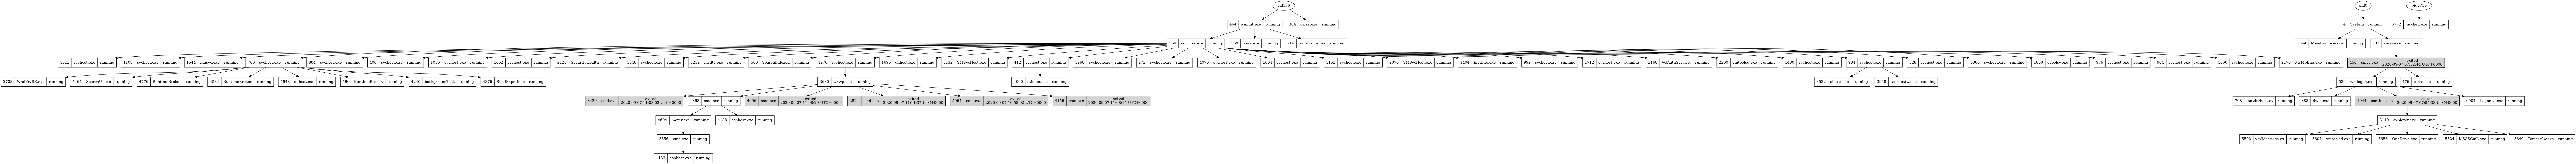

In [44]:
from IPython.display import Image
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile psscan $kdgb
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile psscan --output=dot --output-file=$dump_path/psscan.dot $kdgb
!dot -Tpng $dump_path/psscan.dot -o $dump_path/psscan.png
Image(dump_path + "/psscan.png")

<b>pslist:</b> This walks the doubly-linked list pointed to by PsActiveProcessHead and shows the offset, process name, process ID, the parent process ID, number of threads, number of handles, and date/time when the process started and exited. As of 2.1 it also shows the Session ID and if the process is a Wow64 process (it uses a 32 bit address space on a 64 bit kernel). This plugin does not detect hidden or unlinked processes (but psscan can do that).



Volatility Foundation Volatility Framework 2.6.1
Offset(P)          Name                    PID   PPID   Thds     Hnds   Sess  Wow64 Start                          Exit                          
------------------ -------------------- ------ ------ ------ -------- ------ ------ ------------------------------ ------------------------------
0x000000007e275480 System                    4      0     97        0 ------      0 2020-09-07 07:52:42 UTC+0000                                 
0x00000000076f2040 smss.exe                292      4      2        0 ------      0 2020-09-07 07:52:42 UTC+0000                                 
0x00000000107c23c0 csrss.exe               384    376      9        0      0      0 2020-09-07 07:52:44 UTC+0000                                 
0x0000000078b00080 smss.exe                456    292      0 --------      1      0 2020-09-07 07:52:44 UTC+0000   2020-09-07 07:52:44 UTC+0000  
0x0000000022343080 wininit.exe             464    376      1        0      

0x00000000313755c0 LogonUI.exe            6004    536     10        0      1      0 2020-09-07 08:06:57 UTC+0000                                 
0x00000000536c3080 w3wp.exe               3680   1276     25        0      0      0 2020-09-07 10:58:01 UTC+0000                                 
0x000000001e8845c0 cmd.exe                5964   3680      0 --------      0      0 2020-09-07 10:58:02 UTC+0000   2020-09-07 10:58:02 UTC+0000  
0x000000006338a5c0 cmd.exe                3420   3680      0 --------      0      0 2020-09-07 10:59:00 UTC+0000   2020-09-07 11:08:02 UTC+0000  
0x000000005524a5c0 cmd.exe                4156   3680      0 --------      0      0 2020-09-07 11:08:15 UTC+0000   2020-09-07 11:08:15 UTC+0000  
0x000000002003b5c0 cmd.exe                4696   3680      0 --------      0      0 2020-09-07 11:08:29 UTC+0000   2020-09-07 11:08:29 UTC+0000  
0x0000000016b0a080 cmd.exe                2524   3680      0 --------      0      0 2020-09-07 11:11:37 UTC+0000   2020-09-0

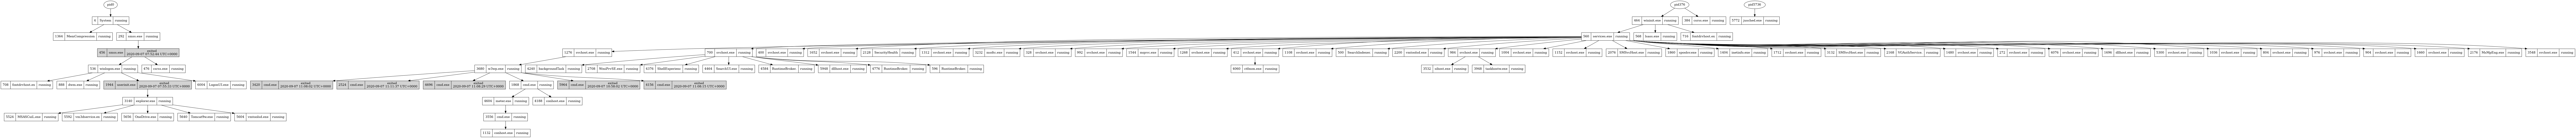

In [45]:
from IPython.display import Image
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile pslist -P $kdgb
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile pslist -P --output=dot --output-file=$dump_path/pslist.dot $kdgb
!dot -Tpng $dump_path/pslist.dot -o $dump_path/pslist.png
Image(dump_path + "/pslist.png")

<b>psxview:</b> Find hidden processes with various process listings.

In [46]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile psxview -P $kdgb

Volatility Foundation Volatility Framework 2.6.1
Offset(P)          Name                    PID pslist psscan thrdproc pspcid csrss session deskthrd ExitTime
------------------ -------------------- ------ ------ ------ -------- ------ ----- ------- -------- --------
0x0000000022345080 wininit.exe             464 True   True   False    True   True  True    False    
0x00000000370815c0 svchost.exe             984 True   True   False    True   True  True    False    
0x0000000006e6e5c0 jusched.exe            5772 True   True   False    True   True  True    False    
0x000000007e2c05c0 svchost.exe            1268 True   True   False    True   True  True    False    
0x0000000026080080 services.exe            560 True   True   False    True   True  True    False    
0x00000000410425c0 svchost.exe            1712 True   True   False    True   True  True    False    
0x0000000008b095c0 RuntimeBroker.         4776 True   True   False    True   True  True    False    
0x0000000076fa35c0 taskhos

<b>envars:</b> Typically this will show the number of CPUs installed and the hardware architecture (though the kdbgscan output is a much more reliable source), the process's current directory, temporary directory, session name, computer name, user name, and various other interesting artifacts.

In [47]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile envars $kdgb

Volatility Foundation Volatility Framework 2.6.1
Pid      Process              Block              Variable                       Value
-------- -------------------- ------------------ ------------------------------ -----
     292 smss.exe             0x000001bdad6027e0 Path                           C:\WINDOWS\System32
     292 smss.exe             0x000001bdad6027e0 SystemDrive                    C:
     292 smss.exe             0x000001bdad6027e0 SystemRoot                     C:\WINDOWS
     384 csrss.exe            0x00000241eb3027e0 ComSpec                        C:\WINDOWS\system32\cmd.exe
     384 csrss.exe            0x00000241eb3027e0 FP_NO_HOST_CHECK               NO
     384 csrss.exe            0x00000241eb3027e0 NUMBER_OF_PROCESSORS           1
     384 csrss.exe            0x00000241eb3027e0 OS                             Windows_NT
     384 csrss.exe            0x00000241eb3027e0 Path                           C:\ProgramData\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WI

     536 winlogon.exe         0x0000026de900f0b0 SystemDrive                    C:
     536 winlogon.exe         0x0000026de900f0b0 SystemRoot                     C:\WINDOWS
     536 winlogon.exe         0x0000026de900f0b0 TEMP                           C:\WINDOWS\TEMP
     536 winlogon.exe         0x0000026de900f0b0 TMP                            C:\WINDOWS\TEMP
     536 winlogon.exe         0x0000026de900f0b0 USERNAME                       SYSTEM
     536 winlogon.exe         0x0000026de900f0b0 USERPROFILE                    C:\WINDOWS\system32\config\systemprofile
     536 winlogon.exe         0x0000026de900f0b0 windir                         C:\WINDOWS
     536 winlogon.exe         0x0000026de900f0b0 windows_tracing_flags          3
     536 winlogon.exe         0x0000026de900f0b0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
     560 services.exe         0x000002e8a54027e0 ALLUSERSPROFILE                C:\ProgramData
     560 services.exe         0x

     700 svchost.exe          0x0000022dc58027e0 ProgramFiles                   C:\Program Files
     700 svchost.exe          0x0000022dc58027e0 ProgramFiles(x86)              C:\Program Files (x86)
     700 svchost.exe          0x0000022dc58027e0 ProgramW6432                   C:\Program Files
     700 svchost.exe          0x0000022dc58027e0 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
     700 svchost.exe          0x0000022dc58027e0 PUBLIC                         C:\Users\Public
     700 svchost.exe          0x0000022dc58027e0 SystemDrive                    C:
     700 svchost.exe          0x0000022dc58027e0 SystemRoot                     C:\WINDOWS
     700 svchost.exe          0x0000022dc58027e0 TEMP                           C:\WINDOWS\TEMP
     700 svchost.exe          0x0000022dc58027e0 TMP                            C:\WINDOWS\TEMP
     700 svchost.exe          0x0000022dc58027e0 USERDOMAIN                     JUPITER
     700 svchost.exe 

     804 svchost.exe          0x00000234aef027e0 Path                           C:\ProgramData\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\ServiceProfiles\NetworkService\AppData\Local\Microsoft\WindowsApps
     804 svchost.exe          0x00000234aef027e0 PATHEXT                        .COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.WSF;.WSH;.MSC
     804 svchost.exe          0x00000234aef027e0 PROCESSOR_ARCHITECTURE         AMD64
     804 svchost.exe          0x00000234aef027e0 PROCESSOR_IDENTIFIER           Intel64 Family 6 Model 58 Stepping 0, GenuineIntel
     804 svchost.exe          0x00000234aef027e0 PROCESSOR_LEVEL                6
     804 svchost.exe          0x00000234aef027e0 PROCESSOR_REVISION             3a00
     804 svchost.exe          0x00000234aef027e0 ProgramData                    C:\ProgramData
     804 svchost.exe          0x00000234aef027e0 ProgramFiles                   C:\Program Fi

     984 svchost.exe          0x000001fd8cd027e0 COMPUTERNAME                   VIRGO
     984 svchost.exe          0x000001fd8cd027e0 ComSpec                        C:\WINDOWS\system32\cmd.exe
     984 svchost.exe          0x000001fd8cd027e0 FP_NO_HOST_CHECK               NO
     984 svchost.exe          0x000001fd8cd027e0 LOCALAPPDATA                   C:\WINDOWS\system32\config\systemprofile\AppData\Local
     984 svchost.exe          0x000001fd8cd027e0 NUMBER_OF_PROCESSORS           1
     984 svchost.exe          0x000001fd8cd027e0 OS                             Windows_NT
     984 svchost.exe          0x000001fd8cd027e0 Path                           C:\ProgramData\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\system32\config\systemprofile\AppData\Local\Microsoft\WindowsApps
     984 svchost.exe          0x000001fd8cd027e0 PATHEXT                        .COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.WS

     272 svchost.exe          0x00000223bc3027e0 ProgramData                    C:\ProgramData
     272 svchost.exe          0x00000223bc3027e0 ProgramFiles                   C:\Program Files
     272 svchost.exe          0x00000223bc3027e0 ProgramFiles(x86)              C:\Program Files (x86)
     272 svchost.exe          0x00000223bc3027e0 ProgramW6432                   C:\Program Files
     272 svchost.exe          0x00000223bc3027e0 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
     272 svchost.exe          0x00000223bc3027e0 PUBLIC                         C:\Users\Public
     272 svchost.exe          0x00000223bc3027e0 SystemDrive                    C:
     272 svchost.exe          0x00000223bc3027e0 SystemRoot                     C:\WINDOWS
     272 svchost.exe          0x00000223bc3027e0 TEMP                           C:\WINDOWS\SERVIC~2\LOCALS~1\AppData\Local\Temp
     272 svchost.exe          0x00000223bc3027e0 TMP                          

     412 svchost.exe          0x000002aa7fa027e0 CommonProgramFiles             C:\Program Files\Common Files
     412 svchost.exe          0x000002aa7fa027e0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
     412 svchost.exe          0x000002aa7fa027e0 CommonProgramW6432             C:\Program Files\Common Files
     412 svchost.exe          0x000002aa7fa027e0 COMPUTERNAME                   VIRGO
     412 svchost.exe          0x000002aa7fa027e0 ComSpec                        C:\WINDOWS\system32\cmd.exe
     412 svchost.exe          0x000002aa7fa027e0 FP_NO_HOST_CHECK               NO
     412 svchost.exe          0x000002aa7fa027e0 LOCALAPPDATA                   C:\WINDOWS\system32\config\systemprofile\AppData\Local
     412 svchost.exe          0x000002aa7fa027e0 NUMBER_OF_PROCESSORS           1
     412 svchost.exe          0x000002aa7fa027e0 OS                             Windows_NT
     412 svchost.exe          0x000002aa7fa027e0 Path                          

    1268 svchost.exe          0x000002d10b0027e0 PROCESSOR_ARCHITECTURE         AMD64
    1268 svchost.exe          0x000002d10b0027e0 PROCESSOR_IDENTIFIER           Intel64 Family 6 Model 58 Stepping 0, GenuineIntel
    1268 svchost.exe          0x000002d10b0027e0 PROCESSOR_LEVEL                6
    1268 svchost.exe          0x000002d10b0027e0 PROCESSOR_REVISION             3a00
    1268 svchost.exe          0x000002d10b0027e0 ProgramData                    C:\ProgramData
    1268 svchost.exe          0x000002d10b0027e0 ProgramFiles                   C:\Program Files
    1268 svchost.exe          0x000002d10b0027e0 ProgramFiles(x86)              C:\Program Files (x86)
    1268 svchost.exe          0x000002d10b0027e0 ProgramW6432                   C:\Program Files
    1268 svchost.exe          0x000002d10b0027e0 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
    1268 svchost.exe          0x000002d10b0027e0 PUBLIC                         C:\Users\Pub

    1652 svchost.exe          0x000001f40a4027e0 TMP                            C:\WINDOWS\SERVIC~2\LOCALS~1\AppData\Local\Temp
    1652 svchost.exe          0x000001f40a4027e0 USERDOMAIN                     NT AUTHORITY
    1652 svchost.exe          0x000001f40a4027e0 USERNAME                       LOCAL SERVICE
    1652 svchost.exe          0x000001f40a4027e0 USERPROFILE                    C:\WINDOWS\ServiceProfiles\LocalService
    1652 svchost.exe          0x000001f40a4027e0 windir                         C:\WINDOWS
    1652 svchost.exe          0x000001f40a4027e0 windows_tracing_flags          3
    1652 svchost.exe          0x000001f40a4027e0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    1660 svchost.exe          0x00000207ab8027e0 ALLUSERSPROFILE                C:\ProgramData
    1660 svchost.exe          0x00000207ab8027e0 APPDATA                        C:\WINDOWS\ServiceProfiles\LocalService\AppData\Roaming
    1660 svchost.exe          0x000

    1860 spoolsv.exe          0x0000000002b00fc0 CommonProgramFiles             C:\Program Files\Common Files
    1860 spoolsv.exe          0x0000000002b00fc0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    1860 spoolsv.exe          0x0000000002b00fc0 CommonProgramW6432             C:\Program Files\Common Files
    1860 spoolsv.exe          0x0000000002b00fc0 COMPUTERNAME                   VIRGO
    1860 spoolsv.exe          0x0000000002b00fc0 ComSpec                        C:\WINDOWS\system32\cmd.exe
    1860 spoolsv.exe          0x0000000002b00fc0 FP_NO_HOST_CHECK               NO
    1860 spoolsv.exe          0x0000000002b00fc0 LOCALAPPDATA                   C:\WINDOWS\system32\config\systemprofile\AppData\Local
    1860 spoolsv.exe          0x0000000002b00fc0 NUMBER_OF_PROCESSORS           1
    1860 spoolsv.exe          0x0000000002b00fc0 OS                             Windows_NT
    1860 spoolsv.exe          0x0000000002b00fc0 Path                          

    1152 svchost.exe          0x00000207c2c35010 PROCESSOR_IDENTIFIER           Intel64 Family 6 Model 58 Stepping 0, GenuineIntel
    1152 svchost.exe          0x00000207c2c35010 PROCESSOR_LEVEL                6
    1152 svchost.exe          0x00000207c2c35010 PROCESSOR_REVISION             3a00
    1152 svchost.exe          0x00000207c2c35010 ProgramData                    C:\ProgramData
    1152 svchost.exe          0x00000207c2c35010 ProgramFiles                   C:\Program Files
    1152 svchost.exe          0x00000207c2c35010 ProgramFiles(x86)              C:\Program Files (x86)
    1152 svchost.exe          0x00000207c2c35010 ProgramW6432                   C:\Program Files
    1152 svchost.exe          0x00000207c2c35010 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
    1152 svchost.exe          0x00000207c2c35010 PUBLIC                         C:\Users\Public
    1152 svchost.exe          0x00000207c2c35010 SystemDrive                    C:

    1404 inetinfo.exe         0x00000170f1fd0fc0 TMP                            C:\WINDOWS\TEMP
    1404 inetinfo.exe         0x00000170f1fd0fc0 USERDOMAIN                     JUPITER
    1404 inetinfo.exe         0x00000170f1fd0fc0 USERNAME                       VIRGO$
    1404 inetinfo.exe         0x00000170f1fd0fc0 USERPROFILE                    C:\WINDOWS\system32\config\systemprofile
    1404 inetinfo.exe         0x00000170f1fd0fc0 windir                         C:\WINDOWS
    1404 inetinfo.exe         0x00000170f1fd0fc0 windows_tracing_flags          3
    1404 inetinfo.exe         0x00000170f1fd0fc0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    1544 mqsvc.exe            0x0000021545890fc0 ALLUSERSPROFILE                C:\ProgramData
    1544 mqsvc.exe            0x0000021545890fc0 APPDATA                        C:\WINDOWS\ServiceProfiles\NetworkService\AppData\Roaming
    1544 mqsvc.exe            0x0000021545890fc0 CommonProgramFiles         

    2076 SMSvcHost.exe        0x0000024fe9d00fc0 PROCESSOR_LEVEL                6
    2076 SMSvcHost.exe        0x0000024fe9d00fc0 PROCESSOR_REVISION             3a00
    2076 SMSvcHost.exe        0x0000024fe9d00fc0 ProgramData                    C:\ProgramData
    2076 SMSvcHost.exe        0x0000024fe9d00fc0 ProgramFiles                   C:\Program Files
    2076 SMSvcHost.exe        0x0000024fe9d00fc0 ProgramFiles(x86)              C:\Program Files (x86)
    2076 SMSvcHost.exe        0x0000024fe9d00fc0 ProgramW6432                   C:\Program Files
    2076 SMSvcHost.exe        0x0000024fe9d00fc0 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
    2076 SMSvcHost.exe        0x0000024fe9d00fc0 PUBLIC                         C:\Users\Public
    2076 SMSvcHost.exe        0x0000024fe9d00fc0 SystemDrive                    C:
    2076 SMSvcHost.exe        0x0000024fe9d00fc0 SystemRoot                     C:\WINDOWS
    2076 SMSvcHost.exe        0x0000024

    2176 MsMpEng.exe          0x000001a822350df0 CommonProgramFiles             C:\Program Files\Common Files
    2176 MsMpEng.exe          0x000001a822350df0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    2176 MsMpEng.exe          0x000001a822350df0 CommonProgramW6432             C:\Program Files\Common Files
    2176 MsMpEng.exe          0x000001a822350df0 COMPUTERNAME                   VIRGO
    2176 MsMpEng.exe          0x000001a822350df0 ComSpec                        C:\WINDOWS\system32\cmd.exe
    2176 MsMpEng.exe          0x000001a822350df0 FP_NO_HOST_CHECK               NO
    2176 MsMpEng.exe          0x000001a822350df0 LOCALAPPDATA                   C:\WINDOWS\system32\config\systemprofile\AppData\Local
    2176 MsMpEng.exe          0x000001a822350df0 NUMBER_OF_PROCESSORS           1
    2176 MsMpEng.exe          0x000001a822350df0 OS                             Windows_NT
    2176 MsMpEng.exe          0x000001a822350df0 Path                          

    2708 WmiPrvSE.exe         0x000002255f300fc0 PATHEXT                        .COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.WSF;.WSH;.MSC
    2708 WmiPrvSE.exe         0x000002255f300fc0 PROCESSOR_ARCHITECTURE         AMD64
    2708 WmiPrvSE.exe         0x000002255f300fc0 PROCESSOR_IDENTIFIER           Intel64 Family 6 Model 58 Stepping 0, GenuineIntel
    2708 WmiPrvSE.exe         0x000002255f300fc0 PROCESSOR_LEVEL                6
    2708 WmiPrvSE.exe         0x000002255f300fc0 PROCESSOR_REVISION             3a00
    2708 WmiPrvSE.exe         0x000002255f300fc0 ProgramData                    C:\ProgramData
    2708 WmiPrvSE.exe         0x000002255f300fc0 ProgramFiles                   C:\Program Files
    2708 WmiPrvSE.exe         0x000002255f300fc0 ProgramFiles(x86)              C:\Program Files (x86)
    2708 WmiPrvSE.exe         0x000002255f300fc0 ProgramW6432                   C:\Program Files
    2708 WmiPrvSE.exe         0x000002255f300fc0 PSModulePath                   C:\WINDOWS

    3232 msdtc.exe            0x000001f495790fc0 ALLUSERSPROFILE                C:\ProgramData
    3232 msdtc.exe            0x000001f495790fc0 APPDATA                        C:\WINDOWS\ServiceProfiles\NetworkService\AppData\Roaming
    3232 msdtc.exe            0x000001f495790fc0 CommonProgramFiles             C:\Program Files\Common Files
    3232 msdtc.exe            0x000001f495790fc0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    3232 msdtc.exe            0x000001f495790fc0 CommonProgramW6432             C:\Program Files\Common Files
    3232 msdtc.exe            0x000001f495790fc0 COMPUTERNAME                   VIRGO
    3232 msdtc.exe            0x000001f495790fc0 ComSpec                        C:\WINDOWS\system32\cmd.exe
    3232 msdtc.exe            0x000001f495790fc0 FP_NO_HOST_CHECK               NO
    3232 msdtc.exe            0x000001f495790fc0 LOCALAPPDATA                   C:\WINDOWS\ServiceProfiles\NetworkService\AppData\Local
    3232 msdtc.exe

     500 SearchIndexer.       0x00000241bd36c680 PROCESSOR_REVISION             3a00
     500 SearchIndexer.       0x00000241bd36c680 ProgramData                    C:\ProgramData
     500 SearchIndexer.       0x00000241bd36c680 ProgramFiles                   C:\Program Files
     500 SearchIndexer.       0x00000241bd36c680 ProgramFiles(x86)              C:\Program Files (x86)
     500 SearchIndexer.       0x00000241bd36c680 ProgramW6432                   C:\Program Files
     500 SearchIndexer.       0x00000241bd36c680 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
     500 SearchIndexer.       0x00000241bd36c680 PUBLIC                         C:\Users\Public
     500 SearchIndexer.       0x00000241bd36c680 SystemDrive                    C:
     500 SearchIndexer.       0x00000241bd36c680 SystemRoot                     C:\WINDOWS
     500 SearchIndexer.       0x00000241bd36c680 TEMP                           C:\ProgramData\Microsoft\Search\Data\Temp

    3532 sihost.exe           0x000001af36f70fc0 ALLUSERSPROFILE                C:\ProgramData
    3532 sihost.exe           0x000001af36f70fc0 APPDATA                        C:\Users\Administrador\AppData\Roaming
    3532 sihost.exe           0x000001af36f70fc0 CommonProgramFiles             C:\Program Files\Common Files
    3532 sihost.exe           0x000001af36f70fc0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    3532 sihost.exe           0x000001af36f70fc0 CommonProgramW6432             C:\Program Files\Common Files
    3532 sihost.exe           0x000001af36f70fc0 COMPUTERNAME                   VIRGO
    3532 sihost.exe           0x000001af36f70fc0 ComSpec                        C:\WINDOWS\system32\cmd.exe
    3532 sihost.exe           0x000001af36f70fc0 FP_NO_HOST_CHECK               NO
    3532 sihost.exe           0x000001af36f70fc0 HOMEDRIVE                      C:
    3532 sihost.exe           0x000001af36f70fc0 HOMEPATH                       \Users\Adm

    4060 ctfmon.exe           0x0000025d04830fc0 APPDATA                        C:\Users\Administrador\AppData\Roaming
    4060 ctfmon.exe           0x0000025d04830fc0 CommonProgramFiles             C:\Program Files\Common Files
    4060 ctfmon.exe           0x0000025d04830fc0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    4060 ctfmon.exe           0x0000025d04830fc0 CommonProgramW6432             C:\Program Files\Common Files
    4060 ctfmon.exe           0x0000025d04830fc0 COMPUTERNAME                   VIRGO
    4060 ctfmon.exe           0x0000025d04830fc0 ComSpec                        C:\WINDOWS\system32\cmd.exe
    4060 ctfmon.exe           0x0000025d04830fc0 FP_NO_HOST_CHECK               NO
    4060 ctfmon.exe           0x0000025d04830fc0 HOMEDRIVE                      C:
    4060 ctfmon.exe           0x0000025d04830fc0 HOMEPATH                       \Users\Administrador
    4060 ctfmon.exe           0x0000025d04830fc0 LOCALAPPDATA                   C:\U

    4376 ShellExperienc       0x000001781aa027e0 OS                             Windows_NT
    4376 ShellExperienc       0x000001781aa027e0 Path                           C:\ProgramData\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\Users\Administrador\AppData\Local\Microsoft\WindowsApps
    4376 ShellExperienc       0x000001781aa027e0 PATHEXT                        .COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.WSF;.WSH;.MSC
    4376 ShellExperienc       0x000001781aa027e0 PROCESSOR_ARCHITECTURE         AMD64
    4376 ShellExperienc       0x000001781aa027e0 PROCESSOR_IDENTIFIER           Intel64 Family 6 Model 58 Stepping 0, GenuineIntel
    4376 ShellExperienc       0x000001781aa027e0 PROCESSOR_LEVEL                6
    4376 ShellExperienc       0x000001781aa027e0 PROCESSOR_REVISION             3a00
    4376 ShellExperienc       0x000001781aa027e0 ProgramData                    C:\ProgramData
    4376 ShellExperie

    4584 RuntimeBroker.       0x000001fc5f6027e0 PROCESSOR_LEVEL                6
    4584 RuntimeBroker.       0x000001fc5f6027e0 PROCESSOR_REVISION             3a00
    4584 RuntimeBroker.       0x000001fc5f6027e0 ProgramData                    C:\ProgramData
    4584 RuntimeBroker.       0x000001fc5f6027e0 ProgramFiles                   C:\Program Files
    4584 RuntimeBroker.       0x000001fc5f6027e0 ProgramFiles(x86)              C:\Program Files (x86)
    4584 RuntimeBroker.       0x000001fc5f6027e0 ProgramW6432                   C:\Program Files
    4584 RuntimeBroker.       0x000001fc5f6027e0 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
    4584 RuntimeBroker.       0x000001fc5f6027e0 PUBLIC                         C:\Users\Public
    4584 RuntimeBroker.       0x000001fc5f6027e0 SystemDrive                    C:
    4584 RuntimeBroker.       0x000001fc5f6027e0 SystemRoot                     C:\WINDOWS
    4584 RuntimeBroker.       0x000001f

     596 RuntimeBroker.       0x000001fa5b2027e0 ProgramW6432                   C:\Program Files
     596 RuntimeBroker.       0x000001fa5b2027e0 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
     596 RuntimeBroker.       0x000001fa5b2027e0 PUBLIC                         C:\Users\Public
     596 RuntimeBroker.       0x000001fa5b2027e0 SystemDrive                    C:
     596 RuntimeBroker.       0x000001fa5b2027e0 SystemRoot                     C:\WINDOWS
     596 RuntimeBroker.       0x000001fa5b2027e0 TEMP                           C:\Users\ADMINI~1\AppData\Local\Temp
     596 RuntimeBroker.       0x000001fa5b2027e0 TMP                            C:\Users\ADMINI~1\AppData\Local\Temp
     596 RuntimeBroker.       0x000001fa5b2027e0 USERDOMAIN                     VIRGO
     596 RuntimeBroker.       0x000001fa5b2027e0 USERDOMAIN_ROAMINGPROFILE      VIRGO
     596 RuntimeBroker.       0x000001fa5b2027e0 USERNAME                       Administrador
 

    5592 vm3dservice.ex       0x0000028bdc660fc0 TMP                            C:\Users\ADMINI~1\AppData\Local\Temp
    5592 vm3dservice.ex       0x0000028bdc660fc0 USERDOMAIN                     VIRGO
    5592 vm3dservice.ex       0x0000028bdc660fc0 USERDOMAIN_ROAMINGPROFILE      VIRGO
    5592 vm3dservice.ex       0x0000028bdc660fc0 USERNAME                       Administrador
    5592 vm3dservice.ex       0x0000028bdc660fc0 USERPROFILE                    C:\Users\Administrador
    5592 vm3dservice.ex       0x0000028bdc660fc0 windir                         C:\WINDOWS
    5592 vm3dservice.ex       0x0000028bdc660fc0 windows_tracing_flags          3
    5592 vm3dservice.ex       0x0000028bdc660fc0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    5604 vmtoolsd.exe         0x000001e875120fc0 ALLUSERSPROFILE                C:\ProgramData
    5604 vmtoolsd.exe         0x000001e875120fc0 APPDATA                        C:\Users\Administrador\AppData\Roaming
 

    5640 Tomcat9w.exe         0x00000000024f0fc0 USERNAME                       Administrador
    5640 Tomcat9w.exe         0x00000000024f0fc0 USERPROFILE                    C:\Users\Administrador
    5640 Tomcat9w.exe         0x00000000024f0fc0 windir                         C:\WINDOWS
    5640 Tomcat9w.exe         0x00000000024f0fc0 windows_tracing_flags          3
    5640 Tomcat9w.exe         0x00000000024f0fc0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    5656 OneDrive.exe         0x00000000072f0fc0 ALLUSERSPROFILE                C:\ProgramData
    5656 OneDrive.exe         0x00000000072f0fc0 APPDATA                        C:\Users\Administrador\AppData\Roaming
    5656 OneDrive.exe         0x00000000072f0fc0 CommonProgramFiles             C:\Program Files\Common Files
    5656 OneDrive.exe         0x00000000072f0fc0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    5656 OneDrive.exe         0x00000000072f0fc0 CommonProgramW6

    5772 jusched.exe          0x0000000002ef0fc0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    5948 dllhost.exe          0x00000226c2250fc0 ALLUSERSPROFILE                C:\ProgramData
    5948 dllhost.exe          0x00000226c2250fc0 APPDATA                        C:\Users\Administrador\AppData\Roaming
    5948 dllhost.exe          0x00000226c2250fc0 CommonProgramFiles             C:\Program Files\Common Files
    5948 dllhost.exe          0x00000226c2250fc0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    5948 dllhost.exe          0x00000226c2250fc0 CommonProgramW6432             C:\Program Files\Common Files
    5948 dllhost.exe          0x00000226c2250fc0 COMPUTERNAME                   VIRGO
    5948 dllhost.exe          0x00000226c2250fc0 ComSpec                        C:\WINDOWS\system32\cmd.exe
    5948 dllhost.exe          0x00000226c2250fc0 FP_NO_HOST_CHECK               NO
    5948 dllhost.exe          0x00000226c2250fc

    6004 LogonUI.exe          0x0000018bd8d60fc0 PROCESSOR_REVISION             3a00
    6004 LogonUI.exe          0x0000018bd8d60fc0 ProgramData                    C:\ProgramData
    6004 LogonUI.exe          0x0000018bd8d60fc0 ProgramFiles                   C:\Program Files
    6004 LogonUI.exe          0x0000018bd8d60fc0 ProgramFiles(x86)              C:\Program Files (x86)
    6004 LogonUI.exe          0x0000018bd8d60fc0 ProgramW6432                   C:\Program Files
    6004 LogonUI.exe          0x0000018bd8d60fc0 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
    6004 LogonUI.exe          0x0000018bd8d60fc0 PUBLIC                         C:\Users\Public
    6004 LogonUI.exe          0x0000018bd8d60fc0 SystemDrive                    C:
    6004 LogonUI.exe          0x0000018bd8d60fc0 SystemRoot                     C:\WINDOWS
    6004 LogonUI.exe          0x0000018bd8d60fc0 TEMP                           C:\WINDOWS\TEMP
    6004 LogonUI.exe     

    1868 cmd.exe              0x000001c05c5493e0 TMP                            C:\WINDOWS\TEMP
    1868 cmd.exe              0x000001c05c5493e0 USERDOMAIN                     JUPITER
    1868 cmd.exe              0x000001c05c5493e0 USERNAME                       VIRGO$
    1868 cmd.exe              0x000001c05c5493e0 USERPROFILE                    C:\WINDOWS\system32\config\systemprofile
    1868 cmd.exe              0x000001c05c5493e0 windir                         C:\WINDOWS
    1868 cmd.exe              0x000001c05c5493e0 windows_tracing_flags          3
    1868 cmd.exe              0x000001c05c5493e0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    4188 conhost.exe          0x0000022559250fc0 ALLUSERSPROFILE                C:\ProgramData
    4188 conhost.exe          0x0000022559250fc0 APPDATA                        C:\WINDOWS\system32\config\systemprofile\AppData\Roaming
    4188 conhost.exe          0x0000022559250fc0 APP_POOL_CONFIG             

    4604 meter.exe            0x0000000002500fc0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    5300 svchost.exe          0x00000289b4c027e0 ALLUSERSPROFILE                C:\ProgramData
    5300 svchost.exe          0x00000289b4c027e0 APPDATA                        C:\WINDOWS\system32\config\systemprofile\AppData\Roaming
    5300 svchost.exe          0x00000289b4c027e0 CommonProgramFiles             C:\Program Files\Common Files
    5300 svchost.exe          0x00000289b4c027e0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    5300 svchost.exe          0x00000289b4c027e0 CommonProgramW6432             C:\Program Files\Common Files
    5300 svchost.exe          0x00000289b4c027e0 COMPUTERNAME                   VIRGO
    5300 svchost.exe          0x00000289b4c027e0 ComSpec                        C:\WINDOWS\system32\cmd.exe
    5300 svchost.exe          0x00000289b4c027e0 FP_NO_HOST_CHECK               NO
    5300 svchost.exe         

    1132 conhost.exe          0x0000017c6f9c0fc0 USERPROFILE                    C:\WINDOWS\system32\config\systemprofile
    1132 conhost.exe          0x0000017c6f9c0fc0 windir                         C:\WINDOWS
    1132 conhost.exe          0x0000017c6f9c0fc0 windows_tracing_flags          3
    1132 conhost.exe          0x0000017c6f9c0fc0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    4240 backgroundTask       0x00000177139027e0 ALLUSERSPROFILE                C:\ProgramData
    4240 backgroundTask       0x00000177139027e0 APPDATA                        C:\Users\Administrador\AppData\Roaming
    4240 backgroundTask       0x00000177139027e0 CommonProgramFiles             C:\Program Files\Common Files
    4240 backgroundTask       0x00000177139027e0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    4240 backgroundTask       0x00000177139027e0 CommonProgramW6432             C:\Program Files\Common Files
    4240 backgroundTask       

<b>envars:</b> Find binaries loaded from temporary directories.

In [48]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile envars PID $kdgb | grep -i "TEMP\|\|TMP"

Volatility Foundation Volatility Framework 2.6.1
Pid      Process              Block              Variable                       Value
-------- -------------------- ------------------ ------------------------------ -----
     292 smss.exe             0x000001bdad6027e0 Path                           C:\WINDOWS\System32
     292 smss.exe             0x000001bdad6027e0 SystemDrive                    C:
     292 smss.exe             0x000001bdad6027e0 SystemRoot                     C:\WINDOWS
     384 csrss.exe            0x00000241eb3027e0 ComSpec                        C:\WINDOWS\system32\cmd.exe
     384 csrss.exe            0x00000241eb3027e0 FP_NO_HOST_CHECK               NO
     384 csrss.exe            0x00000241eb3027e0 NUMBER_OF_PROCESSORS           1
     384 csrss.exe            0x00000241eb3027e0 OS                             Windows_NT
     384 csrss.exe            0x00000241eb3027e0 Path                           C:\ProgramData\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WI

     560 services.exe         0x000002e8a54027e0 ProgramData                    C:\ProgramData
     560 services.exe         0x000002e8a54027e0 ProgramFiles                   C:\Program Files
     560 services.exe         0x000002e8a54027e0 ProgramFiles(x86)              C:\Program Files (x86)
     560 services.exe         0x000002e8a54027e0 ProgramW6432                   C:\Program Files
     560 services.exe         0x000002e8a54027e0 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
     560 services.exe         0x000002e8a54027e0 PUBLIC                         C:\Users\Public
     560 services.exe         0x000002e8a54027e0 SystemDrive                    C:
     560 services.exe         0x000002e8a54027e0 SystemRoot                     C:\WINDOWS
     560 services.exe         0x000002e8a54027e0 TEMP                           C:\WINDOWS\TEMP
     560 services.exe         0x000002e8a54027e0 TMP                            C:\WINDOWS\TEMP
     560 servi

     708 fontdrvhost.ex       0x000002c1bb5e0fc0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
     708 fontdrvhost.ex       0x000002c1bb5e0fc0 CommonProgramW6432             C:\Program Files\Common Files
     708 fontdrvhost.ex       0x000002c1bb5e0fc0 COMPUTERNAME                   VIRGO
     708 fontdrvhost.ex       0x000002c1bb5e0fc0 ComSpec                        C:\WINDOWS\system32\cmd.exe
     708 fontdrvhost.ex       0x000002c1bb5e0fc0 FP_NO_HOST_CHECK               NO
     708 fontdrvhost.ex       0x000002c1bb5e0fc0 LOCALAPPDATA                   %TEMP%\Packages\microsoft.windows.fontdrvhost\AC
     708 fontdrvhost.ex       0x000002c1bb5e0fc0 NUMBER_OF_PROCESSORS           1
     708 fontdrvhost.ex       0x000002c1bb5e0fc0 OS                             Windows_NT
     708 fontdrvhost.ex       0x000002c1bb5e0fc0 Path                           C:\ProgramData\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\Win

     888 dwm.exe              0x0000021f08f10fc0 ProgramW6432                   C:\Program Files
     888 dwm.exe              0x0000021f08f10fc0 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
     888 dwm.exe              0x0000021f08f10fc0 PUBLIC                         C:\Users\Public
     888 dwm.exe              0x0000021f08f10fc0 SystemDrive                    C:
     888 dwm.exe              0x0000021f08f10fc0 SystemRoot                     C:\WINDOWS
     888 dwm.exe              0x0000021f08f10fc0 TEMP                           C:\WINDOWS\TEMP
     888 dwm.exe              0x0000021f08f10fc0 TMP                            C:\WINDOWS\TEMP
     888 dwm.exe              0x0000021f08f10fc0 USERNAME                       SYSTEM
     888 dwm.exe              0x0000021f08f10fc0 USERPROFILE                    C:\WINDOWS\system32\config\systemprofile
     888 dwm.exe              0x0000021f08f10fc0 windir                         C:\WINDOWS
     888 d

     272 svchost.exe          0x00000223bc3027e0 CommonProgramFiles             C:\Program Files\Common Files
     272 svchost.exe          0x00000223bc3027e0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
     272 svchost.exe          0x00000223bc3027e0 CommonProgramW6432             C:\Program Files\Common Files
     272 svchost.exe          0x00000223bc3027e0 COMPUTERNAME                   VIRGO
     272 svchost.exe          0x00000223bc3027e0 ComSpec                        C:\WINDOWS\system32\cmd.exe
     272 svchost.exe          0x00000223bc3027e0 FP_NO_HOST_CHECK               NO
     272 svchost.exe          0x00000223bc3027e0 LOCALAPPDATA                   C:\WINDOWS\ServiceProfiles\LocalService\AppData\Local
     272 svchost.exe          0x00000223bc3027e0 NUMBER_OF_PROCESSORS           1
     272 svchost.exe          0x00000223bc3027e0 OS                             Windows_NT
     272 svchost.exe          0x00000223bc3027e0 Path                           

     412 svchost.exe          0x000002aa7fa027e0 PROCESSOR_IDENTIFIER           Intel64 Family 6 Model 58 Stepping 0, GenuineIntel
     412 svchost.exe          0x000002aa7fa027e0 PROCESSOR_LEVEL                6
     412 svchost.exe          0x000002aa7fa027e0 PROCESSOR_REVISION             3a00
     412 svchost.exe          0x000002aa7fa027e0 ProgramData                    C:\ProgramData
     412 svchost.exe          0x000002aa7fa027e0 ProgramFiles                   C:\Program Files
     412 svchost.exe          0x000002aa7fa027e0 ProgramFiles(x86)              C:\Program Files (x86)
     412 svchost.exe          0x000002aa7fa027e0 ProgramW6432                   C:\Program Files
     412 svchost.exe          0x000002aa7fa027e0 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
     412 svchost.exe          0x000002aa7fa027e0 PUBLIC                         C:\Users\Public
     412 svchost.exe          0x000002aa7fa027e0 SystemDrive                    C:

    1268 svchost.exe          0x000002d10b0027e0 TEMP                           C:\WINDOWS\TEMP
    1268 svchost.exe          0x000002d10b0027e0 TMP                            C:\WINDOWS\TEMP
    1268 svchost.exe          0x000002d10b0027e0 USERDOMAIN                     JUPITER
    1268 svchost.exe          0x000002d10b0027e0 USERNAME                       VIRGO$
    1268 svchost.exe          0x000002d10b0027e0 USERPROFILE                    C:\WINDOWS\system32\config\systemprofile
    1268 svchost.exe          0x000002d10b0027e0 windir                         C:\WINDOWS
    1268 svchost.exe          0x000002d10b0027e0 windows_tracing_flags          3
    1268 svchost.exe          0x000002d10b0027e0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    1480 svchost.exe          0x000001af298027e0 ALLUSERSPROFILE                C:\ProgramData
    1480 svchost.exe          0x000001af298027e0 APPDATA                        C:\WINDOWS\ServiceProfiles\LocalServic

    1712 svchost.exe          0x000001e9fef027e0 ComSpec                        C:\WINDOWS\system32\cmd.exe
    1712 svchost.exe          0x000001e9fef027e0 FP_NO_HOST_CHECK               NO
    1712 svchost.exe          0x000001e9fef027e0 LOCALAPPDATA                   C:\WINDOWS\ServiceProfiles\NetworkService\AppData\Local
    1712 svchost.exe          0x000001e9fef027e0 NUMBER_OF_PROCESSORS           1
    1712 svchost.exe          0x000001e9fef027e0 OS                             Windows_NT
    1712 svchost.exe          0x000001e9fef027e0 Path                           C:\ProgramData\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\ServiceProfiles\NetworkService\AppData\Local\Microsoft\WindowsApps
    1712 svchost.exe          0x000001e9fef027e0 PATHEXT                        .COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.WSF;.WSH;.MSC
    1712 svchost.exe          0x000001e9fef027e0 PROCESSOR_ARCHITECTURE 

    1152 svchost.exe          0x00000207c2c35010 ProgramData                    C:\ProgramData
    1152 svchost.exe          0x00000207c2c35010 ProgramFiles                   C:\Program Files
    1152 svchost.exe          0x00000207c2c35010 ProgramFiles(x86)              C:\Program Files (x86)
    1152 svchost.exe          0x00000207c2c35010 ProgramW6432                   C:\Program Files
    1152 svchost.exe          0x00000207c2c35010 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
    1152 svchost.exe          0x00000207c2c35010 PUBLIC                         C:\Users\Public
    1152 svchost.exe          0x00000207c2c35010 SystemDrive                    C:
    1152 svchost.exe          0x00000207c2c35010 SystemRoot                     C:\WINDOWS
    1152 svchost.exe          0x00000207c2c35010 TEMP                           C:\WINDOWS\TEMP
    1152 svchost.exe          0x00000207c2c35010 TMP                            C:\WINDOWS\TEMP
    1152 svcho

    1276 svchost.exe          0x000001fb63f027e0 ALLUSERSPROFILE                C:\ProgramData
    1276 svchost.exe          0x000001fb63f027e0 APPDATA                        C:\WINDOWS\system32\config\systemprofile\AppData\Roaming
    1276 svchost.exe          0x000001fb63f027e0 CommonProgramFiles             C:\Program Files\Common Files
    1276 svchost.exe          0x000001fb63f027e0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    1276 svchost.exe          0x000001fb63f027e0 CommonProgramW6432             C:\Program Files\Common Files
    1276 svchost.exe          0x000001fb63f027e0 COMPUTERNAME                   VIRGO
    1276 svchost.exe          0x000001fb63f027e0 ComSpec                        C:\WINDOWS\system32\cmd.exe
    1276 svchost.exe          0x000001fb63f027e0 FP_NO_HOST_CHECK               NO
    1276 svchost.exe          0x000001fb63f027e0 LOCALAPPDATA                   C:\WINDOWS\system32\config\systemprofile\AppData\Local
    1276 svchost.exe

    2128 SecurityHealth       0x00000262ea9c4e60 OS                             Windows_NT
    2128 SecurityHealth       0x00000262ea9c4e60 Path                           C:\ProgramData\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\system32\config\systemprofile\AppData\Local\Microsoft\WindowsApps
    2128 SecurityHealth       0x00000262ea9c4e60 PATHEXT                        .COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.WSF;.WSH;.MSC
    2128 SecurityHealth       0x00000262ea9c4e60 PROCESSOR_ARCHITECTURE         AMD64
    2128 SecurityHealth       0x00000262ea9c4e60 PROCESSOR_IDENTIFIER           Intel64 Family 6 Model 58 Stepping 0, GenuineIntel
    2128 SecurityHealth       0x00000262ea9c4e60 PROCESSOR_LEVEL                6
    2128 SecurityHealth       0x00000262ea9c4e60 PROCESSOR_REVISION             3a00
    2128 SecurityHealth       0x00000262ea9c4e60 ProgramData                    C:\ProgramData
   

    2200 vmtoolsd.exe         0x0000021cd5d30fc0 FP_NO_HOST_CHECK               NO
    2200 vmtoolsd.exe         0x0000021cd5d30fc0 LOCALAPPDATA                   C:\WINDOWS\system32\config\systemprofile\AppData\Local
    2200 vmtoolsd.exe         0x0000021cd5d30fc0 NUMBER_OF_PROCESSORS           1
    2200 vmtoolsd.exe         0x0000021cd5d30fc0 OS                             Windows_NT
    2200 vmtoolsd.exe         0x0000021cd5d30fc0 Path                           C:\ProgramData\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\system32\config\systemprofile\AppData\Local\Microsoft\WindowsApps
    2200 vmtoolsd.exe         0x0000021cd5d30fc0 PATHEXT                        .COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.WSF;.WSH;.MSC
    2200 vmtoolsd.exe         0x0000021cd5d30fc0 PROCESSOR_ARCHITECTURE         AMD64
    2200 vmtoolsd.exe         0x0000021cd5d30fc0 PROCESSOR_IDENTIFIER           Intel64 Family 6

    3132 SMSvcHost.exe        0x000002661ee90fc0 COMPUTERNAME                   VIRGO
    3132 SMSvcHost.exe        0x000002661ee90fc0 ComSpec                        C:\WINDOWS\system32\cmd.exe
    3132 SMSvcHost.exe        0x000002661ee90fc0 FP_NO_HOST_CHECK               NO
    3132 SMSvcHost.exe        0x000002661ee90fc0 LOCALAPPDATA                   C:\WINDOWS\ServiceProfiles\NetworkService\AppData\Local
    3132 SMSvcHost.exe        0x000002661ee90fc0 NUMBER_OF_PROCESSORS           1
    3132 SMSvcHost.exe        0x000002661ee90fc0 OS                             Windows_NT
    3132 SMSvcHost.exe        0x000002661ee90fc0 Path                           C:\ProgramData\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\ServiceProfiles\NetworkService\AppData\Local\Microsoft\WindowsApps
    3132 SMSvcHost.exe        0x000002661ee90fc0 PATHEXT                        .COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.

     500 SearchIndexer.       0x00000241bd36c680 ProgramData                    C:\ProgramData
     500 SearchIndexer.       0x00000241bd36c680 ProgramFiles                   C:\Program Files
     500 SearchIndexer.       0x00000241bd36c680 ProgramFiles(x86)              C:\Program Files (x86)
     500 SearchIndexer.       0x00000241bd36c680 ProgramW6432                   C:\Program Files
     500 SearchIndexer.       0x00000241bd36c680 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
     500 SearchIndexer.       0x00000241bd36c680 PUBLIC                         C:\Users\Public
     500 SearchIndexer.       0x00000241bd36c680 SystemDrive                    C:
     500 SearchIndexer.       0x00000241bd36c680 SystemRoot                     C:\WINDOWS
     500 SearchIndexer.       0x00000241bd36c680 TEMP                           C:\ProgramData\Microsoft\Search\Data\Temp\usgthrsvc
     500 SearchIndexer.       0x00000241bd36c680 TMP                      

    3548 svchost.exe          0x0000016724e027e0 SystemRoot                     C:\WINDOWS
    3548 svchost.exe          0x0000016724e027e0 TEMP                           C:\Users\ADMINI~1\AppData\Local\Temp
    3548 svchost.exe          0x0000016724e027e0 TMP                            C:\Users\ADMINI~1\AppData\Local\Temp
    3548 svchost.exe          0x0000016724e027e0 USERDOMAIN                     VIRGO
    3548 svchost.exe          0x0000016724e027e0 USERDOMAIN_ROAMINGPROFILE      VIRGO
    3548 svchost.exe          0x0000016724e027e0 USERNAME                       Administrador
    3548 svchost.exe          0x0000016724e027e0 USERPROFILE                    C:\Users\Administrador
    3548 svchost.exe          0x0000016724e027e0 windir                         C:\WINDOWS
    3548 svchost.exe          0x0000016724e027e0 windows_tracing_flags          3
    3548 svchost.exe          0x0000016724e027e0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    353

    4060 ctfmon.exe           0x0000025d04830fc0 TEMP                           C:\Users\ADMINI~1\AppData\Local\Temp
    4060 ctfmon.exe           0x0000025d04830fc0 TMP                            C:\Users\ADMINI~1\AppData\Local\Temp
    4060 ctfmon.exe           0x0000025d04830fc0 USERDOMAIN                     VIRGO
    4060 ctfmon.exe           0x0000025d04830fc0 USERDOMAIN_ROAMINGPROFILE      VIRGO
    4060 ctfmon.exe           0x0000025d04830fc0 USERNAME                       Administrador
    4060 ctfmon.exe           0x0000025d04830fc0 USERPROFILE                    C:\Users\Administrador
    4060 ctfmon.exe           0x0000025d04830fc0 windir                         C:\WINDOWS
    4060 ctfmon.exe           0x0000025d04830fc0 windows_tracing_flags          3
    4060 ctfmon.exe           0x0000025d04830fc0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    3140 explorer.exe         0x0000000007001740 ALLUSERSPROFILE                C:\ProgramData
   

    4464 SearchUI.exe         0x000001ca3f88d640 SystemDrive                    C:
    4464 SearchUI.exe         0x000001ca3f88d640 SystemRoot                     C:\WINDOWS
    4464 SearchUI.exe         0x000001ca3f88d640 TEMP                           C:\Users\Administrador\AppData\Local\Packages\microsoft.windows.cortana_cw5n1h2txyewy\AC\Temp
    4464 SearchUI.exe         0x000001ca3f88d640 TMP                            C:\Users\Administrador\AppData\Local\Packages\microsoft.windows.cortana_cw5n1h2txyewy\AC\Temp
    4464 SearchUI.exe         0x000001ca3f88d640 USERDOMAIN                     VIRGO
    4464 SearchUI.exe         0x000001ca3f88d640 USERDOMAIN_ROAMINGPROFILE      VIRGO
    4464 SearchUI.exe         0x000001ca3f88d640 USERNAME                       Administrador
    4464 SearchUI.exe         0x000001ca3f88d640 USERPROFILE                    C:\Users\Administrador
    4464 SearchUI.exe         0x000001ca3f88d640 windir                         C:\WINDOWS
    4464 SearchUI.

     596 RuntimeBroker.       0x000001fa5b2027e0 TEMP                           C:\Users\ADMINI~1\AppData\Local\Temp
     596 RuntimeBroker.       0x000001fa5b2027e0 TMP                            C:\Users\ADMINI~1\AppData\Local\Temp
     596 RuntimeBroker.       0x000001fa5b2027e0 USERDOMAIN                     VIRGO
     596 RuntimeBroker.       0x000001fa5b2027e0 USERDOMAIN_ROAMINGPROFILE      VIRGO
     596 RuntimeBroker.       0x000001fa5b2027e0 USERNAME                       Administrador
     596 RuntimeBroker.       0x000001fa5b2027e0 USERPROFILE                    C:\Users\Administrador
     596 RuntimeBroker.       0x000001fa5b2027e0 windir                         C:\WINDOWS
     596 RuntimeBroker.       0x000001fa5b2027e0 windows_tracing_flags          3
     596 RuntimeBroker.       0x000001fa5b2027e0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    5524 MSASCuiL.exe         0x000001fc42770fc0 ALLUSERSPROFILE                C:\ProgramData
   

    5592 vm3dservice.ex       0x0000028bdc660fc0 TMP                            C:\Users\ADMINI~1\AppData\Local\Temp
    5592 vm3dservice.ex       0x0000028bdc660fc0 USERDOMAIN                     VIRGO
    5592 vm3dservice.ex       0x0000028bdc660fc0 USERDOMAIN_ROAMINGPROFILE      VIRGO
    5592 vm3dservice.ex       0x0000028bdc660fc0 USERNAME                       Administrador
    5592 vm3dservice.ex       0x0000028bdc660fc0 USERPROFILE                    C:\Users\Administrador
    5592 vm3dservice.ex       0x0000028bdc660fc0 windir                         C:\WINDOWS
    5592 vm3dservice.ex       0x0000028bdc660fc0 windows_tracing_flags          3
    5592 vm3dservice.ex       0x0000028bdc660fc0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    5604 vmtoolsd.exe         0x000001e875120fc0 ALLUSERSPROFILE                C:\ProgramData
    5604 vmtoolsd.exe         0x000001e875120fc0 APPDATA                        C:\Users\Administrador\AppData\Roaming
 

    5656 OneDrive.exe         0x00000000072f0fc0 TMP                            C:\Users\ADMINI~1\AppData\Local\Temp
    5656 OneDrive.exe         0x00000000072f0fc0 USERDOMAIN                     VIRGO
    5656 OneDrive.exe         0x00000000072f0fc0 USERDOMAIN_ROAMINGPROFILE      VIRGO
    5656 OneDrive.exe         0x00000000072f0fc0 USERNAME                       Administrador
    5656 OneDrive.exe         0x00000000072f0fc0 USERPROFILE                    C:\Users\Administrador
    5656 OneDrive.exe         0x00000000072f0fc0 windir                         C:\WINDOWS
    5656 OneDrive.exe         0x00000000072f0fc0 windows_tracing_flags          3
    5656 OneDrive.exe         0x00000000072f0fc0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    5772 jusched.exe          0x0000000002ef0fc0 ALLUSERSPROFILE                C:\ProgramData
    5772 jusched.exe          0x0000000002ef0fc0 APPDATA                        C:\Users\Administrador\AppData\Roaming
 

     904 svchost.exe          0x000001c65b0027e0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    6004 LogonUI.exe          0x0000018bd8d60fc0 ALLUSERSPROFILE                C:\ProgramData
    6004 LogonUI.exe          0x0000018bd8d60fc0 CommonProgramFiles             C:\Program Files\Common Files
    6004 LogonUI.exe          0x0000018bd8d60fc0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    6004 LogonUI.exe          0x0000018bd8d60fc0 CommonProgramW6432             C:\Program Files\Common Files
    6004 LogonUI.exe          0x0000018bd8d60fc0 COMPUTERNAME                   VIRGO
    6004 LogonUI.exe          0x0000018bd8d60fc0 ComSpec                        C:\WINDOWS\system32\cmd.exe
    6004 LogonUI.exe          0x0000018bd8d60fc0 FP_NO_HOST_CHECK               NO
    6004 LogonUI.exe          0x0000018bd8d60fc0 NUMBER_OF_PROCESSORS           1
    6004 LogonUI.exe          0x0000018bd8d60fc0 OS                             Wind

    1868 cmd.exe              0x000001c05c5493e0 NUMBER_OF_PROCESSORS           1
    1868 cmd.exe              0x000001c05c5493e0 OS                             Windows_NT
    1868 cmd.exe              0x000001c05c5493e0 Path                           C:\ProgramData\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\system32\config\systemprofile\AppData\Local\Microsoft\WindowsApps
    1868 cmd.exe              0x000001c05c5493e0 PATHEXT                        .COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.WSF;.WSH;.MSC
    1868 cmd.exe              0x000001c05c5493e0 PROCESSOR_ARCHITECTURE         AMD64
    1868 cmd.exe              0x000001c05c5493e0 PROCESSOR_IDENTIFIER           Intel64 Family 6 Model 58 Stepping 0, GenuineIntel
    1868 cmd.exe              0x000001c05c5493e0 PROCESSOR_LEVEL                6
    1868 cmd.exe              0x000001c05c5493e0 PROCESSOR_REVISION             3a00
    1868 cmd.exe

    5300 svchost.exe          0x00000289b4c027e0 ProgramData                    C:\ProgramData
    5300 svchost.exe          0x00000289b4c027e0 ProgramFiles                   C:\Program Files
    5300 svchost.exe          0x00000289b4c027e0 ProgramFiles(x86)              C:\Program Files (x86)
    5300 svchost.exe          0x00000289b4c027e0 ProgramW6432                   C:\Program Files
    5300 svchost.exe          0x00000289b4c027e0 PSModulePath                   C:\WINDOWS\system32\WindowsPowerShell\v1.0\Modules\
    5300 svchost.exe          0x00000289b4c027e0 PUBLIC                         C:\Users\Public
    5300 svchost.exe          0x00000289b4c027e0 SystemDrive                    C:
    5300 svchost.exe          0x00000289b4c027e0 SystemRoot                     C:\WINDOWS
    5300 svchost.exe          0x00000289b4c027e0 TEMP                           C:\WINDOWS\TEMP
    5300 svchost.exe          0x00000289b4c027e0 TMP                            C:\WINDOWS\TEMP
    5300 svcho

    1132 conhost.exe          0x0000017c6f9c0fc0 USERPROFILE                    C:\WINDOWS\system32\config\systemprofile
    1132 conhost.exe          0x0000017c6f9c0fc0 windir                         C:\WINDOWS
    1132 conhost.exe          0x0000017c6f9c0fc0 windows_tracing_flags          3
    1132 conhost.exe          0x0000017c6f9c0fc0 windows_tracing_logfile        C:\BVTBin\Tests\installpackage\csilogfile.log
    4240 backgroundTask       0x00000177139027e0 ALLUSERSPROFILE                C:\ProgramData
    4240 backgroundTask       0x00000177139027e0 APPDATA                        C:\Users\Administrador\AppData\Roaming
    4240 backgroundTask       0x00000177139027e0 CommonProgramFiles             C:\Program Files\Common Files
    4240 backgroundTask       0x00000177139027e0 CommonProgramFiles(x86)        C:\Program Files (x86)\Common Files
    4240 backgroundTask       0x00000177139027e0 CommonProgramW6432             C:\Program Files\Common Files
    4240 backgroundTask       

<b>vadtree:</b> The Virtual Address Descriptor tree is used by the Windowsmemory manager to describe memory ranges used by a process as they are allocated. When a process allocatesmemory with VirutalAlloc, the memory manager creates anentry in the VAD tree. The corresponding page directory andpage table entries are not created until the process tries to ref-erence that memory page, which can provide significantmemory savings for processes that allocate a large amountof memory but access it sparsely (Russinovich and Solomon,2004, pp. 448–449). The tree itself is a self-balancing binarytree: at any given node, memory addresses lower than thosecontained at the current node can be found in the left subtreeand higher ranges in the right.

More information on the VAD:

https://www.dfrws.org/sites/default/files/session-files/paper-the_vad_tree_-_a_process-eye_view_of_physical_memory.pdf

Fillcolor Legend:

    Red: Heaps
    Gray: DLLs
    Green: Stacks
    Yellow: Mapped Files

In [49]:
from ipywidgets import widgets
from IPython.display import Image,clear_output

text = widgets.Text(description="ProcessID:", width=200)
display(text)

def handle_submit(sender):
    clear_output()
    display(text)
    processid=text.value
    processidimage=processid + ".png"
    processiddot=processid + ".dot"
    !python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile -p $processid vadtree --output=dot --output-file=$dump_path/$processiddot $kdgb
    !dot -Tpng $dump_path/$processiddot -o $dump_path/$processidimage
    display(Image(filename=dump_path +"/"+ processidimage))
        
text.on_submit(handle_submit)

Text(value='', description='ProcessID:')

<a id='files_information'></a>
### 8. Files Information
[Top](#table_of_contents)

<b>filescan:</b> To find FILE_OBJECTs in physical memory using pool tag scanning, use the filescan command. This will find open files even if a rootkit is hiding the files on disk and if the rootkit hooks some API functions to hide the open handles on a live system. The output shows the physical offset of the FILE_OBJECT, file name, number of pointers to the object, number of handles to the object, and the effective permissions granted to the object.

In [50]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile filescan $kdgb

Volatility Foundation Volatility Framework 2.6.1
Offset(P)            #Ptr   #Hnd Access Name
------------------ ------ ------ ------ ----


<a id='network_information'></a>
### 9. Network Information
[Top](#table_of_contents)

<b>Network shares information:</b>

In [51]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile handles -t File $kdgb | egrep "\\Device\\(LanmanRedirector|Mup)"

Volatility Foundation Volatility Framework 2.6.1


<b>sockscan:</b> To find \_ADDRESS_OBJECT structures using pool tag scanning, use the sockscan command. As with connscan, this can pick up residual data and artifacts from previous sockets.

This command is for x86 and x64 Windows XP and Windows 2003 Server only.

In [52]:
ips_list=[]

sockscan=!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile sockscan $kdgb
for row in sockscan[1:]:
    print(row)
    
for row in sockscan[3:]:
    row=row.split()
    ips_list.append(row[5])

ERROR   : volatility.debug    : This command does not support the profile Win10x64_15063


<b>sockets:</b> To detect listening sockets for any protocol (TCP, UDP, RAW, etc), use the sockets command. This walks a singly-linked list of socket structures which is pointed to by a non-exported symbol in the tcpip.sys module.

This command is for x86 and x64 Windows XP and Windows 2003 Server only.

In [53]:
sockets=!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile sockets $kdgb
for row in sockets[1:]:
    print(row)

for row in sockets[3:]:
    row=row.split()
    ips_list.append(row[5])

ERROR   : volatility.debug    : This command does not support the profile Win10x64_15063


<b>connections:</b> To view TCP connections that were active at the time of the memory acquisition, use the connections command. This walks the singly-linked list of connection structures pointed to by a non-exported symbol in the tcpip.sys module.

This command is for x86 and x64 Windows XP and Windows 2003 Server only.

In [54]:
connections=!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile connections $kdgb

for row in connections[1:]:
    print(row)
    
for row in connections[3:]:
    row=row.split()
    ip_port=row[2]
    ip_port=ip_port.split(':')
    ips_list.append(ip_port[0])

ERROR   : volatility.debug    : This command does not support the profile Win10x64_15063


<b>connscan:</b> To find \_TCPT_OBJECT structures using pool tag scanning, use the connscan command. This can find artifacts from previous connections that have since been terminated, in addition to the active ones. In the output below, you'll notice some fields have been partially overwritten, but some of the information is still accurate. For example, the very last entry's Pid field is 0, but all other fields are still in tact. Thus, while it may find false positives sometimes, you also get the benefit of detecting as much information as possible.

This command is for x86 and x64 Windows XP and Windows 2003 Server only.

In [55]:
connscan=!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile connscan $kdgb

for row in connscan[1:]:
    print(row)
    
for row in connscan[3:]:
    row=row.split()
    ip_port=row[2]
    ip_port=ip_port.split(':')
    ips_list.append(ip_port[0])

ERROR   : volatility.debug    : This command does not support the profile Win10x64_15063


<b>netscan:</b> To scan for network artifacts in 32- and 64-bit Windows Vista, Windows 2008 Server and Windows 7 memory dumps, use the netscan command. This finds TCP endpoints, TCP listeners, UDP endpoints, and UDP listeners. It distinguishes between IPv4 and IPv6, prints the local and remote IP (if applicable), the local and remote port (if applicable), the time when the socket was bound or when the connection was established, and the current state (for TCP connections only). 

In [56]:
netscan=!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile netscan $kdgb
for row in netscan[1:]:
    print(row)
    
for row in netscan[3:]:
    row=row.split()
    ip_port=row[2]
    ip_port=ip_port.split(':')
    ips_list.append(ip_port[0])

Offset(P)          Proto    Local Address                  Foreign Address      State            Pid      Owner          Created
0x930000082b00     UDPv4    0.0.0.0:5355                   *:*                                   1036     svchost.exe    2020-09-07 07:52:47 UTC+0000
0x930000082b00     UDPv6    :::5355                        *:*                                   1036     svchost.exe    2020-09-07 07:52:47 UTC+0000
0x9300000afec0     UDPv4    0.0.0.0:3389                   *:*                                   992      svchost.exe    2020-09-07 07:52:46 UTC+0000
0x9300000b06a0     UDPv4    0.0.0.0:3389                   *:*                                   992      svchost.exe    2020-09-07 07:52:46 UTC+0000
0x9300000b06a0     UDPv6    :::3389                        *:*                                   992      svchost.exe    2020-09-07 07:52:46 UTC+0000
0x9300000b3d30     UDPv4    0.0.0.0:5353                   *:*                                   1036     svchost.exe    

<b>NDISPktScan:</b> An Ethernet packet, or, depending on the version of Windows, the start of an Ethernet packet, can be found by searching kernel memory space for a source MAC address followed by an EtherType of IPv4 or IPv6. As long as the source MAC address is known, the packets can be found and recovered.

Ideally, the source MAC address will be passed to the plugin via the --mac switch.

In [57]:
mac="00:0C:29:47:7A:A1"
!python $base_path/tools/volatility/vol.py --plugins=$plugins_path/AdamBridge -f $case_path/$filename --profile=$profile ndispktscan $kdgb --mac=$mac  --pcap $dump_path/packets2.pcap --dsts $dump_path/ips2.txt
ips2=!cat $dump_path/ips2.txt
#modificar
if "file" in ips2:
    print("Nothing found.")
else:
    for ip in ips2:
        ips_list.append(ip)

Volatility Foundation Volatility Framework 2.6.1
Offset (V)         Source MAC        Destination MAC   Prot Source IP                               Destination IP                          SPort DPort Flags
------------------ ----------------- ----------------- ---- --------------------------------------- --------------------------------------- ----- ----- -----
Found 0 packets from 0 MACs.


<a id='windows_events'></a>
### 10. Windows Event Logs Extraction
[Top](#table_of_contents)

<b>evtlogs:</b> Extract Windows Event Logs (XP/2003 only).

In [58]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile evtlogs --dump-dir=$dump_path $kdgb

Volatility Foundation Volatility Framework 2.6.1
ERROR   : volatility.debug    : This command does not support the profile Win10x64_15063


<b>evtxtract:</b> Extract Windows Event Logs (Vista/7/8/10 only).

In [59]:
!evtxtract $case_path/$filename

/usr/bin/sh: 1: evtxtract: not found


<a id='malicious_code'></a>
### 11. Malicious Code Investigation
[Top](#table_of_contents)

<b>yarascan</b>

In [60]:
#!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile yarascan

<b>malfind:</b> The malfind command helps find hidden or injected code/DLLs in user mode memory, based on characteristics such as VAD tag and page permissions.

In [61]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile malfind $kdgb

Volatility Foundation Volatility Framework 2.6.1
Process: SMSvcHost.exe Pid: 2076 Address: 0x24fea370000
Vad Tag: VadS Protection: PAGE_EXECUTE_READWRITE
Flags: PrivateMemory: 1, Protection: 6

0x24fea370000  00 00 00 00 00 00 00 00 a4 ed 14 c4 ea 3f 00 01   .............?..
0x24fea370010  ee ff ee ff 02 00 00 00 20 01 37 ea 4f 02 00 00   ..........7.O...
0x24fea370020  20 01 37 ea 4f 02 00 00 00 00 37 ea 4f 02 00 00   ..7.O.....7.O...
0x24fea370030  00 00 37 ea 4f 02 00 00 0f 00 00 00 00 00 00 00   ..7.O...........

0xea370000 0000             ADD [EAX], AL
0xea370002 0000             ADD [EAX], AL
0xea370004 0000             ADD [EAX], AL
0xea370006 0000             ADD [EAX], AL
0xea370008 a4               MOVSB
0xea370009 ed               IN EAX, DX
0xea37000a 14c4             ADC AL, 0xc4
0xea37000c ea3f0001eeffee   JMP FAR 0xeeff:0xee01003f
0xea370013 ff02             INC DWORD [EDX]
0xea370015 0000             ADD [EAX], AL
0xea370017 0020             ADD [EAX], AH
0xea370019 01

Process: MsMpEng.exe Pid: 2176 Address: 0x1a832a30000
Vad Tag: VadS Protection: PAGE_EXECUTE_READWRITE
Flags: PrivateMemory: 1, Protection: 6

0x1a832a30000  20 00 00 00 e0 ff 0f 00 0c 00 00 00 01 00 07 00   ................
0x1a832a30010  00 42 00 30 00 70 00 60 00 50 00 c0 00 d0 00 00   .B.0.p.`.P......
0x1a832a30020  08 00 42 00 00 00 00 05 48 8b 45 20 48 89 c2 48   ..B.....H.E.H..H
0x1a832a30030  8b 45 18 48 8b 00 48 89 02 48 8b 45 20 81 00 b8   .E.H..H..H.E....

0x32a30000 2000             AND [EAX], AL
0x32a30002 0000             ADD [EAX], AL
0x32a30004 e0ff             LOOPNZ 0x32a30005
0x32a30006 0f000c00         STR WORD [EAX+EAX]
0x32a3000a 0000             ADD [EAX], AL
0x32a3000c 0100             ADD [EAX], EAX
0x32a3000e 07               POP ES
0x32a3000f 0000             ADD [EAX], AL
0x32a30011 42               INC EDX
0x32a30012 0030             ADD [EAX], DH
0x32a30014 007000           ADD [EAX+0x0], DH
0x32a30017 60               PUSHA
0x32a30018 005000           ADD

Flags: PrivateMemory: 1, Protection: 6

0x26637ba0000  00 00 00 00 00 00 00 00 9e d7 fd cc 28 0c 00 01   ............(...
0x26637ba0010  ee ff ee ff 02 00 00 00 20 01 ba 37 66 02 00 00   ...........7f...
0x26637ba0020  20 01 ba 37 66 02 00 00 00 00 ba 37 66 02 00 00   ...7f......7f...
0x26637ba0030  00 00 ba 37 66 02 00 00 0f 00 00 00 00 00 00 00   ...7f...........

0x37ba0000 0000             ADD [EAX], AL
0x37ba0002 0000             ADD [EAX], AL
0x37ba0004 0000             ADD [EAX], AL
0x37ba0006 0000             ADD [EAX], AL
0x37ba0008 9e               SAHF
0x37ba0009 d7               XLAT BYTE [EBX+AL]
0x37ba000a fd               STD
0x37ba000b cc               INT 3
0x37ba000c 280c00           SUB [EAX+EAX], CL
0x37ba000f 01ee             ADD ESI, EBP
0x37ba0011 ff               DB 0xff
0x37ba0012 ee               OUT DX, AL
0x37ba0013 ff02             INC DWORD [EDX]
0x37ba0015 0000             ADD [EAX], AL
0x37ba0017 0020             ADD [EAX], AH
0x37ba0019 01ba37660200    

Process: w3wp.exe Pid: 3680 Address: 0x24d60b20000
Vad Tag: VadS Protection: PAGE_EXECUTE_READWRITE
Flags: PrivateMemory: 1, Protection: 6

0x24d60b20000  00 00 00 00 00 00 00 00 df 19 1c bc 72 0e 00 01   ............r...
0x24d60b20010  ee ff ee ff 02 00 00 00 20 01 b2 60 4d 02 00 00   ...........`M...
0x24d60b20020  20 01 b2 60 4d 02 00 00 00 00 b2 60 4d 02 00 00   ...`M......`M...
0x24d60b20030  00 00 b2 60 4d 02 00 00 0f 00 00 00 00 00 00 00   ...`M...........

0x60b20000 0000             ADD [EAX], AL
0x60b20002 0000             ADD [EAX], AL
0x60b20004 0000             ADD [EAX], AL
0x60b20006 0000             ADD [EAX], AL
0x60b20008 df19             FISTP WORD [ECX]
0x60b2000a 1cbc             SBB AL, 0xbc
0x60b2000c 720e             JB 0x60b2001c
0x60b2000e 0001             ADD [ECX], AL
0x60b20010 ee               OUT DX, AL
0x60b20011 ff               DB 0xff
0x60b20012 ee               OUT DX, AL
0x60b20013 ff02             INC DWORD [EDX]
0x60b20015 0000             ADD [EA

Process: meter.exe Pid: 4604 Address: 0x2520000
Vad Tag: VadS Protection: PAGE_EXECUTE_READWRITE
Flags: PrivateMemory: 1, Protection: 6

0x02520000  4d 5a e8 00 00 00 00 5b 52 45 55 89 e5 81 c3 75   MZ.....[REU....u
0x02520010  13 00 00 ff d3 81 c3 84 a8 02 00 89 3b 53 6a 04   ............;Sj.
0x02520020  50 ff d0 00 00 00 00 00 00 00 00 00 00 00 00 00   P...............
0x02520030  00 00 00 00 00 00 00 00 00 00 00 00 f8 00 00 00   ................

0x02520000 4d               DEC EBP
0x02520001 5a               POP EDX
0x02520002 e800000000       CALL 0x2520007
0x02520007 5b               POP EBX
0x02520008 52               PUSH EDX
0x02520009 45               INC EBP
0x0252000a 55               PUSH EBP
0x0252000b 89e5             MOV EBP, ESP
0x0252000d 81c375130000     ADD EBX, 0x1375
0x02520013 ffd3             CALL EBX
0x02520015 81c384a80200     ADD EBX, 0x2a884
0x0252001b 893b             MOV [EBX], EDI
0x0252001d 53               PUSH EBX
0x0252001e 6a04             PUSH 0x4
0

<b>ldrmodules:</b> There are many ways to hide a DLL. One of the ways involves unlinking the DLL from one (or all) of the linked lists in the PEB. However, when this is done, there is still information contained within the VAD (Virtual Address Descriptor) which identifies the base address of the DLL and its full path on disk. To cross-reference this information (known as memory mapped files) with the 3 PEB lists, use the ldrmodules command.

For each memory mapped PE file, the ldrmodules command prints True or False if the PE exists in the PEB lists. 

Since the PEB and the DLL lists that it contains all exist in user mode, its also possible for malware to hide (or obscure) a DLL by simply overwriting the path. Tools that only look for unlinked entries may miss the fact that malware could overwrite C:\bad.dll to show C:\windows\system32\kernel32.dll. So you can also pass -v or --verbose to ldrmodules to see the full path of all entries.

For concrete examples, see http://blogs.mcafee.com/mcafee-labs/zeroaccess-misleads-memory-file-link ZeroAccess Misleads Memory-File Link and QuickPost: Flame & Volatility.

In [62]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile ldrmodules $kdgb

Volatility Foundation Volatility Framework 2.6.1
Pid      Process              Base               InLoad InInit InMem MappedPath
-------- -------------------- ------------------ ------ ------ ----- ----------
     292 smss.exe             0x00007ff7abdb0000 True   False  True  \Windows\System32\smss.exe
     384 csrss.exe            0x00007ff754590000 True   False  True  \Windows\System32\csrss.exe
     464 wininit.exe          0x00007ff6d0560000 True   False  True  \Windows\System32\wininit.exe
     476 csrss.exe            0x00007ff754590000 True   False  True  \Windows\System32\csrss.exe
     536 winlogon.exe         0x00007ff7c93c0000 True   False  True  \Windows\System32\winlogon.exe
     536 winlogon.exe         0x00007ffa79420000 True   True   True  \Windows\System32\wkscli.dll
     536 winlogon.exe         0x00007ffa7e340000 True   True   True  \Windows\System32\netutils.dll
     536 winlogon.exe         0x00007ffa7fb20000 True   True   True  \Windows\System32\ucrtbase.dll
    

     992 svchost.exe          0x00007ff608550000 True   False  True  \Windows\System32\svchost.exe
     272 svchost.exe          0x00007ff608550000 True   False  True  \Windows\System32\svchost.exe
     272 svchost.exe          0x00007ffa7ee40000 True   True   True  \Windows\System32\bcryptprimitives.dll
     328 svchost.exe          0x00007ff608550000 True   False  True  \Windows\System32\svchost.exe
     328 svchost.exe          0x00007ffa63390000 True   True   True  \Windows\System32\Windows.StateRepositoryPS.dll
     328 svchost.exe          0x00007ffa7ee40000 True   True   True  \Windows\System32\bcryptprimitives.dll
     328 svchost.exe          0x00007ffa7e840000 True   True   True  \Windows\System32\bcrypt.dll
     328 svchost.exe          0x00007ffa81780000 True   True   True  \Windows\System32\advapi32.dll
     328 svchost.exe          0x00007ffa7ae80000 True   True   True  \Windows\System32\wevtapi.dll
     328 svchost.exe          0x00007ffa7be60000 True   True   True  \Win

    1480 svchost.exe          0x00007ff608550000 True   False  True  \Windows\System32\svchost.exe
    1652 svchost.exe          0x00007ff608550000 True   False  True  \Windows\System32\svchost.exe
    1660 svchost.exe          0x00007ff608550000 True   False  True  \Windows\System32\svchost.exe
    1712 svchost.exe          0x00007ff608550000 True   False  True  \Windows\System32\svchost.exe
    1860 spoolsv.exe          0x00007ff76e940000 True   False  True  \Windows\System32\spoolsv.exe
    1108 svchost.exe          0x00007ff608550000 True   False  True  \Windows\System32\svchost.exe
    1152 svchost.exe          0x00000207c2bd0000 False  False  False \Windows\System32\en-US\winnlsres.dll.mui
    1152 svchost.exe          0x00000207c2bc0000 False  False  False \Windows\System32\winnlsres.dll
    1152 svchost.exe          0x00007ffa7e340000 True   True   True  \Windows\System32\netutils.dll
    1152 svchost.exe          0x00007ffa7b230000 True   True   True  \Windows\System32\WinType

    2176 MsMpEng.exe          0x000001a823120000 False  False  False \Program Files\Windows Defender\MpAsDesc.dll
    2176 MsMpEng.exe          0x00007ffa6ad50000 True   True   True  \ProgramData\Microsoft\Windows Defender\Definition Updates\Default\MpEngine.dll
    2176 MsMpEng.exe          0x00007ffa7e340000 True   True   True  \Windows\System32\netutils.dll
    2176 MsMpEng.exe          0x00007ffa69d30000 True   True   True  \Windows\System32\aepic.dll
    2176 MsMpEng.exe          0x00007ffa5a380000 True   True   True  \Windows\System32\WinSATAPI.dll
    2176 MsMpEng.exe          0x00007ffa82690000 True   True   True  \Windows\System32\combase.dll
    2176 MsMpEng.exe          0x00007ffa81ba0000 True   True   True  \Windows\System32\sechost.dll
    2176 MsMpEng.exe          0x00007ffa81db0000 True   True   True  \Windows\System32\rpcrt4.dll
    2176 MsMpEng.exe          0x00007ffa687c0000 True   True   True  \Windows\System32\wscapi.dll
    2176 MsMpEng.exe          0x00007ffa649d0

    3548 svchost.exe          0x00007ff608550000 True   False  True  \Windows\System32\svchost.exe
    3548 svchost.exe          0x00007ffa610e0000 True   True   True  \Windows\System32\wpnclient.dll
    3548 svchost.exe          0x00007ffa831c0000 True   True   True  \Windows\System32\ntdll.dll
    3548 svchost.exe          0x00007ffa81780000 True   True   True  \Windows\System32\advapi32.dll
    3548 svchost.exe          0x00007ffa81ba0000 True   True   True  \Windows\System32\sechost.dll
    3548 svchost.exe          0x00007ffa81db0000 True   True   True  \Windows\System32\rpcrt4.dll
    3548 svchost.exe          0x00007ffa779f0000 True   True   True  \Windows\System32\StateRepository.Core.dll
    3548 svchost.exe          0x00007ffa7f610000 True   True   True  \Windows\System32\KernelBase.dll
    3548 svchost.exe          0x00007ffa7ee40000 True   True   True  \Windows\System32\bcryptprimitives.dll
    3548 svchost.exe          0x00007ffa82690000 True   True   True  \Windows\System

    4376 ShellExperienc       0x000001781cff0000 False  False  False \Windows\System32\en-US\windows.ui.xaml.dll.mui
    4376 ShellExperienc       0x000001781f4c0000 False  False  False \Windows\System32\netmsg.dll
    4376 ShellExperienc       0x00007ffa53530000 True   True   True  \Windows\System32\mfsrcsnk.dll
    4376 ShellExperienc       0x00007ffa65170000 True   True   True  \Windows\System32\RTWorkQ.dll
    4376 ShellExperienc       0x00007ff6985f0000 True   False  True  \Windows\SystemApps\ShellExperienceHost_cw5n1h2txyewy\ShellExperienceHost.exe
    4376 ShellExperienc       0x00007ffa830e0000 True   True   True  \Windows\System32\kernel32.dll
    4376 ShellExperienc       0x0000017822370000 False  False  False \Windows\System32\en-US\mferror.dll.mui
    4376 ShellExperienc       0x0000017822780000 False  False  False \Windows\System32\mferror.dll
    4376 ShellExperienc       0x00007ffa82690000 True   True   True  \Windows\System32\combase.dll
    4376 ShellExperienc       0x

    6004 LogonUI.exe          0x0000018bd98e0000 False  False  False \Windows\System32\Windows.UI.Xaml.Resources.dll
    6004 LogonUI.exe          0x0000018bdc740000 False  False  False \Windows\System32\Windows.UI.Xaml.Maps.dll
    6004 LogonUI.exe          0x00007ffa69d30000 True   True   True  \Windows\System32\aepic.dll
    6004 LogonUI.exe          0x00007ffa81db0000 True   True   True  \Windows\System32\rpcrt4.dll
    6004 LogonUI.exe          0x00007ffa579d0000 True   True   True  \Windows\System32\LockController.dll
    6004 LogonUI.exe          0x00007ffa7d5f0000 True   True   True  \Windows\System32\dwmapi.dll
    6004 LogonUI.exe          0x00007ffa81780000 True   True   True  \Windows\System32\advapi32.dll
    6004 LogonUI.exe          0x00007ffa7fa50000 True   True   True  \Windows\System32\win32u.dll
    6004 LogonUI.exe          0x00007ffa82060000 True   True   True  \Windows\System32\ole32.dll
    6004 LogonUI.exe          0x00007ffa830e0000 True   True   True  \Windows

    3680 w3wp.exe             0x0000024d5f5b0000 True   True   True  \Windows\System32\inetsrv\iisres.dll
    3680 w3wp.exe             0x0000024d5f5a0000 False  False  False \Windows\System32\inetsrv\en-US\w3wp.exe.mui
    3680 w3wp.exe             0x00007ffa77340000 True   True   True  \Windows\System32\inetsrv\cachtokn.dll
    3680 w3wp.exe             0x00007ffa59b40000 True   True   True  \Windows\assembly\NativeImages_v4.0.30319_64\System.Web.2486c0f5#\abb04379bf1ca1145e28c6eba0e47918\System.Web.DynamicData.ni.dll
    3680 w3wp.exe             0x00007ffa6df60000 True   True   True  \Windows\System32\inetsrv\dirlist.dll
    3680 w3wp.exe             0x00007ffa7e570000 True   True   True  \Windows\System32\mswsock.dll
    3680 w3wp.exe             0x00007ffa81db0000 True   True   True  \Windows\System32\rpcrt4.dll
    3680 w3wp.exe             0x00007ffa563c0000 True   True   True  \Windows\assembly\NativeImages_v4.0.30319_64\System.Web.28b9ef5a#\904f27ea3924f42bb1a05881405812bc\Sy

    3680 w3wp.exe             0x00007ffa68a40000 True   True   True  \Windows\Microsoft.NET\Framework64\v4.0.30319\clrjit.dll
    3680 w3wp.exe             0x00007ffa6e020000 True   True   True  \Windows\assembly\NativeImages_v4.0.30319_64\System.Runteb92aa12#\bbf894e2bc0849837606e4208f627710\System.Runtime.Serialization.ni.dll
    3680 w3wp.exe             0x00007ffa71630000 True   True   True  \Windows\assembly\NativeImages_v4.0.30319_64\System.Core\88dea3dcba1b28955a1a9346e1f346a2\System.Core.ni.dll
    3680 w3wp.exe             0x00007ffa68c40000 True   True   True  \Windows\System32\inetsrv\gzip.dll
    3680 w3wp.exe             0x00007ffa53cc0000 True   True   True  \Windows\assembly\NativeImages_v4.0.30319_64\System.Design\d692cf8d057f85b8fb5fe87ecf3daa33\System.Design.ni.dll
    3680 w3wp.exe             0x00007ffa6def0000 True   True   True  \Windows\System32\inetsrv\logcust.dll
    3680 w3wp.exe             0x00007ffa66730000 True   True   True  \Windows\assembly\NativeImages

    4604 meter.exe            0x00000000733e0000 True   True   True  \Windows\SysWOW64\sspicli.dll
    4604 meter.exe            0x0000000050950000 True   True   True  \Windows\System32\wow64.dll
    4604 meter.exe            0x0000000073190000 True   True   True  \Windows\SysWOW64\netapi32.dll
    4604 meter.exe            0x0000000072b60000 True   True   True  \Windows\SysWOW64\dhcpcsvc.dll
    4604 meter.exe            0x0000000072b80000 True   True   True  \Windows\SysWOW64\bcrypt.dll
    4604 meter.exe            0x0000000072ba0000 True   True   True  \Windows\SysWOW64\rsaenh.dll
    4604 meter.exe            0x00000000509b0000 True   True   True  \Windows\System32\wow64cpu.dll
    4604 meter.exe            0x0000000073bc0000 True   True   True  \Windows\SysWOW64\ole32.dll
    4604 meter.exe            0x00000000739d0000 True   True   True  \Windows\SysWOW64\sechost.dll
    4604 meter.exe            0x00007ffa831c0000 True   True   True  \Windows\System32\ntdll.dll
    4604 meter.

    3556 cmd.exe              0x0000000050950000 True   True   True  \Windows\System32\wow64.dll
    3556 cmd.exe              0x0000000000c80000 True   False  True  \Windows\SysWOW64\cmd.exe
    3556 cmd.exe              0x0000000075290000 True   True   True  \Windows\SysWOW64\KernelBase.dll
    3556 cmd.exe              0x0000000075e00000 True   True   True  \Windows\SysWOW64\kernel32.dll
    3556 cmd.exe              0x000000006e980000 True   True   True  \Windows\SysWOW64\winbrand.dll
    3556 cmd.exe              0x0000000005e90000 False  False  False \Windows\SysWOW64\en-US\KernelBase.dll.mui
    3556 cmd.exe              0x00000000509b0000 True   True   True  \Windows\System32\wow64cpu.dll
    3556 cmd.exe              0x00007ffa831c0000 True   True   True  \Windows\System32\ntdll.dll
    3556 cmd.exe              0x00000000508d0000 True   True   True  \Windows\System32\wow64win.dll
    3556 cmd.exe              0x0000000073b00000 True   True   True  \Windows\SysWOW64\msvcrt.dll

Cobalt strike
https://github.com/RomanEmelyanov/CobaltStrikeForensic

https://blogs.jpcert.or.jp/en/2018/08/volatility-plugin-for-detecting-cobalt-strike-beacon.html

<a id='advanced_extract_files'></a>
### 12. Advanced Investigation - Extracting Files
[Top](#table_of_contents)

<b>dumpfiles</b>

In [63]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile --dump-dir=$dump_path dumpfiles $kdgb

Volatility Foundation Volatility Framework 2.6.1
DataSectionObject 0xffffa98663d54920   4      None
DataSectionObject 0xffffa98662692810   4      None
DataSectionObject 0xffffa98662692740   4      None
DataSectionObject 0xffffa9865e6f4990   4      None
ImageSectionObject 0xffffa98662d00060   4      None
ImageSectionObject 0xffffa98663ec48c0   4      None
ImageSectionObject 0xffffa9866303a1e0   4      None
ImageSectionObject 0xffffa986629cbf90   4      None
DataSectionObject 0xffffa98661ce8ca0   4      None
ImageSectionObject 0xffffa98664219e70   4      None
ImageSectionObject 0xffffa986637abaa0   4      None
ImageSectionObject 0xffffa986632b2880   4      None
ImageSectionObject 0xffffa986629fa4e0   4      None
ImageSectionObject 0xffffa9865ec284e0   4      None
DataSectionObject 0xffffa9865ec284e0   4      None
SharedCacheMap 0xffffa9865ec284e0   4      None
ImageSectionObject 0xffffa98662af6060   4      None
DataSectionObject 0xffffa98662b20b10   4      None
DataSectionObject 0xffffa9

ImageSectionObject 0xffffa98663714c60   536    \Device\HarddiskVolume2\Windows\System32\netutils.dll
ImageSectionObject 0xffffa98663720610   536    \Device\HarddiskVolume2\Windows\System32\dpapi.dll
ImageSectionObject 0xffffa98663788680   536    \Device\HarddiskVolume2\Windows\System32\authz.dll
ImageSectionObject 0xffffa98663707b20   536    \Device\HarddiskVolume2\Windows\System32\cryptbase.dll
DataSectionObject 0xffffa98663707b20   536    \Device\HarddiskVolume2\Windows\System32\cryptbase.dll
ImageSectionObject 0xffffa986633e3570   536    \Device\HarddiskVolume2\Windows\System32\winsta.dll
ImageSectionObject 0xffffa98662901870   536    \Device\HarddiskVolume2\Windows\System32\msasn1.dll
DataSectionObject 0xffffa98662901870   536    \Device\HarddiskVolume2\Windows\System32\msasn1.dll
ImageSectionObject 0xffffa98662900bd0   536    \Device\HarddiskVolume2\Windows\System32\powrprof.dll
ImageSectionObject 0xffffa986628fdb70   536    \Device\HarddiskVolume2\Windows\System32\crypt32.dll
Dat

ImageSectionObject 0xffffa986633e0420   568    \Device\HarddiskVolume2\Windows\System32\lsasrv.dll
ImageSectionObject 0xffffa986628f6630   568    \Device\HarddiskVolume2\Windows\System32\oleaut32.dll
DataSectionObject 0xffffa986628f6630   568    \Device\HarddiskVolume2\Windows\System32\oleaut32.dll
ImageSectionObject 0xffffa986628f6270   568    \Device\HarddiskVolume2\Windows\System32\Wldap32.dll
ImageSectionObject 0xffffa986628f2990   568    \Device\HarddiskVolume2\Windows\System32\nsi.dll
DataSectionObject 0xffffa98664245060   700    None
DataSectionObject 0xffffa98664241060   700    None
ImageSectionObject 0xffffa98662711550   700    None
DataSectionObject 0xffffa98662711550   700    None
DataSectionObject 0xffffa98663a3ab20   700    \Device\HarddiskVolume2\Windows\Registration\R000000000013.clb
ImageSectionObject 0xffffa98663957db0   700    \Device\HarddiskVolume2\Windows\System32\umpnpmgr.dll
ImageSectionObject 0xffffa986638b7ef0   700    \Device\HarddiskVolume2\Windows\System32\d

ImageSectionObject 0xffffa986638432d0   708    \Device\HarddiskVolume2\Windows\System32\fontdrvhost.exe
DataSectionObject 0xffffa98663fd91b0   716    \Device\HarddiskVolume2\Windows\Fonts\consola.ttf
ImageSectionObject 0xffffa9866325f080   804    \Device\HarddiskVolume2\Windows\System32\wshhyperv.dll
ImageSectionObject 0xffffa986639de4d0   804    \Device\HarddiskVolume2\Windows\System32\RpcRtRemote.dll
DataSectionObject 0xffffa986639de4d0   804    \Device\HarddiskVolume2\Windows\System32\RpcRtRemote.dll
ImageSectionObject 0xffffa98663714200   804    \Device\HarddiskVolume2\Windows\System32\RpcEpMap.dll
ImageSectionObject 0xffffa986626c9840   888    None
DataSectionObject 0xffffa986626c9840   888    None
DataSectionObject 0xffffa98663eacba0   888    None
ImageSectionObject 0xffffa98662911b70   888    None
DataSectionObject 0xffffa98662911b70   888    None
DataSectionObject 0xffffa98663a414f0   888    \Device\HarddiskVolume2\Windows\Resources\Themes\aero\aero.msstyles
DataSectionObject 0

ImageSectionObject 0xffffa98663c6cef0   984    \Device\HarddiskVolume2\Windows\System32\DeviceSetupManager.dll
ImageSectionObject 0xffffa98663dbb870   984    \Device\HarddiskVolume2\Windows\System32\WPTaskScheduler.dll
ImageSectionObject 0xffffa9866425eef0   984    \Device\HarddiskVolume2\Windows\System32\dusmapi.dll
DataSectionObject 0xffffa9866425eef0   984    \Device\HarddiskVolume2\Windows\System32\dusmapi.dll
ImageSectionObject 0xffffa9866311a9d0   984    \Device\HarddiskVolume2\Windows\System32\UserMgrProxy.dll
ImageSectionObject 0xffffa986629c3bf0   984    \Device\HarddiskVolume2\Windows\System32\vaultcli.dll
ImageSectionObject 0xffffa98663801310   984    \Device\HarddiskVolume2\Windows\System32\TokenBroker.dll
ImageSectionObject 0xffffa98663801ef0   984    \Device\HarddiskVolume2\Windows\System32\tokenbinding.dll
ImageSectionObject 0xffffa986640bf4b0   984    \Device\HarddiskVolume2\Windows\System32\webio.dll
ImageSectionObject 0xffffa98663ec9120   984    \Device\HarddiskVolume

ImageSectionObject 0xffffa9866321cca0   984    \Device\HarddiskVolume2\Windows\System32\miutils.dll
ImageSectionObject 0xffffa986632033f0   984    \Device\HarddiskVolume2\Windows\System32\sscoreext.dll
ImageSectionObject 0xffffa986627683d0   984    \Device\HarddiskVolume2\Windows\System32\newdev.dll
ImageSectionObject 0xffffa986638d56b0   984    \Device\HarddiskVolume2\Windows\System32\profsvc.dll
ImageSectionObject 0xffffa98663da24c0   984    \Device\HarddiskVolume2\Windows\System32\profsvcext.dll
ImageSectionObject 0xffffa9866320b360   984    \Device\HarddiskVolume2\Windows\System32\ubpm.dll
ImageSectionObject 0xffffa9866323fd30   984    \Device\HarddiskVolume2\Windows\System32\SessEnv.dll
ImageSectionObject 0xffffa9866323e3e0   984    \Device\HarddiskVolume2\Windows\System32\samcli.dll
ImageSectionObject 0xffffa9866323def0   984    \Device\HarddiskVolume2\Windows\System32\srvsvc.dll
ImageSectionObject 0xffffa98663209ef0   984    \Device\HarddiskVolume2\Windows\System32\schedsvc.dll


ImageSectionObject 0xffffa98663211630   328    \Device\HarddiskVolume2\Windows\System32\FontProvider.dll
ImageSectionObject 0xffffa986640a5a70   328    \Device\HarddiskVolume2\Windows\System32\fthsvc.dll
ImageSectionObject 0xffffa9866320ea90   328    \Device\HarddiskVolume2\Windows\System32\FntCache.dll
ImageSectionObject 0xffffa9865e709c90   328    \Device\HarddiskVolume2\Windows\System32\netprofmsvc.dll
ImageSectionObject 0xffffa98664283080   328    \Device\HarddiskVolume2\Windows\System32\WpPortingLibrary.dll
ImageSectionObject 0xffffa986639435e0   328    \Device\HarddiskVolume2\Windows\System32\sbservicetrigger.dll
ImageSectionObject 0xffffa98663ca1710   328    \Device\HarddiskVolume2\Windows\System32\nsisvc.dll
ImageSectionObject 0xffffa98663cb7360   328    \Device\HarddiskVolume2\Windows\System32\Windows.Devices.Radios.dll
DataSectionObject 0xffffa98663ca7ef0   400    \Device\HarddiskVolume2\Windows\System32\en-US\w32time.dll.mui
ImageSectionObject 0xffffa98663ca1280   400    \De

ImageSectionObject 0xffffa9865e6deef0   1268   \Device\HarddiskVolume2\Windows\System32\certprop.dll
ImageSectionObject 0xffffa98663248250   1480   \Device\HarddiskVolume2\Windows\System32\audiosrv.dll
ImageSectionObject 0xffffa9866324ba30   1480   \Device\HarddiskVolume2\Windows\System32\AudioSrvPolicyManager.dll
ImageSectionObject 0xffffa98663258ef0   1480   \Device\HarddiskVolume2\Windows\System32\coreaudiopolicymanagerext.dll
ImageSectionObject 0xffffa986641f4060   1652   None
ImageSectionObject 0xffffa986639c5c20   1652   \Device\HarddiskVolume2\Windows\System32\dusmsvc.dll
ImageSectionObject 0xffffa98663b14080   1660   \Device\HarddiskVolume2\Windows\System32\wcmsvc.dll
ImageSectionObject 0xffffa986630c8910   1660   \Device\HarddiskVolume2\Windows\System32\cmintegrator.dll
ImageSectionObject 0xffffa986630ec1f0   1660   \Device\HarddiskVolume2\Windows\System32\wcmcsp.dll
DataSectionObject 0xffffa98663ae5060   1712   None
ImageSectionObject 0xffffa986632eb590   1712   \Device\Hardd

ImageSectionObject 0xffffa98663f5a2e0   1404   \Device\HarddiskVolume2\Windows\System32\inetsrv\metadata.dll
DataSectionObject 0xffffa98663f5a2e0   1404   \Device\HarddiskVolume2\Windows\System32\inetsrv\metadata.dll
ImageSectionObject 0xffffa9866314ed80   1404   \Device\HarddiskVolume2\Windows\System32\inetsrv\iiscfg.dll
DataSectionObject 0xffffa9866314ed80   1404   \Device\HarddiskVolume2\Windows\System32\inetsrv\iiscfg.dll
ImageSectionObject 0xffffa9866314e3f0   1404   \Device\HarddiskVolume2\Windows\System32\inetsrv\abocomp.dll
DataSectionObject 0xffffa9866314e3f0   1404   \Device\HarddiskVolume2\Windows\System32\inetsrv\abocomp.dll
ImageSectionObject 0xffffa9866314da70   1404   \Device\HarddiskVolume2\Windows\System32\admwprox.dll
ImageSectionObject 0xffffa986630e97a0   1404   \Device\HarddiskVolume2\Windows\System32\iisRtl.dll
ImageSectionObject 0xffffa9866314a590   1404   \Device\HarddiskVolume2\Windows\System32\inetsrv\iisadmin.dll
DataSectionObject 0xffffa9866314a590   1404   

ImageSectionObject 0xffffa986631aec80   2168   \Device\HarddiskVolume2\Program Files\VMware\VMware Tools\VMware VGAuth\glib-2.0.dll
ImageSectionObject 0xffffa9866318e750   2168   \Device\HarddiskVolume2\Program Files\VMware\VMware Tools\VMware VGAuth\VGAuthService.exe
ImageSectionObject 0xffffa986631e0080   2168   \Device\HarddiskVolume2\Program Files\VMware\VMware Tools\VMware VGAuth\libxmlsec-openssl.dll
ImageSectionObject 0xffffa986631e14d0   2168   \Device\HarddiskVolume2\Program Files\VMware\VMware Tools\VMware VGAuth\pcre.dll
ImageSectionObject 0xffffa98663121140   2168   \Device\HarddiskVolume2\Windows\System32\vsocklib.dll
ImageSectionObject 0xffffa986631dfef0   2168   \Device\HarddiskVolume2\Program Files\VMware\VMware Tools\VMware VGAuth\libxml2.dll
ImageSectionObject 0xffffa986631df6f0   2168   \Device\HarddiskVolume2\Program Files\VMware\VMware Tools\VMware VGAuth\libxmlsec.dll
ImageSectionObject 0xffffa986631e2ab0   2168   \Device\HarddiskVolume2\Program Files\VMware\VMwar

ImageSectionObject 0xffffa98664041370   2200   \Device\HarddiskVolume2\Windows\System32\comsvcs.dll
DataSectionObject 0xffffa98664041370   2200   \Device\HarddiskVolume2\Windows\System32\comsvcs.dll
SharedCacheMap 0xffffa98664041370   2200   \Device\HarddiskVolume2\Windows\System32\comsvcs.dll
ImageSectionObject 0xffffa98663e233a0   2200   \Device\HarddiskVolume2\Program Files\VMware\VMware Tools\plugins\vmsvc\vsep.dll
ImageSectionObject 0xffffa986631cdbd0   2200   \Device\HarddiskVolume2\Program Files\VMware\VMware Tools\plugins\vmsvc\vmbackup.dll
ImageSectionObject 0xffffa986627a8ce0   2200   \Device\HarddiskVolume2\Program Files\VMware\VMware Tools\plugins\vmsvc\powerOps.dll
ImageSectionObject 0xffffa98663e8e080   2200   \Device\HarddiskVolume2\Program Files\VMware\VMware Tools\plugins\vmsvc\resolutionSet.dll
ImageSectionObject 0xffffa986630e9610   2200   \Device\HarddiskVolume2\Program Files\VMware\VMware Tools\plugins\vmsvc\guestStore.dll
ImageSectionObject 0xffffa9865e6b58d0   22

DataSectionObject 0xffffa986628015a0   1004   \Device\HarddiskVolume2\ProgramData\Microsoft\Windows\AppRepository\StateRepository-Machine.srd-shm
ImageSectionObject 0xffffa986638d89c0   1004   \Device\HarddiskVolume2\Windows\System32\Windows.StateRepository.dll
ImageSectionObject 0xffffa9866181ba50   1004   \Device\HarddiskVolume2\Windows\System32\tileobjserver.dll
ImageSectionObject 0xffffa98662841060   3548   None
DataSectionObject 0xffffa986639a1380   3548   \Device\HarddiskVolume2\Users\Administrador\AppData\Local\Microsoft\Windows\Notifications\wpndatabase.db-shm
DataSectionObject 0xffffa98663ecbc90   3548   \Device\HarddiskVolume2\Users\Administrador\AppData\Local\Microsoft\Windows\Caches\cversions.3.db
DataSectionObject 0xffffa98662872640   3548   \Device\HarddiskVolume2\Users\Administrador\AppData\Local\Microsoft\Windows\Caches\{3DA71D5A-20CC-432F-A115-DFE92379E91F}.3.ver0x0000000000000007.db
DataSectionObject 0xffffa98662f54390   3548   \Device\HarddiskVolume2\Windows\System32

ImageSectionObject 0xffffa986642aabd0   3948   \Device\HarddiskVolume2\Windows\System32\msutb.dll
ImageSectionObject 0xffffa986642a87d0   3948   \Device\HarddiskVolume2\Windows\System32\PlaySndSrv.dll
ImageSectionObject 0xffffa986638017b0   3948   \Device\HarddiskVolume2\Windows\System32\MsCtfMonitor.dll
DataSectionObject 0xffffa98663766060   4060   None
ImageSectionObject 0xffffa98662e9c9d0   4060   None
ImageSectionObject 0xffffa98662e35de0   4060   None
DataSectionObject 0xffffa98662728080   4060   \Device\HarddiskVolume2\Windows\System32\en-US\ctfmon.exe.mui
DataSectionObject 0xffffa98662725bf0   4060   \Device\HarddiskVolume2\Windows\System32\C_1256.NLS
DataSectionObject 0xffffa986626f7720   4060   \Device\HarddiskVolume2\Windows\System32\C_1250.NLS
DataSectionObject 0xffffa986626f7590   4060   \Device\HarddiskVolume2\Windows\System32\C_1254.NLS
DataSectionObject 0xffffa98662725d80   4060   \Device\HarddiskVolume2\Windows\System32\C_1251.NLS
DataSectionObject 0xffffa986626f78b0   

<b>bulk_extractor:</b>

In [72]:
!bulk_extractor -o /home/mmatari/Notebooks/investigation_files/ $case_path/$filename
ips_list = []
#ips
ips=[]
ips=!cat $dump_path/ip_histogram.txt
for ip in ips[5:]:
    ip=ip.split('\t')
    ips_list.append(ip[1])
ips_list=set(ips_list)
ips_list=list(ips_list)
print(ips_list)
print()
#urls
urls=[]
urls_list=[]
urls=!cat $dump_path/url_histogram.txt
for url in urls[5:]:
    url=url.split('\t')
    urls_list.append(url[1])
urls_list=set(urls_list)
urls_list=list(urls_list)
print(urls_list)
print()
#packet_pcap
pcap_file=!echo $dump_path"/packets.pcap"
print(pcap_file)

/usr/bin/sh: 1: bulk_extractor: not found
[]

[]

['/home/mmatari/Notebooks/packets.pcap']


<b>dump file by offset</b>

In [65]:
from ipywidgets import widgets
from IPython.display import clear_output

offset = widgets.Text(description="Offset:", width=200)
display(offset)
def handle_submit(sender):
    clear_output()
    display(strings)
    !python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile --offset=$offset.value --dump-dir=$dump_path dumpfiles 
offset.on_submit(handle_submit)

Text(value='', description='Offset:')

<b>memdump</b>

In [66]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile --dump-dir=$dump_path memdump $kdgb

Volatility Foundation Volatility Framework 2.6.1
^C


<b>procdump</b>

In [67]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile --dump-dir=$dump_path procdump $kdgb

Volatility Foundation Volatility Framework 2.6.1
^C
Interrupted


<b>dlldump</b>

In [68]:
!python $base_path/tools/volatility/vol.py -f $case_path/$filename --profile=$profile --dump-dir=$dump_path dlldump $kdgb

Volatility Foundation Volatility Framework 2.6.1
^C
Interrupted


<a id='advanced_search_strings'></a>
### 13. Advanced Investigation - Searching Strings
[Top](#table_of_contents)

<b>Search strings:</b>

In [69]:
from ipywidgets import widgets
from IPython.display import clear_output

strings = widgets.Text(description="Search:", width=200)
display(strings)
def handle_submit(sender):
    test=!egrep -ai $strings.value $case_path/$filename
    clear_output()
    display(strings)
    for line in test:
        print(line)
strings.on_submit(handle_submit)

Text(value='', description='Search:')

<a id='iocs_list'></a>
### 14. IOCs List
[Top](#table_of_contents)

Use this information with the rest of the notebooks in order to investigate it.

In [70]:
print("IP list:")
print(ips_list)
print("URL list:")
print(urls_list)
print("Files folder:")
print(dump_path)
print("MD5 hashes list:")
print("[TBD]")
pcaps_list=[]
pcapfiles=!ls $dump_path | grep pcap
print("Pcap files:")
for pcap in pcapfiles:
    pcaps_list.append(dump_path+pcap)
print(pcaps_list)

IP list:
[]
URL list:
[]
Files folder:
/home/mmatari/Notebooks
MD5 hashes list:
[TBD]
Pcap files:
[]
